In [ ]:
!pip install openpyxl

In [1]:
import pandas as pd
import csv
tt_bg_FL = pd.read_excel("bg_fl_2022.xlsx")

In [ ]:
tt_bg_FL.shape

In [2]:
geom_tt_bg_FL = pd.read_csv("fl_bg_ses_geom.csv",delimiter = ";")

(13350, 3)
          GEOID NAME                                           geometry
0  120860001303    3  MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...
1  121030268141    1  MULTIPOLYGON (((-82.70074 28.03389, -82.69772 ...
2  120570065041    1  MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...
3  121270803003    3  MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...
4  120710501064    4  MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...


<Axes: >

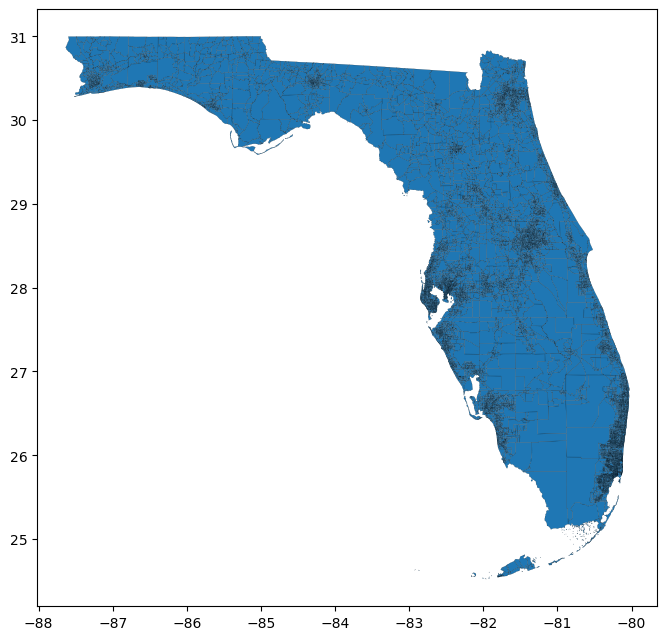

In [3]:
import geopandas as gpd

# Read the file you just wrote in R
ses_gdf = gpd.read_file("fl_bg.geojson")

# Inspect
print(ses_gdf.shape)        # should be (13350, 3) if you had 2 attribute fields + geometry
print(ses_gdf.head())

# Quick plot
ses_gdf.plot(figsize=(8,8), edgecolor="black", linewidth=0.1)


In [4]:
import os
import math
import logging
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely import wkt
from shapely.geometry import Point

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM  # Assuming these might be used later from original imports
from peft import PeftModel


In [5]:

CONFIG = {
    # File Paths
    "HEX_FILE_PATH": "Hex_tesse_raw.parquet",
    "POI_FILE_PATH": "Hull_FL_poi_vec_subset.csv",
    "CHECKPOINT_PATH": "bottleneck_mlp_newdata.pth",
    "OUTPUT_PATH": "POI_encoded_embeddings.parquet",
    
    # Coordinate Reference Systems
    "CRS_GEOGRAPHIC": "EPSG:4326",
    "CRS_PROJECTED": "EPSG:5070",  # Using an equal-area projection for the US
    
    # Model Hyperparameters
    "LATENT_DIM": 64,
    "HIDDEN_DIM": 256,
    
    # Training Hyperparameters
    "BATCH_SIZE": 128,
    "LEARNING_RATE": 1e-4,
    "EPOCHS": 40,
    
    # System Configuration
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "NUM_WORKERS": 4,
}

# ─── PyTorch Model Definition ────────────────────────────────────────────────

class BottleneckMLP(nn.Module):
    """A Bottleneck Multi-Layer Perceptron for dimensionality reduction and classification."""
    def __init__(self, in_dim, hid_dim, lat_dim, n_cls):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(hid_dim, lat_dim),
            nn.LeakyReLU(0.01, inplace=True)
        )
        self.head = nn.Linear(lat_dim, n_cls)

    def forward(self, x):
        z = self.encoder(x)
        logits = self.head(z)
        return z, logits

# ─── Data Loading and Preprocessing Functions ────────────────────────────────

def load_hexagon_data(file_path, crs):
    """Loads and preprocesses the hexagon GeoDataFrame."""
    logging.info(f"Loading hexagon data from {file_path}...")
    hex_gdf = pd.read_parquet(file_path)
    hex_gdf = hex_gdf.reset_index(drop=True)
    hex_gdf["hex_id"] = hex_gdf.index.astype(str)
    hex_gdf["geometry"] = gpd.GeoSeries.from_wkb(hex_gdf["geometry"])
    hex_gdf = gpd.GeoDataFrame(hex_gdf, geometry="geometry", crs=crs)
    logging.info(f"Hexagon data loaded with {len(hex_gdf)} hexagons.")
    return hex_gdf

def load_poi_data(file_path, crs):
    """Loads and preprocesses the POI GeoDataFrame."""
    logging.info(f"Loading POI data from {file_path}...")
    table = pv.read_csv(
        file_path,
        read_options=ReadOptions(block_size=1 << 20),
        parse_options=ParseOptions(delimiter=",", quote_char='"', newlines_in_values=True)
    )
    df = table.to_pandas()
    df["geometry"] = df["geometry"].apply(wkt.loads)
    poi_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
    logging.info(f"POI data loaded with {len(poi_gdf)} points.")
    return poi_gdf

def parse_vector_column(series: pd.Series) -> np.ndarray:
    """Parses a string representation of vectors into a stacked NumPy array."""
    logging.info("Parsing string vectors into NumPy array...")
    def parse_vec(s: str) -> np.ndarray:
        if isinstance(s, (list, np.ndarray)):
            return np.array(s, dtype=np.float32)
        return np.fromstring(s.strip("[]"), sep=" ", dtype=np.float32)
    
    vecs = np.stack(series.map(parse_vec).values)
    return vecs

# ─── Model Training and Inference Functions ──────────────────────────────────

def train_or_load_model(config, loader, n_classes, class_labels):
    """Instantiates the model and optimizer, then loads from checkpoint or trains."""
    logging.info("Initializing model, optimizer, and criterion...")
    model = BottleneckMLP(
        in_dim=loader.dataset.tensors[0].shape[1],
        hid_dim=config["HIDDEN_DIM"],
        lat_dim=config["LATENT_DIM"],
        n_cls=n_classes
    ).to(config["DEVICE"])

    optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
    criterion = nn.CrossEntropyLoss()

    if os.path.exists(config["CHECKPOINT_PATH"]):
        logging.info(f"Loading pretrained model from {config['CHECKPOINT_PATH']}")
        ckpt = torch.load(config["CHECKPOINT_PATH"], map_location=config["DEVICE"])
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    else:
        logging.info("No checkpoint found—starting training from scratch.")
        for epoch in range(1, config["EPOCHS"] + 1):
            model.train()
            loop = tqdm(loader, desc=f"Epoch {epoch}/{config['EPOCHS']}", unit="batch")
            total_loss = 0.0
            for xb, yb in loop:
                xb, yb = xb.to(config["DEVICE"]), yb.to(config["DEVICE"])
                optimizer.zero_grad()
                _, logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * xb.size(0)
                loop.set_postfix(loss=loss.item())
            avg_loss = total_loss / len(loader.dataset)
            print(f"→ Epoch {epoch:2d}: avg loss = {avg_loss:.4f}")
        
        logging.info(f"Training complete—saving checkpoint to {config['CHECKPOINT_PATH']}")
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "classes": class_labels
        }, config["CHECKPOINT_PATH"])
    
    return model

def encode_features(model, loader, device):
    """Runs inference to generate latent embeddings for the input data."""
    logging.info("Encoding features to generate latent vectors (Z)...")
    model.eval()
    all_z = []
    with torch.no_grad():
        for xb, _ in tqdm(loader, desc="Encoding"):
            xb = xb.to(device)
            z = model.encoder(xb)
            all_z.append(z.cpu().numpy())
    
    return np.vstack(all_z)

# ─── Geospatial Processing Function ──────────────────────────────────────────

def assign_pois_to_hexagons(poi_gdf, hex_gdf):
    """Reprojects and performs a nearest-neighbor join to assign POIs to hexagons."""
    logging.info("Reprojecting GeoDataFrames to equal-area CRS for accurate nearest-neighbor search...")
    poi_proj = poi_gdf.to_crs(epsg=CONFIG["CRS_PROJECTED"])
    hex_proj = hex_gdf.to_crs(epsg=CONFIG["CRS_PROJECTED"])

    logging.info("Assigning POIs to nearest hexagon...")
    joined_gdf = gpd.sjoin_nearest(
        poi_proj,
        hex_proj[["hex_id", "geometry"]],
        how="left"
    )

    logging.info(f"Join completed. Matched points: {joined_gdf['hex_id'].notna().sum()}/{len(poi_gdf)}")
    
    # Reproject final result back to geographic coordinates
    joined_gdf = joined_gdf.to_crs(epsg=CONFIG["CRS_GEOGRAPHIC"])
    return joined_gdf

In [6]:
hex_gdf = load_hexagon_data("Hex_tesse_raw.parquet","epsg:4326")

In [8]:
try:
    hex_gdf = hex_gdf.drop(columns="hexid")
except Exception as e:
    print("deleted")
print(hex_gdf)

                                                geometry hex_id
0      POLYGON ((-88.55028 30.36403, -88.54055 30.359...      0
1      POLYGON ((-88.55028 30.37372, -88.55028 30.364...      1
2      POLYGON ((-88.55028 30.3931, -88.54055 30.3882...      2
3      POLYGON ((-88.55028 30.40278, -88.55028 30.393...      3
4      POLYGON ((-88.55028 30.42215, -88.54055 30.417...      4
...                                                  ...    ...
67963  POLYGON ((-79.95377 26.33337, -79.95377 26.343...  67963
67964  POLYGON ((-79.95377 26.36356, -79.95377 26.373...  67964
67965  POLYGON ((-79.94405 26.37865, -79.94405 26.388...  67965
67966  POLYGON ((-79.94405 26.38871, -79.95377 26.393...  67966
67967  POLYGON ((-79.95377 26.42391, -79.95377 26.433...  67967

[67968 rows x 2 columns]


In [7]:
ses_gdf = ses_gdf.to_crs("EPSG:4326")

In [ ]:
ses_gdf

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(20, 20))

hex_gdf.boundary.plot(ax=ax, linewidth=0.05, edgecolor="gray",alpha=0.5)
states = gpd.read_file('cb_2018_us_state_500k.shp')
#state_plot = states.to_crs(epsg=3857)
states[states.STUSPS == "FL"].boundary.plot(
    ax=ax, linewidth=1, color="black"
)
ses_gdf.plot(ax=ax,cmap = "tab20", alpha = 0.9)
xmin, ymin, xmax, ymax = (-82.5, 27.9, -82.3, 28.1)  # example in EPSG:3857 coords

# 6) Create an inset axes for the zoom
axins = inset_axes(ax, width="50%", height="50%", loc="lower left", borderpad=1)
axins.set_xlim(xmin, xmax)
axins.set_ylim(ymin, ymax)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="red", lw=1)
hex_gdf.boundary.plot(ax=axins, linewidth=0.1, edgecolor="black",alpha=0.9)
#ax.axes(False)
states[states.STUSPS == "FL"].boundary.plot(
    ax=axins, linewidth=1, color="black"
)
ses_gdf.plot(ax=axins,cmap = "tab20", alpha = 0.9)
plt.savefig("hex_tess_ses.png",dpi=300)
plt.show()

In [8]:
gdf = gpd.read_parquet("POI_encoded_embeddings.parquet")

In [9]:

# 2) Expand the `z` list/array into its own DataFrame of shape (N, D)
#    so each dimension becomes a column z0, z1, ..., z{D-1}
z_expanded = pd.DataFrame(
    gdf["z"].tolist(),
    index=gdf.index
)
z_expanded.columns = [f"z{i}" for i in range(z_expanded.shape[1])]

# 3) Combine back with the labels
df_expanded = pd.concat([gdf["label_pair"], z_expanded], axis=1)

# 4) Group by label_pair and take the mean → this is your “center” per class
centers_df = df_expanded.groupby("label_pair").mean()

In [10]:

ses_gdf = ses_gdf.reset_index(drop=True)

# 2) copy that index into your new hex_id column
ses_gdf["hex_id"] = ses_gdf.index
ses_gdf

,GEOID,NAME,geometry,hex_id
0,120860001303,3,"MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...",0
1,121030268141,1,"MULTIPOLYGON (((-82.70074 28.03389, -82.69771 ...",1
2,120570065041,1,"MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...",2
3,121270803003,3,"MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...",3
4,120710501064,4,"MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...",4
...,...,...,...,...
13345,120710104151,1,"MULTIPOLYGON (((-82.06879 26.56344, -82.06437 ...",13345
13346,120990075043,3,"MULTIPOLYGON (((-80.09112 26.33261, -80.08951 ...",13346
13347,120310144132,2,"MULTIPOLYGON (((-81.55911 30.18003, -81.55849 ...",13347
13348,120190307061,1,"MULTIPOLYGON (((-81.71425 30.08813, -81.71339 ...",13348


In [ ]:
gdf

In [11]:
#ses_gdf.to_crs(ESPG:5070)
gdf = gdf.to_crs(ses_gdf.crs)
#gdf = gdf.drop(columns=["hex_id"])
# 2) keep only the hex_id + geometry in the hex‐grid
hexes = ses_gdf[["hex_id", "geometry"]]

# 3) spatial join: for each point, find the hex whose polygon it lies within
#    – predicate="within" for GeoPandas ≥ 0.10, or op="within" for older versions
joined = gpd.sjoin(
    gdf,
    hexes,
    how="left",          # keep all points, even those that fall outside
    #predicate="within"   # use "op='within'" if your GeoPandas is <0.10
)

# 4) clean up the result: drop the auto‐added index_right column
joined = joined.drop(columns=["hex_id_left","index_right"])

# now `joined` has all of your original point columns **plus** a `hex_id` column
print(joined)
joined = joined.rename(columns={"hex_id_right":"hex_id"})

                                                label_pair  \
0        Activities Related to Real Estate[sep]Resident...   
1        Offices of Real Estate Agents and Brokers[sep]...   
2        Sporting Goods, Hobby, and Musical Instrument ...   
3              Offices of Dentists[sep]Offices of Dentists   
4        Museums, Historical Sites, and Similar Institu...   
...                                                    ...   
1548012  Home Furnishings Stores[sep]All Other Home Fur...   
1548013  Urban Transit Systems[sep]Bus and Other Motor ...   
1548014  Urban Transit Systems[sep]Bus and Other Motor ...   
1548015  Urban Transit Systems[sep]Bus and Other Motor ...   
1548016  Urban Transit Systems[sep]Bus and Other Motor ...   

                                                         z  \
0        [61.499184, 25.730932, 28.544409, 16.33576, 38...   
1        [10.239435, 8.276576, 44.785103, 72.61034, 19....   
2        [23.133112, 20.673256, 16.964842, 24.288828, 2...   
3      

In [15]:
print(sum(joined["hex_id"].isna())/len(joined))
joined = joined.dropna(subset=["hex_id"])
joined.to_crs("EPSG:4326")
print(joined)
#joined["hex_id"] = joined["hex_id"].apply(int)

0.0
                                                label_pair  \
0        Activities Related to Real Estate[sep]Resident...   
1        Offices of Real Estate Agents and Brokers[sep]...   
2        Sporting Goods, Hobby, and Musical Instrument ...   
3              Offices of Dentists[sep]Offices of Dentists   
4        Museums, Historical Sites, and Similar Institu...   
...                                                    ...   
1548012  Home Furnishings Stores[sep]All Other Home Fur...   
1548013  Urban Transit Systems[sep]Bus and Other Motor ...   
1548014  Urban Transit Systems[sep]Bus and Other Motor ...   
1548015  Urban Transit Systems[sep]Bus and Other Motor ...   
1548016  Urban Transit Systems[sep]Bus and Other Motor ...   

                                                         z  \
0        [61.499184, 25.730932, 28.544409, 16.33576, 38...   
1        [10.239435, 8.276576, 44.785103, 72.61034, 19....   
2        [23.133112, 20.673256, 16.964842, 24.288828, 2...   
3  

In [16]:
mean_vecs = (
    joined
    .groupby('hex_id')['z']
    .agg(lambda arrs: np.mean(np.stack(arrs.values), axis=0))
)
# mean_vecs is a Series: index=hex_id, value=np.ndarray(1152,)

# 2a) merge into hex_gdf
ses_gdf = ses_gdf.merge(
    mean_vecs.rename('vec_mean'),
    left_on='hex_id',
    right_index=True,
    how='left'
)



In [17]:
tt_bg_FL["GEOID"] = tt_bg_FL["GEOID"].astype(str)

# (optional) also ensure ses_gdf.GEOID is string
ses_gdf["GEOID"] = ses_gdf["GEOID"].astype(str)

# 3) now do the merge
merged = ses_gdf.merge(
    tt_bg_FL,
    on="GEOID",
    how="left"   # or "inner" if you only want matching IDs
)

# 4) merged is still a GeoDataFrame with geometry + your new columns
print(merged.shape)
merged.head()

(13350, 308)


,GEOID,NAME_x,geometry,hex_id,vec_mean_x,vec_mean_y,NAME_y,Total:,Total: Under .50,Total: .50 to .99,...,Total: With an Internet subscription Broadband of any type,Total: With an Internet subscription Cellular data plan,Total: With an Internet subscription Cellular data plan Cellular data plan with no other type of Internet subscription,"Total: With an Internet subscription Broadband such as cable, fiber optic or DSL","Total: With an Internet subscription Broadband such as cable, fiber optic or DSL Broadband such as cable, fiber optic or DSL with no other type of Internet subscription",Total: With an Internet subscription Satellite Internet service,Total: With an Internet subscription Satellite Internet service Satellite Internet service with no other type of Internet subscription,Total: With an Internet subscription Other service with no other type of Internet subscription,Total: Internet access without a subscription,Total: No Internet access
0,120860001303,3,"MULTIPOLYGON (((-80.12204 25.92989, -80.12043 ...",0,"[33.6305, 35.814537, 14.019923, 40.46885, 28.7...","[33.6305, 35.814537, 14.019923, 40.46885, 28.7...",Block Group 3; Census Tract 1.30; Miami-Dade C...,279,0,42,...,183,183,0,160,0,33,0,0,14,0
1,121030268141,1,"MULTIPOLYGON (((-82.70074 28.03389, -82.69771 ...",1,"[28.050043, 36.334988, 19.818258, 34.684147, 3...","[28.050043, 36.334988, 19.818258, 34.684147, 3...",Block Group 1; Census Tract 268.14; Pinellas C...,992,16,19,...,429,392,46,375,29,0,0,8,0,5
2,120570065041,1,"MULTIPOLYGON (((-82.53205 27.89599, -82.53192 ...",2,"[37.87849, 41.17299, 24.685835, 38.813133, 35....","[37.87849, 41.17299, 24.685835, 38.813133, 35....",Block Group 1; Census Tract 65.04; Hillsboroug...,411,17,55,...,198,177,2,166,21,28,0,0,11,52
3,121270803003,3,"MULTIPOLYGON (((-81.06403 29.32267, -81.06218 ...",3,"[46.378544, 34.71072, 28.458584, 43.096386, 30...","[46.378544, 34.71072, 28.458584, 43.096386, 30...",Block Group 3; Census Tract 803; Volusia Count...,1024,69,2,...,465,346,18,400,119,11,0,0,60,139
4,120710501064,4,"MULTIPOLYGON (((-81.85447 26.49909, -81.85401 ...",4,"[39.790993, 35.508392, 29.290495, 40.39536, 39...","[39.790993, 35.508392, 29.290495, 40.39536, 39...",Block Group 4; Census Tract 501.06; Lee County...,582,0,40,...,350,334,33,317,16,0,0,0,35,17


In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Suppose df is your original GeoDataFrame with 307 cols:
df = merged.copy()

# 1) Pick off the columns you want to exempt (by name or by position)
exempt = list(df.columns[:7])   # e.g. first four columns
to_impute = df.columns.difference(exempt)

# 2) Fit & transform only the “to_impute” slice
imp = IterativeImputer(random_state=0)
imputed_vals = imp.fit_transform(df[to_impute])

# 3) Rebuild a new DataFrame for the imputed part
df_imp = pd.DataFrame(imputed_vals,
                      columns=to_impute,
                      index=df.index)

# 4) Concatenate the exempted + imputed parts, preserving original order
df_final = pd.concat([df[exempt], df_imp], axis=1)[df.columns]


In [ ]:
df_final.to_parquet("imputed_ses.parquet")

In [19]:
df_final = pd.read_parquet("imputed_ses.parquet")

In [ ]:
df_final

In [18]:
import geopandas as gpd
from libpysal.weights import Queen
import networkx as nx

# 1) (Optional) make sure your geometries are in a planar CRS
#    Queen contiguity only makes sense in projected (not geographic) coordinates:
merged = merged.to_crs(epsg=3857)

# 2) build a Queen‐contiguity weight object,
#    telling PySAL which column holds the unique ID (here “hex_id”) and which holds the geometry:
wq = Queen.from_dataframe(
    merged,
    idVariable="hex_id",
    geom_col="geometry"
)

# 3) if you want the raw neighbor lists:
#    wq.neighbors is a dict: { hex_id_1: [nbr1, nbr2,…], hex_id_2: […], … }
print("example neighbors for one cell:", list(wq.neighbors.items())[:3])

# 4) to turn that into a NetworkX graph:
G = wq.to_networkx()

# 5) now you can check connectivity exactly as before
comps = list(nx.connected_components(G))
print(f"{len(comps)} components total")
islands = [c.pop() for c in comps if len(c)==1]
print("Singleton islands:", islands)
merged['centroid'] = merged.geometry.centroid
centroids = merged.set_index('hex_id')['centroid']

# 2) for each island, find its nearest neighbour and add an edge
for iso in islands:
    # distances to all other centroids
    dists = centroids.distance(centroids.loc[iso]).drop(index=iso)
    nearest = dists.idxmin()
    G.add_edge(iso, nearest)

comps   = list(nx.connected_components(G))
islands = [next(iter(c)) for c in comps if len(c) == 1]

# 2) compute centroids (once)
merged = merged.to_crs(epsg=3857)
merged['centroid'] = merged.geometry.centroid
centroids = merged.set_index('hex_id')['centroid']

# 3) stitch each singleton onto its nearest neighbor:
for iso in islands:
    dists   = centroids.distance(centroids.loc[iso]).drop(index=iso)
    nearest = dists.idxmin()
    G.add_edge(iso, nearest)

# 4) now recompute & sort your components
comps = list(nx.connected_components(G))
comps = sorted(comps, key=len, reverse=True)
main_comp = list(comps[0])

# 5) bridge every other component into the main one
for comp in comps[1:]:
    comp = list(comp)
    best_pair = None
    best_dist = float('inf')
    for hid in comp:
        dists = centroids.loc[main_comp].distance(centroids.loc[hid])
        j     = dists.idxmin()
        d     = dists.min()
        if d < best_dist:
            best_dist = d
            best_pair = (hid, j)
    # now best_pair is guaranteed to be a 2‑tuple
    G.add_edge(*best_pair)


/tmp/582147.tmpdir/ipykernel_1281/588510722.py:11: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  wq = Queen.from_dataframe(
/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 6 islands with ids: 6126, 9175, 9234, 10256, 11174, 11374.
  W.__init__(self, neighbors, ids=ids, **kw)


example neighbors for one cell: [(0, [4164, 8852, 3276, 3229, 12463]), (1, [12610, 3145, 10207, 10205, 3183]), (2, [6353, 9719, 7245, 766, 5711])]
10 components total
Singleton islands: [6126, 9175, 9234, 10256, 11174, 11374]


In [ ]:
comps = list(nx.connected_components(G))
len(comps)

In [ ]:
import pickle
with open("ses_graph.pickle","wb") as f:
    pickle.dump(G,f)

In [20]:
import pickle
with open("ses_graph.pickle","rb") as f:
    G = pickle.load(f)

In [ ]:
EMBEDDING_FILENAME = "models/ses.emb"
EMBEDDING_MODEL_FILENAME = "models/ses_model_embeddings.model"
# Load model after Node2Vec.save
from node2vec import Node2Vec
from gensim.models import Word2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=128, num_walks=16, workers=10)  # Use temp_folder for big graphs
model = node2vec.fit(vector_size=64, window=16, min_count=3, workers=8)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

In [ ]:
!    pip install numpy==1.26.4

In [ ]:
!pip uninstall -y k-means-constrained

In [ ]:
!pip uninstall -y gensim
!pip install --no-cache-dir --force-reinstall "gensim==4.3.3"


In [ ]:
import sys, numpy as np
print(sys.version)
print("numpy:", np.__version__)
# import gensim  # will fail right now, that's the point


In [21]:
EMBEDDING_FILENAME = "models/ses.emb"
EMBEDDING_MODEL_FILENAME = "models/ses_model_embeddings.model"
# Load model after Node2Vec.save
import numpy as np
from node2vec import Node2Vec
from gensim.models import Word2Vec

vec_model = Word2Vec.load(EMBEDDING_MODEL_FILENAME)
embeddings = {node: vec_model.wv[node] for node in G.nodes()}
emb_dataframe = pd.DataFrame.from_dict(embeddings)

In [22]:
vecs = emb_dataframe.to_numpy().T   # shape (N, D)

# 2) turn each row into a Python list
vec_lists = vecs.tolist()           # [ [float,…,float], … ]

# 3) assign by position (assuming hex_gdf is already sorted by hex_id 0…N-1)
ses_gdf['graph_embedding'] = vec_lists

In [ ]:
ses_gdf

In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
# 4) Move to GPU/CPU and set eval mode:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 1) Where you saved your LoRA adapters after training:
CHECKPOINT = "/storage1/fs1/nlin/Active/sizhe/FO_DATA/checkpoint-dir/checkpoint-551"

# 2) Load the tokenizer from that folder (it contains tokenizer.json + vocab.txt)
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

base_name = "google/gemma-3-1b-it"     # <— exactly what you passed in your training script
base = AutoModelForCausalLM.from_pretrained(
    "google/gemma-3-1b-it",
    attn_implementation="eager"
).to(device)

# 3) Now graft the adapter weights:
llm_model = PeftModel.from_pretrained(base, CHECKPOINT,strict=False)


#llm_model.to(device).eval()



/storage1/fs1/nlin/Active/sizhe/sizhe/envs/geospatial/lib/python3.12/site-packages/peft/peft_model.py:565: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight', 'base_mo

In [24]:
def embed_texts(texts: list[str]) -> torch.Tensor:
    """
    texts: a Python list of strings (each may contain literal "[sep]").
    example: ["[Museums, Historical Sites,...<sep>Museums, Historical Sites<sep>Natural History museum]",...]
    In the format of [<category><sep><subcategory><sep><name>]
    Returns: a GPU tensor of shape (len(texts), hidden_size) containing the
             final‐token embedding for each string.
    """
    # 2.1) Clean & force everything to str, replacing None/NaN with ""
    clean_texts=[]
    for t in texts:
        if t is None:
            clean_texts.append("")
        else:
            clean_texts.append(str(t))
    sep = tokenizer.sep_token  # e.g. "[SEP]" for BERT‐style; whatever your tokenizer.sep_token is
    clean_texts = [t.replace("[sep]", sep) for t in clean_texts]
    
    # 2.3) Batch‐tokenize all strings onto GPU
    enc = tokenizer(
        clean_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
        return_token_type_ids=False,
    ).to(device)
    #print("Batch input_ids are on:", enc.input_ids.device)
    # Now enc.input_ids and enc.attention_mask live on GPU.

    # 2.4) Forward‐pass (no gradients) to get hidden states
    with torch.no_grad():
        outputs = llm_model.base_model(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            output_hidden_states=True
        )
        # `outputs.hidden_states` is a tuple of length (num_layers+1);
        # each element has shape (batch_size, seq_len, hidden_size).
        last_hidden = outputs.hidden_states[-1]  # (batch_size, seq_len, hidden_size) on GPU

    # 2.5) For each sequence, pick out the final non‐pad token embedding
    seq_lens = enc.attention_mask.sum(dim=1) - 1  # (batch_size,) on GPU, index of last non-pad
    batch_size, hidden_size = last_hidden.size(0), last_hidden.size(2)

    # Gather the embedding at position (i, seq_lens[i], :)
    final_embs = last_hidden[torch.arange(batch_size), seq_lens, :]  # (batch_size, hidden_size) on GPU
    #print((final_embs))
    return final_embs


In [25]:
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
null_emb   = embed_texts(["<null_val>[sep]<null_val>"]) 
# null_emb is already a tensor
print(type(null_emb), null_emb.shape, null_emb.device)

# add the batch‐dim, cast & move to DEVICE
null_tensor = null_emb.float().unsqueeze(0).to(DEVICE)
print(null_tensor, null_tensor.device)

<class 'torch.Tensor'> torch.Size([1, 1152]) cuda:0
tensor([[[ 1.4538, -8.0599,  0.6345,  ..., -0.2421,  0.9947,  0.2485]]],
       device='cuda:0') cuda:0


In [26]:

ckpt = torch.load("bottleneck_mlp_newdata.pth",map_location = "cuda",weights_only=False)

raw_classes = ckpt.get("classes", None)
# Determine number of classes
n_old = len(raw_classes) if raw_classes is not None else ckpt["model_state_dict"]["head.bias"].shape[0]

# Convert classes to Python list
if raw_classes is None:
    classes = [f"class_{{i}}" for i in range(n_old)]
elif isinstance(raw_classes, np.ndarray):
    classes = raw_classes.tolist()
else:
    classes = list(raw_classes)
# Recreate and load your original BottleneckMLP
class BottleneckMLP(nn.Module):
    def __init__(self, in_dim, hid_dim, lat_dim, n_cls):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, lat_dim),
            nn.ReLU()
        )
        self.head = nn.Linear(lat_dim, n_cls)

    def forward(self, x):
        z = self.encoder(x)
        logits = self.head(z)
        return z, logits

# Extract dims from checkpoint
in_dim     = ckpt["model_state_dict"]["encoder.0.weight"].shape[1]
hid_dim    = ckpt["model_state_dict"]["encoder.0.weight"].shape[0]
lat_dim    = ckpt["model_state_dict"]["encoder.2.weight"].shape[0]

# Instantiate and load weights
bottleneck_model = BottleneckMLP(in_dim, hid_dim, lat_dim, n_old).to(device)
bottleneck_model.load_state_dict(ckpt["model_state_dict"])
bottleneck_model.eval()



BottleneckMLP(
  (encoder): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
  )
  (head): Linear(in_features=64, out_features=751, bias=True)
)

In [27]:
idx = 0

# 2) grab the weight‐row (and optional bias)
with torch.no_grad():
    w_cls = bottleneck_model.head.weight[idx]     # torch.Tensor of shape (latent_dim,)
    b_cls = bottleneck_model.head.bias[idx]       # scalar


In [28]:
gdf

,label_pair,z,geometry,cat_name,cat_count,weight,hex_id
0,Activities Related to Real Estate[sep]Resident...,"[61.499184, 25.730932, 28.544409, 16.33576, 38...",POINT (-82.52482 27.94908),Activities Related to Real Estate,24,576,33561
1,Offices of Real Estate Agents and Brokers[sep]...,"[10.239435, 8.276576, 44.785103, 72.61034, 19....",POINT (-81.38077 30.19916),Offices of Real Estate Agents and Brokers,107,11449,52159
2,"Sporting Goods, Hobby, and Musical Instrument ...","[23.133112, 20.673256, 16.964842, 24.288828, 2...",POINT (-81.76929 24.5666),"Sporting Goods, Hobby, and Musical Instrument ...",7,49,44888
3,Offices of Dentists[sep]Offices of Dentists,"[21.774567, 62.81708, 77.10956, 94.822975, 61....",POINT (-81.68255 30.20312),Offices of Dentists,70,4900,46628
4,"Museums, Historical Sites, and Similar Institu...","[48.68053, 51.811516, -0.24616693, 46.184406, ...",POINT (-81.84711 26.64202),"Museums, Historical Sites, and Similar Institu...",8,64,43514
...,...,...,...,...,...,...,...
1548012,Home Furnishings Stores[sep]All Other Home Fur...,"[33.14433, -0.046613265, 46.66763, 36.16918, 2...",POINT (-81.42641 29.78401),Home Furnishings Stores,1,1,51477
1548013,Urban Transit Systems[sep]Bus and Other Motor ...,"[10.560505, 53.101013, 18.382906, 5.375622, 64...",POINT (-81.07024 29.21795),Urban Transit Systems,16,256,56590
1548014,Urban Transit Systems[sep]Bus and Other Motor ...,"[5.115786, 64.99983, 25.311647, 19.811197, 78....",POINT (-81.32279 29.04255),Urban Transit Systems,8,64,52995
1548015,Urban Transit Systems[sep]Bus and Other Motor ...,"[13.166652, 72.90378, 16.78043, -0.050964173, ...",POINT (-81.01938 29.24983),Urban Transit Systems,30,900,57118


In [29]:
def fill_vec(x):
    # detect the NaN (it's a float)
    if isinstance(x, float) and pd.isna(x):
        return (w_cls+b_cls).cpu().detach().numpy()
    else:
        return x

#ses_gdf['vec_mean'] = ses_gdf['vec_mean'].apply(fill_vec)


#hex_gdf['vec_max'] = hex_gdf['vec_max'].apply(fill_vec)

In [ ]:
ses_gdf

In [30]:
import pickle
with open("point_gdf_raw.pickle","rb") as f:
    point_gdf = pickle.load(f)

In [ ]:
point_gdf = gpd.read_parquet("simulated_traj_points.parquet")

In [ ]:
point_gdf

In [32]:
import numpy as np 
# 1) extract just the category name (before “[sep]”) 
joined = joined.copy()
joined['cat_name'] = joined['label_pair'].str.split(r'\[sep\]').str[0] 
# 2) compute the count per (hex_id, cat_name) and square it 
joined['cat_count'] = joined.groupby(['hex_id','cat_name'])['z'].transform('count') 
joined['weight'] = joined['cat_count'] ** 2 
# 4) (optional) weighted‐average instead of sum 
weighted_avg = ( joined .groupby('hex_id') .apply(lambda df: (np.stack(df['z'].values) * df['weight'].values[:, None]).sum(axis=0) / df['weight'].sum() ) )

# 5) merge back into your hex_gdf 
ses_gdf = ses_gdf.merge( weighted_avg.rename('vec_weighted_avg'), left_on='hex_id', right_index=True, how='left' )

/tmp/582147.tmpdir/ipykernel_2673/3162613191.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = ( joined .groupby('hex_id') .apply(lambda df: (np.stack(df['z'].values) * df['weight'].values[:, None]).sum(axis=0) / df['weight'].sum() ) )


In [33]:
ses_gdf['vec_weighted_avg'] = ses_gdf['vec_weighted_avg'].apply(fill_vec)

In [ ]:
ses_gdf

In [34]:
new_df = ses_gdf.merge(merged, on="hex_id", how="left",suffixes=(None,"_y"))


In [35]:
new_df = new_df.loc[:, ~new_df.columns.str.endswith("_y")]   # drop all right duplicates


In [ ]:
new_df

In [36]:
point_buffer = point_gdf.to_crs(epsg=5070)
ses_buffer = new_df.to_crs(epsg=5070)
ses_buffer["centroid"] = ses_buffer.centroid
ses_gdf = ses_buffer.to_crs(epsg=4326)

joined_nearest_ll = gpd.sjoin_nearest(
    point_buffer[["traj_id", "pt_idx", "geometry"]],  # keep only the columns we care about
    ses_buffer.loc[:, ses_buffer.columns != 'NAME_x'],
    how="left"           # keep all points; hex attributes will be NaN if a point is unmatche
)
joined_nearest = joined_nearest_ll.to_crs(epsg=4326)
print(joined_nearest)

                                                   traj_id  pt_idx  \
0        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...       1   
1        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...       3   
2        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...       5   
3        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...      20   
4        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...      21   
...                                                    ...     ...   
1677305  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     130   
1677306  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     133   
1677307  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     134   
1677308  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     140   
1677309  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     141   

                           geometry  index_right         GEOID NAME  hex_id  \
0        POINT (-81.79671 24.54831)         9176  120879724002    2    9176   
1

In [37]:
clean_joined = joined_nearest.drop_duplicates(subset=["traj_id", "pt_idx"])
print(clean_joined.crs)

print(clean_joined)

EPSG:4326
                                                   traj_id  pt_idx  \
0        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...       1   
1        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...       3   
2        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...       5   
3        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...      20   
4        e464d76fd1b9ea6e0c135c0292581eccc3f27306fb76af...      21   
...                                                    ...     ...   
1677305  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     130   
1677306  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     133   
1677307  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     134   
1677308  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     140   
1677309  559f9e9acaaf7e32ea1c7b2616af890a63a5fd8ebd2a54...     141   

                           geometry  index_right         GEOID NAME  hex_id  \
0        POINT (-81.79671 24.54831)         9176  120879724002    2   

In [ ]:
ses_gdf

In [ ]:
clean_joined.vec_weighted_avg[0]

In [38]:
df = clean_joined.copy()
feature_dict = {}
timeidx_dict = {}
df["vec_weighted_avg"] = df["vec_weighted_avg"].apply(fill_vec)
FIXED_LEN=143
for traj_id, group in df.groupby('traj_id'):
    grp = group.sort_values('pt_idx')
    embs = np.stack(grp['graph_embedding'].values)    # (L, E)
    vecs = np.stack(grp['vec_weighted_avg'].values)   # (L, V)
    feature_dict[traj_id] = np.concatenate([embs, vecs], axis=1)  # (L, E+V)
    # time indices must be integers in [0..FIXED_LEN-1]
    # if pt_idx is 1-based you may want pt_idx-1; also clamp to FIXED_LEN-1
    times = grp['pt_idx'].to_numpy().astype(int) - 1      
    times = np.clip(times, 0, FIXED_LEN-1)
    timeidx_dict[traj_id] = times


In [41]:
class TrajDatasetWithTimes(Dataset):
    def __init__(self, feature_dict, timeidx_dict):
        self.ids       = list(feature_dict.keys())
        self.features  = feature_dict
        self.times     = timeidx_dict

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        traj_id = self.ids[i]
        feat    = torch.from_numpy(self.features[traj_id]).float()  # (L, D)
        times   = torch.from_numpy(self.times[traj_id]).long()     # (L,)
        return feat, times, i, traj_id

# 3) Custom collate that scatters each sample into its true time slots
def collate_fn_time(batch):
    B = len(batch)
    feats, times_list, idxs = zip(*batch)
    D = feats[0].size(1)

    padded   = torch.zeros(B, FIXED_LEN, D, dtype=torch.float)
    pad_mask = torch.ones (B, FIXED_LEN,    dtype=torch.bool)

    for i, (feat, times) in enumerate(zip(feats, times_list)):
        valid     = times < FIXED_LEN
        t_idx     = times[valid]
        f_vec     = feat[valid]         # shape (L_valid, D)
        padded[i, t_idx]   = f_vec
        pad_mask[i, t_idx] = False

    idxs = torch.tensor(idxs, dtype=torch.long)
    return padded, pad_mask, idxs

# 4) Build loaders


# ─── Positional Encoding ────────────────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() *
                        -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]  # broadcast-add


# ─── DEC Loss Components ───────────────────────────────────────────────────────
def student_t_distribution(z, centers, alpha=1.0):
    diff = z.unsqueeze(1) - centers.unsqueeze(0)
    dist2 = diff.pow(2).sum(-1)
    num = (1 + dist2/alpha).pow(-(alpha+1)/2)
    return num / num.sum(1, keepdim=True)

def target_distribution(q):
    weight = q.pow(2) / q.sum(0, keepdim=True)
    return (weight / weight.sum(1, keepdim=True))

In [42]:
import math
import torch
from torch import nn

# ---- Positional encoding with 24h time-of-day ----
class PositionalEncodingTimeOfDay(nn.Module):
    def __init__(self, d_model: int, max_len: int = 500, hod_harmonics: int = 1):
        """
        d_model: model dimension
        max_len: max sequence length for absolute PE
        hod_harmonics: number of 24h harmonics (1 => sin/cos; 2+ adds higher freq)
        """
        super().__init__()
        # Absolute sinusoidal PE (as you had)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float)
            * (-(torch.log(torch.tensor(10000.0)) / d_model))
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0), persistent=False)  # (1, max_len, d_model)

        # 24h cyclic features -> project to d_model, then add
        self.hod_harmonics = int(hod_harmonics)
        self.hod_proj = nn.Linear(2 * self.hod_harmonics, d_model, bias=False)
        # learnable gate so the model can scale this signal
        self.hod_scale = nn.Parameter(torch.tensor(1.0))

    @torch.no_grad()
    def _hours_from_start(self, B, L, device, start_hour):
        idx = torch.arange(L, device=device).view(1, L)  # 0..L-1
        if isinstance(start_hour, int):
            start = torch.full((B, 1), start_hour, device=device, dtype=torch.long)
        else:
            start = torch.as_tensor(start_hour, device=device).view(B, 1).long()
        return (start + idx) % 24  # (B, L)

    def forward(self, x, *, hours: torch.Tensor = None, start_hour=None):
        """
        x: (B, L, d_model)
        hours: optional (B, L) int tensor in [0..23]
        start_hour: optional int or (B,) tensor; used if `hours` is None
        """
        B, L, D = x.shape

        # absolute PE
        out = x + self.pe[:, :L]

        # time-of-day PE
        if hours is None:
            if start_hour is None:
                raise ValueError("Provide `hours` (B,L ints 0..23) or `start_hour` (int or (B,) tensor).")
            hours = self._hours_from_start(B, L, x.device, start_hour)
        else:
            hours = torch.as_tensor(hours, device=x.device).long()
            if hours.shape != (B, L):
                raise ValueError(f"`hours` must be (B, L), got {hours.shape}")

        phase = 2 * math.pi * (hours.float() / 24.0)  # (B, L)
        feats = []
        for m in range(1, self.hod_harmonics + 1):
            feats.append(torch.sin(m * phase))
            feats.append(torch.cos(m * phase))
        hod = torch.stack(feats, dim=-1)              # (B, L, 2*M)
        hod = self.hod_proj(hod) * self.hod_scale     # (B, L, d_model)

        return out + hod


# ---- Your model, modified to accept hours/start_hour and lengths ----
class TrajTransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=16, num_layers=3, dropout=0.1,
                 max_len=500, hod_harmonics=1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)

        # replace with time-of-day aware PE
        self.pos_enc = PositionalEncodingTimeOfDay(d_model, max_len=max_len,
                                                   hod_harmonics=hod_harmonics)

        enc_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True, dropout=dropout
        )
        dec_layer = nn.TransformerDecoderLayer(
            d_model, nhead, dim_feedforward=512, batch_first=True, dropout=dropout
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, input_dim)

    def _make_padding_mask(self, lengths, L, device):
        # True where we want to MASK (i.e., padding positions)
        if lengths is None:
            return None
        lengths = torch.as_tensor(lengths, device=device).long()  # (B,)
        idx = torch.arange(L, device=device).unsqueeze(0)         # (1, L)
        return (idx >= lengths.unsqueeze(1))                      # (B, L) boolean

    def forward(self, x, lengths=None, src_key_padding_mask=None,
                hours: torch.Tensor = None, start_hour=None):
        """
        x: (B, L, D_in)
        lengths: optional (B,) true lengths (for masks)
        hours: optional (B, L) integers 0..23 (time-of-day for each token)
        start_hour: optional int or (B,) if `hours` not provided
        """
        B, L, _ = x.shape
        device = x.device

        # masks
        if src_key_padding_mask is None:
            src_key_padding_mask = self._make_padding_mask(lengths, L, device)

        # ---- Encoder path
        src_emb = self.input_proj(x)  # (B, L, d_model)
        src_emb = self.pos_enc(src_emb, hours=hours, start_hour=start_hour)  # add abs + 24h
        memory = self.encoder(src_emb, src_key_padding_mask=src_key_padding_mask)

        # ---- Decoder input: zeros + SAME positions & hours (we reconstruct x at same steps)
        tgt_emb = torch.zeros(B, L, memory.size(-1), device=device)
        # pass the same hours/start_hour so decoder “knows” positions and day phase, too
        tgt_emb = self.pos_enc(tgt_emb, hours=hours, start_hour=start_hour)

        # If you have padding, use the same mask for tgt and memory padding mask
        output_seq = self.decoder(tgt_emb, memory,
                                  tgt_key_padding_mask=src_key_padding_mask,
                                  memory_key_padding_mask=src_key_padding_mask)

        recon = self.output_layer(output_seq)  # (B, L, input_dim)
        z = memory.mean(dim=1)                 # (B, d_model) latent embedding
        return recon, z


In [43]:
from torch.utils.data import Dataset, DataLoader
import torch

FIXED_LEN = 143

class TrajDatasetWithTimes(Dataset):
    def __init__(self, feature_dict, timeidx_dict):
        self.ids       = list(feature_dict.keys())
        self.features  = feature_dict
        self.times     = timeidx_dict

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        traj_id = self.ids[i]
        feat    = torch.from_numpy(self.features[traj_id]).float()  # (L, D) may contain NaNs
        times   = torch.from_numpy(self.times[traj_id]).long()      # (L,)
        return feat, times, i, traj_id


def make_collate_fn_time(fixed_len=143, start_hour=0, fill_value=0.0):
    def collate_fn_time(batch):
        B = len(batch)
        feats, times_list, idxs, traj_ids = zip(*batch)
        D = feats[0].size(1)

        padded   = torch.full((B, fixed_len, D), fill_value, dtype=torch.float)
        pad_mask = torch.ones (B, fixed_len,      dtype=torch.bool)
        obs_mask = torch.zeros(B, fixed_len, D,   dtype=torch.bool)

        for i, (feat, times) in enumerate(zip(feats, times_list)):
            # 1) keep only indices within range
            valid = (times >= 0) & (times < fixed_len)
            t = times[valid]           # (N,)
            f = feat[valid]            # (N, D)

            if t.numel() == 0:
                continue

            # 2) per-row observed flags and NaN-safe features
            obs_row   = torch.isfinite(f).to(f.dtype)         # (N, D) 1.0 where observed
            f_clean   = torch.nan_to_num(f, nan=0.0)          # (N, D)

            # 3) aggregate duplicates by unique time index
            uniq, inv = torch.unique(t, return_inverse=True)  # uniq: (M,), inv: (N,)
            M = uniq.numel()

            # sum of values per (uniq time, feature)
            sum_feat = torch.zeros(M, D, dtype=f.dtype)
            sum_feat.index_add_(0, inv, f_clean)

            # count of observed entries per (uniq time, feature)
            cnt_feat = torch.zeros(M, D, dtype=f.dtype)
            cnt_feat.index_add_(0, inv, obs_row)

            # mean over observed entries (stay 0 where count==0)
            mean_feat = sum_feat / cnt_feat.clamp_min(1.0)    # (M, D)
            obs_u     = cnt_feat > 0                           # (M, D) bool

            # 4) write once per unique index (no overlapping writes)
            padded[i, uniq]   = mean_feat
            obs_mask[i, uniq] = obs_u
            pad_mask[i, uniq] = False

        # hours-of-day (independent storage; safe even if later modified)
        hours_row = (torch.arange(fixed_len) + int(start_hour)) % 24  # (fixed_len,)
        hours = hours_row.unsqueeze(0).repeat(B, 1).long()            # (B, L)

        idxs = torch.tensor(idxs, dtype=torch.long)
        return padded, pad_mask, obs_mask, hours, idxs, list(traj_ids)
    return collate_fn_time


# ---- Build loader ----
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = TrajDatasetWithTimes(feature_dict, timeidx_dict)

collate_fn = make_collate_fn_time(fixed_len=FIXED_LEN, start_hour=0)  # all sequences start at 0–1 AM
train_loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,                 # better for SGD
    collate_fn=collate_fn,
    pin_memory=(DEVICE.type == 'cuda'),
    # num_workers=4,              # enable if your environment supports it
)


In [44]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

In [45]:
import os, numpy as np, torch
from torch import nn, optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Subset, DataLoader
from tqdm.auto import tqdm

# Assumes:
#  - TrajDatasetWithTimes + make_collate_fn_time defined as in your last message
#  - TrajTransformerAutoencoder uses the time-of-day PE (accepts hours=... or start_hour=...)
#  - feature_dict, timeidx_dict already built

# -------------------- SPLIT --------------------
dataset = TrajDatasetWithTimes(feature_dict, timeidx_dict)

rng = np.random.default_rng(42)
all_idx = np.arange(len(dataset))
rng.shuffle(all_idx)

n = len(all_idx)
n_train = int(0.80 * n)
n_val   = int(0.10 * n)
idx_train = all_idx[:n_train]
idx_val   = all_idx[n_train:n_train+n_val]
idx_test  = all_idx[n_train+n_val:]

train_ds = Subset(dataset, idx_train)
val_ds   = Subset(dataset, idx_val)
test_ds  = Subset(dataset, idx_test)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
collate_fn = make_collate_fn_time(fixed_len=143, start_hour=0)

BS = 128
train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True,
                          collate_fn=collate_fn, pin_memory=(DEVICE.type=='cuda'))
val_loader   = DataLoader(val_ds,   batch_size=BS, shuffle=False,
                          collate_fn=collate_fn, pin_memory=(DEVICE.type=='cuda'))
test_loader  = DataLoader(test_ds,  batch_size=BS, shuffle=False,
                          collate_fn=collate_fn, pin_memory=(DEVICE.type=='cuda'))

# -------------------- MODEL --------------------
model = TrajTransformerAutoencoder(
    input_dim=128, d_model=64, nhead=8, num_layers=4, dropout=0.1,
    max_len=143, hod_harmonics=1
).to(DEVICE)

# -------------------- TRAINING CONFIG --------------------
num_epochs       = 1000
warmup_epochs    = 100
lambda_l2_target = 1.0
patience         = 30
checkpoint_path  = "./models/best_model_tod_2.pth"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

opt       = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)
use_amp   = (DEVICE.type == "cuda")
scaler    = GradScaler(enabled=use_amp)
max_grad  = 1.0



/tmp/582147.tmpdir/ipykernel_2014/2710695643.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler(enabled=use_amp)


In [46]:
# ====== helpers (MSE path) ====================================================
@torch.no_grad()
def estimate_feature_stats(loader, device):
    """Per-feature mean/std over observed, non-padded entries only."""
    sum_, sumsq, count = None, None, None
    for x, pad_mask, obs_mask, *_ in loader:
        x        = x.to(device)                  # (B,L,D)
        pad_mask = pad_mask.to(device).bool()    # (B,L)
        obs_mask = obs_mask.to(device).bool()    # (B,L,D)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)   # (B,L,D)
        v = valid.float()
        if sum_ is None:
            D = x.size(-1)
            sum_  = torch.zeros(D, device=device)
            sumsq = torch.zeros(D, device=device)
            count = torch.zeros(D, device=device)
        sum_  += (x * v).sum(dim=(0,1))
        sumsq += ((x * x) * v).sum(dim=(0,1))
        count += v.sum(dim=(0,1))
    mean = sum_ / count.clamp_min(1.0)
    var  = (sumsq / count.clamp_min(1.0)) - mean.pow(2)
    std  = var.clamp_min(1e-6).sqrt()
    return mean.detach(), std.detach()
def standardize_batch(x, obs_mask, mean, std, pad_mask=None):
    """Return (x_in_for_model, x_std_target) in standardized units."""
    x_std = (x - mean.view(1,1,-1)) / std.view(1,1,-1)
    x_in  = x_std.masked_fill(~obs_mask, 0.0)
    if pad_mask is not None:
        x_in = x_in.masked_fill(pad_mask.unsqueeze(-1), 0.0)
    return x_in, x_std

def masked_mse(recon, x_std_target, pad_mask, obs_mask):
    valid = obs_mask & (~pad_mask).unsqueeze(-1)
    diff  = (recon - x_std_target)[valid]
    return (diff * diff).mean()

def masked_huber(recon, x_std_target, pad_mask, obs_mask, delta=1.0):
    valid = obs_mask & (~pad_mask).unsqueeze(-1)
    diff  = (recon - x_std_target)[valid]
    absd  = diff.abs()
    quad  = torch.minimum(absd, torch.tensor(delta, device=diff.device))
    return (0.5 * quad.pow(2) + delta * (absd - quad)).mean()

@torch.no_grad()
def evaluate(model, loader, device, feat_mean, feat_std):
    """Standardized MSE over observed & non-padded entries."""
    model.eval()
    total_sse, total_n = 0.0, 0.0
    for x, pad_mask, obs_mask, hours, *_ in loader:
        x, pad_mask, obs_mask = x.to(device), pad_mask.to(device).bool(), obs_mask.to(device).bool()
        x_in, x_std_tgt = standardize_batch(x, obs_mask, feat_mean, feat_std, pad_mask)
        recon, _ = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)
        diff  = (recon - x_std_tgt)[valid]
        total_sse += float((diff * diff).sum().item())
        total_n   += float(valid.sum().item())
    return total_sse / max(1.0, total_n)

@torch.no_grad()
def evaluate_original_scale(model, loader, device, feat_mean, feat_std):
    """MSE in ORIGINAL units; inputs preprocessed same as training (std + zeros)."""
    model.eval()
    total_sse, total_n = 0.0, 0.0
    for x, pad_mask, obs_mask, hours, *_ in loader:
        x, pad_mask, obs_mask = x.to(device), pad_mask.to(device).bool(), obs_mask.to(device).bool()
        x_in, _ = standardize_batch(x, obs_mask, feat_mean, feat_std, pad_mask)
        recon_std, _ = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)
        recon = recon_std * feat_std.view(1,1,-1) + feat_mean.view(1,1,-1)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)
        diff  = (recon - x)[valid]
        total_sse += float((diff * diff).sum().item())
        total_n   += float(valid.sum().item())
    return total_sse / max(1.0, total_n)

@torch.no_grad()
def evaluate_null_zero(loader, device, feat_mean, feat_std):
    total_sse, total_n = 0.0, 0.0
    for x, pad_mask, obs_mask, *_ in loader:
        x, pad_mask, obs_mask = x.to(device), pad_mask.to(device).bool(), obs_mask.to(device).bool()
        x_std = (x - feat_mean.view(1,1,-1)) / feat_std.view(1,1,-1)
        pred  = torch.zeros_like(x_std)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)
        diff  = (pred - x_std)[valid]
        total_sse += float((diff * diff).sum().item())
        total_n   += float(valid.sum().item())
    return total_sse / max(1.0, total_n)
# ==============================================================================


In [47]:
import os, torch
from torch import nn, optim

# ---- build your model exactly as before ----
DEVICE   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_amp  = (DEVICE.type == 'cuda')
model    = TrajTransformerAutoencoder(input_dim=128, d_model=64, nhead=8, num_layers=4, dropout=0.15).to(DEVICE)

# ---- optimizer / scheduler (same hyperparams as before) ----
num_epochs = 1000
opt        = optim.Adam(model.parameters(), lr=5e-4, weight_decay=2e-5)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)
scaler     = torch.amp.GradScaler('cuda', enabled=use_amp)

checkpoint_path = "./models/best_model_tod_3.pth"
#checkpoint_path  = "./models/best_model_tod_finetune_2_simulation.pth"
def _move_opt_state_to_device(optimizer, device):
    # Adam stores running stats as tensors; move them to the active device.
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

def resume_or_init(checkpoint_path, model, opt, scheduler=None, scaler=None, device=DEVICE):
    """
    Returns: start_epoch, best_val, feat_mean, feat_std
    """
    start_epoch = 0
    best_val    = float('inf')
    feat_mean = None
    feat_std  = None

    if os.path.isfile(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)

        # Model weights (allow non-strict in case you added buffers/PE params)
        missing, unexpected = model.load_state_dict(ckpt['model_state_dict'], strict=False)
        if missing or unexpected:
            print(f"[resume] missing keys: {missing}\n[resume] unexpected keys: {unexpected}")

        # Optimizer / scheduler / scaler
        if 'optimizer_state_dict' in ckpt:
            opt.load_state_dict(ckpt['optimizer_state_dict'])
            _move_opt_state_to_device(opt, device)
        if scheduler is not None and 'scheduler_state_dict' in ckpt:
            scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        if scaler is not None and 'scaler_state_dict' in ckpt:
            try:
                scaler.load_state_dict(ckpt['scaler_state_dict'])
            except Exception:
                pass  # scaler might not have been saved previously

        # Epoch & metrics (support old/new key names)
        start_epoch = int(ckpt.get('epoch', -1)) + 1
        best_val    = float(ckpt.get('best_val_mse', ckpt.get('best_train_loss', float('inf'))))

        # Feature standardization (if saved)
        if 'feat_mean' in ckpt and 'feat_std' in ckpt:
            feat_mean = ckpt['feat_mean'].to(device)
            feat_std  = ckpt['feat_std'].to(device)

        print(f"[resume] Loaded checkpoint from '{checkpoint_path}' at epoch {start_epoch}, best_val={best_val:.6f}")
    else:
        print(f"[resume] No checkpoint found at '{checkpoint_path}'. Starting fresh.")

    return start_epoch, best_val, feat_mean, feat_std

# ---- if you need train-only stats but checkpoint doesn't have them ----
def estimate_feature_stats_once(train_loader, device):
    x_sum = None; x_sqsum = None; n = 0
    with torch.no_grad():
        for x, pad, obs, *_ in train_loader:
            x = x.to(device)
            valid = obs.to(device).bool() & (~pad.to(device).bool()).unsqueeze(-1)
            xs = x[valid]
            if x_sum is None:
                D = x.shape[-1]
                x_sum   = xs.sum(dim=0)
                x_sqsum = (xs*xs).sum(dim=0)
            else:
                x_sum   += xs.sum(dim=0)
                x_sqsum += (xs*xs).sum(dim=0)
            n += xs.shape[0]
    mean = x_sum / max(1, n)
    var  = x_sqsum / max(1, n) - mean*mean
    std  = torch.sqrt(torch.clamp(var, min=1e-8))
    return mean, std

# ---------- RESUME ----------
start_epoch, best_val, ckpt_mean, ckpt_std = resume_or_init(
    checkpoint_path, model, opt, scheduler, scaler, DEVICE
)

# If the checkpoint did not include feature stats, compute them now
if ckpt_mean is not None and ckpt_std is not None:
    feat_mean, feat_std = ckpt_mean, ckpt_std
else:
    # you already computed these above; if not:
    # feat_mean, feat_std = estimate_feature_stats_once(train_loader, DEVICE)
    feat_mean, feat_std = feat_mean.to(DEVICE), feat_std.to(DEVICE)

# ---------- (OPTIONAL) evaluate right after loading ----------
test_mse_std = evaluate(model, test_loader, DEVICE, feat_mean, feat_std)
test_mse_org = evaluate_original_scale(model, test_loader, DEVICE, feat_mean, feat_std)
print(f"🧪 Test MSE (std): {test_mse_std:.6f}   |  Test MSE (orig): {test_mse_org:.6f}")

# ---------- CONTINUE TRAINING ----------
# Use star


[resume] Loaded checkpoint from './models/best_model_tod_3.pth' at epoch 303, best_val=0.123534
🧪 Test MSE (std): 0.123172   |  Test MSE (orig): 5.906412


In [64]:
import os, sys, logging
os.makedirs("logs", exist_ok=True)

logger = logging.getLogger("train")
logger.setLevel(logging.INFO)

# avoid duplicate handlers if you re-run cells
logger.handlers.clear()

fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s",
                        datefmt="%Y-%m-%d %H:%M:%S")

fh = logging.FileHandler("logs/train_log.txt", encoding="utf-8")
fh.setFormatter(fmt); fh.setLevel(logging.INFO)
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(fmt); ch.setLevel(logging.INFO)

logger.addHandler(fh); logger.addHandler(ch)


In [65]:
checkpoint_path  = "./models/best_model_tod_3.pth"
# ---- compute train-only stats once ----
feat_mean, feat_std = estimate_feature_stats(train_loader, DEVICE)
feat_mean, feat_std = feat_mean.to(DEVICE), feat_std.to(DEVICE)


# -------------------- TRAIN LOOP (MSE / Huber + optional adaptive L2) --------
USE_HUBER      = False      # set True to use Huber instead of MSE
# before training loop
L2_COEFF       = 0.1      # <- your fixed coefficient
warmup_epochs  = 30       # same as before (or 0 to disable warmup)

use_amp        = (DEVICE.type == "cuda")
scaler         = torch.amp.GradScaler('cuda', enabled=use_amp)
from contextlib import nullcontext
amp_ctx = (lambda: torch.amp.autocast('cuda', dtype=torch.float16)) if use_amp else (lambda: nullcontext())

best_val, epochs_no_improve = float("inf"), 0
min_delta, patience = 1e-4, 30
ema_alpha, val_ema  = 0.2, None
max_grad = 1.0  # set to 0 to disable clipping

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_sse, train_n, last_l2 = 0.0, 0.0, 0.0

    for x, pad_mask, obs_mask, hours, _, _ in train_loader:
        x, pad_mask, obs_mask = x.to(DEVICE), pad_mask.to(DEVICE).bool(), obs_mask.to(DEVICE).bool()
        x_in, x_std_tgt = standardize_batch(x, obs_mask, feat_mean, feat_std, pad_mask)

        opt.zero_grad(set_to_none=True)
        with amp_ctx():
            recon, z = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)

            # reconstruction loss in standardized space
            recon_loss = masked_huber(recon, x_std_tgt, pad_mask, obs_mask, delta=1.0) if USE_HUBER \
                         else masked_mse  (recon, x_std_tgt, pad_mask, obs_mask)

            # optional adaptive latent L2: keeps l2 ≈ TARGET_L2_RATIO * recon
            eps = 1e-8
            # inside the training step, after you computed recon_loss and z
            latent_l2 = z.pow(2).sum(dim=1).mean()        # E[||z||^2] over the batch
            warm      = min(1.0, (epoch + 1) / max(1, warmup_epochs))
            l2_loss   = L2_COEFF * warm * latent_l2
            
            loss = recon_loss + l2_loss

            # for logging standardized MSE
            valid = obs_mask & (~pad_mask).unsqueeze(-1)
            diff  = (recon - x_std_tgt)[valid]
            sse   = (diff * diff).sum()
            nvalid= valid.sum()

        scaler.scale(loss).backward()
        if max_grad and max_grad > 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad)
        scaler.step(opt)
        scaler.update()

        train_sse += float(sse.item())
        train_n   += float(nvalid.item())
        last_l2    = float(l2_loss.detach().item())

    scheduler.step()
    train_mse = train_sse / max(1.0, train_n)
    val_mse   = evaluate(model, val_loader, DEVICE, feat_mean, feat_std)

    # EMA smoothing + early stop
    val_ema = train_mse if val_ema is None else (1-ema_alpha)*train_mse + ema_alpha*train_mse
    improved = (best_val - val_ema) > min_delta
    logger.info(f"Epoch {epoch:03d} — train_mse(std): {train_mse:.6f}  val_mse(std): {val_mse:.6f}  "
          f"val_ema: {val_ema:.6f}  last l2: {last_l2:.6f}")

    if improved:
        best_val = val_ema
        epochs_no_improve = 0
        torch.save({
            'epoch':                epoch,
            'model_state_dict':     model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_mse':         float(val_mse),
            'feat_mean':            feat_mean,
            'feat_std':             feat_std,
        }, checkpoint_path)
        logger.info("  🔖 Saved new best model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            logger.info(f"  ⏹ Early stopping after {patience} epochs without meaningful improvement.")
            break



Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-08-25 21:54:36 | INFO | Epoch 000 — train_mse(std): 0.657968  val_mse(std): 0.398767  val_ema: 0.657968  last l2: 0.001594


INFO:train:Epoch 000 — train_mse(std): 0.657968  val_mse(std): 0.398767  val_ema: 0.657968  last l2: 0.001594


2025-08-25 21:54:36 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 21:55:25 | INFO | Epoch 001 — train_mse(std): 0.356456  val_mse(std): 0.232869  val_ema: 0.356456  last l2: 0.000903


INFO:train:Epoch 001 — train_mse(std): 0.356456  val_mse(std): 0.232869  val_ema: 0.356456  last l2: 0.000903


2025-08-25 21:55:25 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 21:56:14 | INFO | Epoch 002 — train_mse(std): 0.251370  val_mse(std): 0.176105  val_ema: 0.251370  last l2: 0.000558


INFO:train:Epoch 002 — train_mse(std): 0.251370  val_mse(std): 0.176105  val_ema: 0.251370  last l2: 0.000558


2025-08-25 21:56:14 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 21:57:04 | INFO | Epoch 003 — train_mse(std): 0.211749  val_mse(std): 0.154745  val_ema: 0.211749  last l2: 0.000500


INFO:train:Epoch 003 — train_mse(std): 0.211749  val_mse(std): 0.154745  val_ema: 0.211749  last l2: 0.000500


2025-08-25 21:57:05 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 21:57:55 | INFO | Epoch 004 — train_mse(std): 0.193569  val_mse(std): 0.146567  val_ema: 0.193569  last l2: 0.000532


INFO:train:Epoch 004 — train_mse(std): 0.193569  val_mse(std): 0.146567  val_ema: 0.193569  last l2: 0.000532


2025-08-25 21:57:55 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 21:58:45 | INFO | Epoch 005 — train_mse(std): 0.182340  val_mse(std): 0.140709  val_ema: 0.182340  last l2: 0.000504


INFO:train:Epoch 005 — train_mse(std): 0.182340  val_mse(std): 0.140709  val_ema: 0.182340  last l2: 0.000504


2025-08-25 21:58:45 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 21:59:34 | INFO | Epoch 006 — train_mse(std): 0.175548  val_mse(std): 0.136471  val_ema: 0.175548  last l2: 0.000515


INFO:train:Epoch 006 — train_mse(std): 0.175548  val_mse(std): 0.136471  val_ema: 0.175548  last l2: 0.000515


2025-08-25 21:59:34 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:00:23 | INFO | Epoch 007 — train_mse(std): 0.169993  val_mse(std): 0.133248  val_ema: 0.169993  last l2: 0.000509


INFO:train:Epoch 007 — train_mse(std): 0.169993  val_mse(std): 0.133248  val_ema: 0.169993  last l2: 0.000509


2025-08-25 22:00:23 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:01:12 | INFO | Epoch 008 — train_mse(std): 0.166767  val_mse(std): 0.131351  val_ema: 0.166767  last l2: 0.000641


INFO:train:Epoch 008 — train_mse(std): 0.166767  val_mse(std): 0.131351  val_ema: 0.166767  last l2: 0.000641


2025-08-25 22:01:12 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:02:01 | INFO | Epoch 009 — train_mse(std): 0.163981  val_mse(std): 0.129934  val_ema: 0.163981  last l2: 0.000645


INFO:train:Epoch 009 — train_mse(std): 0.163981  val_mse(std): 0.129934  val_ema: 0.163981  last l2: 0.000645


2025-08-25 22:02:01 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:02:50 | INFO | Epoch 010 — train_mse(std): 0.161740  val_mse(std): 0.127993  val_ema: 0.161740  last l2: 0.000580


INFO:train:Epoch 010 — train_mse(std): 0.161740  val_mse(std): 0.127993  val_ema: 0.161740  last l2: 0.000580


2025-08-25 22:02:50 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:03:38 | INFO | Epoch 011 — train_mse(std): 0.159046  val_mse(std): 0.126898  val_ema: 0.159046  last l2: 0.000654


INFO:train:Epoch 011 — train_mse(std): 0.159046  val_mse(std): 0.126898  val_ema: 0.159046  last l2: 0.000654


2025-08-25 22:03:38 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:04:27 | INFO | Epoch 012 — train_mse(std): 0.156910  val_mse(std): 0.126340  val_ema: 0.156910  last l2: 0.000785


INFO:train:Epoch 012 — train_mse(std): 0.156910  val_mse(std): 0.126340  val_ema: 0.156910  last l2: 0.000785


2025-08-25 22:04:27 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:05:17 | INFO | Epoch 013 — train_mse(std): 0.155779  val_mse(std): 0.124418  val_ema: 0.155779  last l2: 0.000820


INFO:train:Epoch 013 — train_mse(std): 0.155779  val_mse(std): 0.124418  val_ema: 0.155779  last l2: 0.000820


2025-08-25 22:05:17 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:06:07 | INFO | Epoch 014 — train_mse(std): 0.154636  val_mse(std): 0.125700  val_ema: 0.154636  last l2: 0.000906


INFO:train:Epoch 014 — train_mse(std): 0.154636  val_mse(std): 0.125700  val_ema: 0.154636  last l2: 0.000906


2025-08-25 22:06:07 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:06:58 | INFO | Epoch 015 — train_mse(std): 0.152880  val_mse(std): 0.123939  val_ema: 0.152880  last l2: 0.000687


INFO:train:Epoch 015 — train_mse(std): 0.152880  val_mse(std): 0.123939  val_ema: 0.152880  last l2: 0.000687


2025-08-25 22:06:58 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:07:47 | INFO | Epoch 016 — train_mse(std): 0.152070  val_mse(std): 0.123013  val_ema: 0.152070  last l2: 0.000714


INFO:train:Epoch 016 — train_mse(std): 0.152070  val_mse(std): 0.123013  val_ema: 0.152070  last l2: 0.000714


2025-08-25 22:07:47 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:08:37 | INFO | Epoch 017 — train_mse(std): 0.151241  val_mse(std): 0.123075  val_ema: 0.151241  last l2: 0.000853


INFO:train:Epoch 017 — train_mse(std): 0.151241  val_mse(std): 0.123075  val_ema: 0.151241  last l2: 0.000853


2025-08-25 22:08:37 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:09:27 | INFO | Epoch 018 — train_mse(std): 0.150740  val_mse(std): 0.122094  val_ema: 0.150740  last l2: 0.001127


INFO:train:Epoch 018 — train_mse(std): 0.150740  val_mse(std): 0.122094  val_ema: 0.150740  last l2: 0.001127


2025-08-25 22:09:27 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:10:17 | INFO | Epoch 019 — train_mse(std): 0.149966  val_mse(std): 0.124055  val_ema: 0.149966  last l2: 0.001263


INFO:train:Epoch 019 — train_mse(std): 0.149966  val_mse(std): 0.124055  val_ema: 0.149966  last l2: 0.001263


2025-08-25 22:10:17 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:11:07 | INFO | Epoch 020 — train_mse(std): 0.149710  val_mse(std): 0.122020  val_ema: 0.149710  last l2: 0.000702


INFO:train:Epoch 020 — train_mse(std): 0.149710  val_mse(std): 0.122020  val_ema: 0.149710  last l2: 0.000702


2025-08-25 22:11:07 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:11:57 | INFO | Epoch 021 — train_mse(std): 0.148886  val_mse(std): 0.121973  val_ema: 0.148886  last l2: 0.000826


INFO:train:Epoch 021 — train_mse(std): 0.148886  val_mse(std): 0.121973  val_ema: 0.148886  last l2: 0.000826


2025-08-25 22:11:57 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:12:46 | INFO | Epoch 022 — train_mse(std): 0.148518  val_mse(std): 0.121442  val_ema: 0.148518  last l2: 0.000960


INFO:train:Epoch 022 — train_mse(std): 0.148518  val_mse(std): 0.121442  val_ema: 0.148518  last l2: 0.000960


2025-08-25 22:12:47 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:13:36 | INFO | Epoch 023 — train_mse(std): 0.148065  val_mse(std): 0.121496  val_ema: 0.148065  last l2: 0.001157


INFO:train:Epoch 023 — train_mse(std): 0.148065  val_mse(std): 0.121496  val_ema: 0.148065  last l2: 0.001157


2025-08-25 22:13:36 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:14:25 | INFO | Epoch 024 — train_mse(std): 0.147480  val_mse(std): 0.120894  val_ema: 0.147480  last l2: 0.001517


INFO:train:Epoch 024 — train_mse(std): 0.147480  val_mse(std): 0.120894  val_ema: 0.147480  last l2: 0.001517


2025-08-25 22:14:25 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:15:14 | INFO | Epoch 025 — train_mse(std): 0.147261  val_mse(std): 0.122632  val_ema: 0.147261  last l2: 0.001348


INFO:train:Epoch 025 — train_mse(std): 0.147261  val_mse(std): 0.122632  val_ema: 0.147261  last l2: 0.001348


2025-08-25 22:15:14 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:16:02 | INFO | Epoch 026 — train_mse(std): 0.148065  val_mse(std): 0.120654  val_ema: 0.148065  last l2: 0.000843


INFO:train:Epoch 026 — train_mse(std): 0.148065  val_mse(std): 0.120654  val_ema: 0.148065  last l2: 0.000843


2025-08-25 22:16:51 | INFO | Epoch 027 — train_mse(std): 0.146942  val_mse(std): 0.120430  val_ema: 0.146942  last l2: 0.001107


INFO:train:Epoch 027 — train_mse(std): 0.146942  val_mse(std): 0.120430  val_ema: 0.146942  last l2: 0.001107


2025-08-25 22:16:51 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:17:39 | INFO | Epoch 028 — train_mse(std): 0.146430  val_mse(std): 0.123608  val_ema: 0.146430  last l2: 0.001690


INFO:train:Epoch 028 — train_mse(std): 0.146430  val_mse(std): 0.123608  val_ema: 0.146430  last l2: 0.001690


2025-08-25 22:17:39 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:18:28 | INFO | Epoch 029 — train_mse(std): 0.146033  val_mse(std): 0.120278  val_ema: 0.146033  last l2: 0.001318


INFO:train:Epoch 029 — train_mse(std): 0.146033  val_mse(std): 0.120278  val_ema: 0.146033  last l2: 0.001318


2025-08-25 22:18:28 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:19:17 | INFO | Epoch 030 — train_mse(std): 0.147227  val_mse(std): 0.120477  val_ema: 0.147227  last l2: 0.001134


INFO:train:Epoch 030 — train_mse(std): 0.147227  val_mse(std): 0.120477  val_ema: 0.147227  last l2: 0.001134


2025-08-25 22:20:05 | INFO | Epoch 031 — train_mse(std): 0.145493  val_mse(std): 0.120019  val_ema: 0.145493  last l2: 0.000901


INFO:train:Epoch 031 — train_mse(std): 0.145493  val_mse(std): 0.120019  val_ema: 0.145493  last l2: 0.000901


2025-08-25 22:20:05 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:20:53 | INFO | Epoch 032 — train_mse(std): 0.145444  val_mse(std): 0.122823  val_ema: 0.145444  last l2: 0.000980


INFO:train:Epoch 032 — train_mse(std): 0.145444  val_mse(std): 0.122823  val_ema: 0.145444  last l2: 0.000980


2025-08-25 22:21:41 | INFO | Epoch 033 — train_mse(std): 0.145667  val_mse(std): 0.119850  val_ema: 0.145667  last l2: 0.001444


INFO:train:Epoch 033 — train_mse(std): 0.145667  val_mse(std): 0.119850  val_ema: 0.145667  last l2: 0.001444


2025-08-25 22:22:31 | INFO | Epoch 034 — train_mse(std): 0.145077  val_mse(std): 0.119917  val_ema: 0.145077  last l2: 0.000814


INFO:train:Epoch 034 — train_mse(std): 0.145077  val_mse(std): 0.119917  val_ema: 0.145077  last l2: 0.000814


2025-08-25 22:22:31 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:23:21 | INFO | Epoch 035 — train_mse(std): 0.145271  val_mse(std): 0.120079  val_ema: 0.145271  last l2: 0.000969


INFO:train:Epoch 035 — train_mse(std): 0.145271  val_mse(std): 0.120079  val_ema: 0.145271  last l2: 0.000969


2025-08-25 22:24:10 | INFO | Epoch 036 — train_mse(std): 0.145010  val_mse(std): 0.119868  val_ema: 0.145010  last l2: 0.000912


INFO:train:Epoch 036 — train_mse(std): 0.145010  val_mse(std): 0.119868  val_ema: 0.145010  last l2: 0.000912


2025-08-25 22:25:00 | INFO | Epoch 037 — train_mse(std): 0.144819  val_mse(std): 0.124801  val_ema: 0.144819  last l2: 0.001709


INFO:train:Epoch 037 — train_mse(std): 0.144819  val_mse(std): 0.124801  val_ema: 0.144819  last l2: 0.001709


2025-08-25 22:25:00 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:25:49 | INFO | Epoch 038 — train_mse(std): 0.145099  val_mse(std): 0.119710  val_ema: 0.145099  last l2: 0.000998


INFO:train:Epoch 038 — train_mse(std): 0.145099  val_mse(std): 0.119710  val_ema: 0.145099  last l2: 0.000998


2025-08-25 22:26:39 | INFO | Epoch 039 — train_mse(std): 0.144176  val_mse(std): 0.119724  val_ema: 0.144176  last l2: 0.000962


INFO:train:Epoch 039 — train_mse(std): 0.144176  val_mse(std): 0.119724  val_ema: 0.144176  last l2: 0.000962


2025-08-25 22:26:39 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:27:28 | INFO | Epoch 040 — train_mse(std): 0.143993  val_mse(std): 0.119417  val_ema: 0.143993  last l2: 0.001391


INFO:train:Epoch 040 — train_mse(std): 0.143993  val_mse(std): 0.119417  val_ema: 0.143993  last l2: 0.001391


2025-08-25 22:27:28 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:28:17 | INFO | Epoch 041 — train_mse(std): 0.144166  val_mse(std): 0.119564  val_ema: 0.144166  last l2: 0.000864


INFO:train:Epoch 041 — train_mse(std): 0.144166  val_mse(std): 0.119564  val_ema: 0.144166  last l2: 0.000864


2025-08-25 22:29:07 | INFO | Epoch 042 — train_mse(std): 0.144874  val_mse(std): 0.123009  val_ema: 0.144874  last l2: 0.000996


INFO:train:Epoch 042 — train_mse(std): 0.144874  val_mse(std): 0.123009  val_ema: 0.144874  last l2: 0.000996


2025-08-25 22:29:56 | INFO | Epoch 043 — train_mse(std): 0.144414  val_mse(std): 0.119315  val_ema: 0.144414  last l2: 0.000749


INFO:train:Epoch 043 — train_mse(std): 0.144414  val_mse(std): 0.119315  val_ema: 0.144414  last l2: 0.000749


2025-08-25 22:30:45 | INFO | Epoch 044 — train_mse(std): 0.143427  val_mse(std): 0.121894  val_ema: 0.143427  last l2: 0.001353


INFO:train:Epoch 044 — train_mse(std): 0.143427  val_mse(std): 0.121894  val_ema: 0.143427  last l2: 0.001353


2025-08-25 22:30:45 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:31:35 | INFO | Epoch 045 — train_mse(std): 0.144043  val_mse(std): 0.119630  val_ema: 0.144043  last l2: 0.000992


INFO:train:Epoch 045 — train_mse(std): 0.144043  val_mse(std): 0.119630  val_ema: 0.144043  last l2: 0.000992


2025-08-25 22:32:25 | INFO | Epoch 046 — train_mse(std): 0.143026  val_mse(std): 0.119075  val_ema: 0.143026  last l2: 0.001100


INFO:train:Epoch 046 — train_mse(std): 0.143026  val_mse(std): 0.119075  val_ema: 0.143026  last l2: 0.001100


2025-08-25 22:32:25 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:33:15 | INFO | Epoch 047 — train_mse(std): 0.142840  val_mse(std): 0.119132  val_ema: 0.142840  last l2: 0.000969


INFO:train:Epoch 047 — train_mse(std): 0.142840  val_mse(std): 0.119132  val_ema: 0.142840  last l2: 0.000969


2025-08-25 22:33:15 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:34:05 | INFO | Epoch 048 — train_mse(std): 0.143125  val_mse(std): 0.119211  val_ema: 0.143125  last l2: 0.000823


INFO:train:Epoch 048 — train_mse(std): 0.143125  val_mse(std): 0.119211  val_ema: 0.143125  last l2: 0.000823


2025-08-25 22:34:56 | INFO | Epoch 049 — train_mse(std): 0.142567  val_mse(std): 0.119013  val_ema: 0.142567  last l2: 0.000897


INFO:train:Epoch 049 — train_mse(std): 0.142567  val_mse(std): 0.119013  val_ema: 0.142567  last l2: 0.000897


2025-08-25 22:34:56 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:35:45 | INFO | Epoch 050 — train_mse(std): 0.142618  val_mse(std): 0.119318  val_ema: 0.142618  last l2: 0.001303


INFO:train:Epoch 050 — train_mse(std): 0.142618  val_mse(std): 0.119318  val_ema: 0.142618  last l2: 0.001303


2025-08-25 22:36:35 | INFO | Epoch 051 — train_mse(std): 0.144058  val_mse(std): 0.119228  val_ema: 0.144058  last l2: 0.000814


INFO:train:Epoch 051 — train_mse(std): 0.144058  val_mse(std): 0.119228  val_ema: 0.144058  last l2: 0.000814


2025-08-25 22:37:25 | INFO | Epoch 052 — train_mse(std): 0.142197  val_mse(std): 0.118797  val_ema: 0.142197  last l2: 0.000644


INFO:train:Epoch 052 — train_mse(std): 0.142197  val_mse(std): 0.118797  val_ema: 0.142197  last l2: 0.000644


2025-08-25 22:37:25 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:38:15 | INFO | Epoch 053 — train_mse(std): 0.142041  val_mse(std): 0.118939  val_ema: 0.142041  last l2: 0.000790


INFO:train:Epoch 053 — train_mse(std): 0.142041  val_mse(std): 0.118939  val_ema: 0.142041  last l2: 0.000790


2025-08-25 22:38:15 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:39:05 | INFO | Epoch 054 — train_mse(std): 0.142668  val_mse(std): 0.122709  val_ema: 0.142668  last l2: 0.001189


INFO:train:Epoch 054 — train_mse(std): 0.142668  val_mse(std): 0.122709  val_ema: 0.142668  last l2: 0.001189


2025-08-25 22:39:54 | INFO | Epoch 055 — train_mse(std): 0.142625  val_mse(std): 0.118877  val_ema: 0.142625  last l2: 0.001010


INFO:train:Epoch 055 — train_mse(std): 0.142625  val_mse(std): 0.118877  val_ema: 0.142625  last l2: 0.001010


2025-08-25 22:40:43 | INFO | Epoch 056 — train_mse(std): 0.141836  val_mse(std): 0.119269  val_ema: 0.141836  last l2: 0.001061


INFO:train:Epoch 056 — train_mse(std): 0.141836  val_mse(std): 0.119269  val_ema: 0.141836  last l2: 0.001061


2025-08-25 22:40:43 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:41:31 | INFO | Epoch 057 — train_mse(std): 0.141793  val_mse(std): 0.120463  val_ema: 0.141793  last l2: 0.000992


INFO:train:Epoch 057 — train_mse(std): 0.141793  val_mse(std): 0.120463  val_ema: 0.141793  last l2: 0.000992


2025-08-25 22:42:20 | INFO | Epoch 058 — train_mse(std): 0.142440  val_mse(std): 0.118697  val_ema: 0.142440  last l2: 0.000962


INFO:train:Epoch 058 — train_mse(std): 0.142440  val_mse(std): 0.118697  val_ema: 0.142440  last l2: 0.000962


2025-08-25 22:43:08 | INFO | Epoch 059 — train_mse(std): 0.141606  val_mse(std): 0.118625  val_ema: 0.141606  last l2: 0.000742


INFO:train:Epoch 059 — train_mse(std): 0.141606  val_mse(std): 0.118625  val_ema: 0.141606  last l2: 0.000742


2025-08-25 22:43:08 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:43:58 | INFO | Epoch 060 — train_mse(std): 0.141523  val_mse(std): 0.118701  val_ema: 0.141523  last l2: 0.000806


INFO:train:Epoch 060 — train_mse(std): 0.141523  val_mse(std): 0.118701  val_ema: 0.141523  last l2: 0.000806


2025-08-25 22:44:48 | INFO | Epoch 061 — train_mse(std): 0.142802  val_mse(std): 0.119269  val_ema: 0.142802  last l2: 0.000742


INFO:train:Epoch 061 — train_mse(std): 0.142802  val_mse(std): 0.119269  val_ema: 0.142802  last l2: 0.000742


2025-08-25 22:45:37 | INFO | Epoch 062 — train_mse(std): 0.141424  val_mse(std): 0.118808  val_ema: 0.141424  last l2: 0.000854


INFO:train:Epoch 062 — train_mse(std): 0.141424  val_mse(std): 0.118808  val_ema: 0.141424  last l2: 0.000854


2025-08-25 22:45:37 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:46:26 | INFO | Epoch 063 — train_mse(std): 0.141317  val_mse(std): 0.118593  val_ema: 0.141317  last l2: 0.001043


INFO:train:Epoch 063 — train_mse(std): 0.141317  val_mse(std): 0.118593  val_ema: 0.141317  last l2: 0.001043


2025-08-25 22:46:26 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:47:16 | INFO | Epoch 064 — train_mse(std): 0.142075  val_mse(std): 0.118469  val_ema: 0.142075  last l2: 0.000558


INFO:train:Epoch 064 — train_mse(std): 0.142075  val_mse(std): 0.118469  val_ema: 0.142075  last l2: 0.000558


2025-08-25 22:48:05 | INFO | Epoch 065 — train_mse(std): 0.141190  val_mse(std): 0.118838  val_ema: 0.141190  last l2: 0.001360


INFO:train:Epoch 065 — train_mse(std): 0.141190  val_mse(std): 0.118838  val_ema: 0.141190  last l2: 0.001360


2025-08-25 22:48:05 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:48:55 | INFO | Epoch 066 — train_mse(std): 0.141148  val_mse(std): 0.118634  val_ema: 0.141148  last l2: 0.000653


INFO:train:Epoch 066 — train_mse(std): 0.141148  val_mse(std): 0.118634  val_ema: 0.141148  last l2: 0.000653


2025-08-25 22:49:44 | INFO | Epoch 067 — train_mse(std): 0.141630  val_mse(std): 0.118601  val_ema: 0.141630  last l2: 0.000969


INFO:train:Epoch 067 — train_mse(std): 0.141630  val_mse(std): 0.118601  val_ema: 0.141630  last l2: 0.000969


2025-08-25 22:50:34 | INFO | Epoch 068 — train_mse(std): 0.142085  val_mse(std): 0.118897  val_ema: 0.142085  last l2: 0.000479


INFO:train:Epoch 068 — train_mse(std): 0.142085  val_mse(std): 0.118897  val_ema: 0.142085  last l2: 0.000479


2025-08-25 22:51:24 | INFO | Epoch 069 — train_mse(std): 0.140955  val_mse(std): 0.118513  val_ema: 0.140955  last l2: 0.000854


INFO:train:Epoch 069 — train_mse(std): 0.140955  val_mse(std): 0.118513  val_ema: 0.140955  last l2: 0.000854


2025-08-25 22:51:24 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:52:12 | INFO | Epoch 070 — train_mse(std): 0.141749  val_mse(std): 0.120252  val_ema: 0.141749  last l2: 0.000799


INFO:train:Epoch 070 — train_mse(std): 0.141749  val_mse(std): 0.120252  val_ema: 0.141749  last l2: 0.000799


2025-08-25 22:53:01 | INFO | Epoch 071 — train_mse(std): 0.141340  val_mse(std): 0.118620  val_ema: 0.141340  last l2: 0.000564


INFO:train:Epoch 071 — train_mse(std): 0.141340  val_mse(std): 0.118620  val_ema: 0.141340  last l2: 0.000564


2025-08-25 22:53:49 | INFO | Epoch 072 — train_mse(std): 0.140894  val_mse(std): 0.118880  val_ema: 0.140894  last l2: 0.000728


INFO:train:Epoch 072 — train_mse(std): 0.140894  val_mse(std): 0.118880  val_ema: 0.140894  last l2: 0.000728


2025-08-25 22:54:37 | INFO | Epoch 073 — train_mse(std): 0.140832  val_mse(std): 0.118653  val_ema: 0.140832  last l2: 0.000713


INFO:train:Epoch 073 — train_mse(std): 0.140832  val_mse(std): 0.118653  val_ema: 0.140832  last l2: 0.000713


2025-08-25 22:54:37 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:55:25 | INFO | Epoch 074 — train_mse(std): 0.140831  val_mse(std): 0.118943  val_ema: 0.140831  last l2: 0.000927


INFO:train:Epoch 074 — train_mse(std): 0.140831  val_mse(std): 0.118943  val_ema: 0.140831  last l2: 0.000927


2025-08-25 22:56:13 | INFO | Epoch 075 — train_mse(std): 0.141569  val_mse(std): 0.118393  val_ema: 0.141569  last l2: 0.000934


INFO:train:Epoch 075 — train_mse(std): 0.141569  val_mse(std): 0.118393  val_ema: 0.141569  last l2: 0.000934


2025-08-25 22:57:02 | INFO | Epoch 076 — train_mse(std): 0.141859  val_mse(std): 0.118570  val_ema: 0.141859  last l2: 0.000660


INFO:train:Epoch 076 — train_mse(std): 0.141859  val_mse(std): 0.118570  val_ema: 0.141859  last l2: 0.000660


2025-08-25 22:57:49 | INFO | Epoch 077 — train_mse(std): 0.140596  val_mse(std): 0.118748  val_ema: 0.140596  last l2: 0.000808


INFO:train:Epoch 077 — train_mse(std): 0.140596  val_mse(std): 0.118748  val_ema: 0.140596  last l2: 0.000808


2025-08-25 22:57:49 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 22:58:37 | INFO | Epoch 078 — train_mse(std): 0.140850  val_mse(std): 0.119147  val_ema: 0.140850  last l2: 0.000617


INFO:train:Epoch 078 — train_mse(std): 0.140850  val_mse(std): 0.119147  val_ema: 0.140850  last l2: 0.000617


2025-08-25 22:59:25 | INFO | Epoch 079 — train_mse(std): 0.140776  val_mse(std): 0.118857  val_ema: 0.140776  last l2: 0.000817


INFO:train:Epoch 079 — train_mse(std): 0.140776  val_mse(std): 0.118857  val_ema: 0.140776  last l2: 0.000817


2025-08-25 23:00:13 | INFO | Epoch 080 — train_mse(std): 0.140785  val_mse(std): 0.118799  val_ema: 0.140785  last l2: 0.000596


INFO:train:Epoch 080 — train_mse(std): 0.140785  val_mse(std): 0.118799  val_ema: 0.140785  last l2: 0.000596


2025-08-25 23:01:01 | INFO | Epoch 081 — train_mse(std): 0.140685  val_mse(std): 0.119386  val_ema: 0.140685  last l2: 0.000869


INFO:train:Epoch 081 — train_mse(std): 0.140685  val_mse(std): 0.119386  val_ema: 0.140685  last l2: 0.000869


2025-08-25 23:01:49 | INFO | Epoch 082 — train_mse(std): 0.140488  val_mse(std): 0.118929  val_ema: 0.140488  last l2: 0.001040


INFO:train:Epoch 082 — train_mse(std): 0.140488  val_mse(std): 0.118929  val_ema: 0.140488  last l2: 0.001040


2025-08-25 23:01:49 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:02:37 | INFO | Epoch 083 — train_mse(std): 0.140356  val_mse(std): 0.118639  val_ema: 0.140356  last l2: 0.000662


INFO:train:Epoch 083 — train_mse(std): 0.140356  val_mse(std): 0.118639  val_ema: 0.140356  last l2: 0.000662


2025-08-25 23:02:37 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:03:25 | INFO | Epoch 084 — train_mse(std): 0.141092  val_mse(std): 0.118931  val_ema: 0.141092  last l2: 0.000785


INFO:train:Epoch 084 — train_mse(std): 0.141092  val_mse(std): 0.118931  val_ema: 0.141092  last l2: 0.000785


2025-08-25 23:04:14 | INFO | Epoch 085 — train_mse(std): 0.140290  val_mse(std): 0.118749  val_ema: 0.140290  last l2: 0.000560


INFO:train:Epoch 085 — train_mse(std): 0.140290  val_mse(std): 0.118749  val_ema: 0.140290  last l2: 0.000560


2025-08-25 23:05:02 | INFO | Epoch 086 — train_mse(std): 0.140464  val_mse(std): 0.118968  val_ema: 0.140464  last l2: 0.000829


INFO:train:Epoch 086 — train_mse(std): 0.140464  val_mse(std): 0.118968  val_ema: 0.140464  last l2: 0.000829


2025-08-25 23:05:51 | INFO | Epoch 087 — train_mse(std): 0.141237  val_mse(std): 0.119306  val_ema: 0.141237  last l2: 0.000880


INFO:train:Epoch 087 — train_mse(std): 0.141237  val_mse(std): 0.119306  val_ema: 0.141237  last l2: 0.000880


2025-08-25 23:06:40 | INFO | Epoch 088 — train_mse(std): 0.140284  val_mse(std): 0.118867  val_ema: 0.140284  last l2: 0.000975


INFO:train:Epoch 088 — train_mse(std): 0.140284  val_mse(std): 0.118867  val_ema: 0.140284  last l2: 0.000975


2025-08-25 23:07:30 | INFO | Epoch 089 — train_mse(std): 0.140511  val_mse(std): 0.119445  val_ema: 0.140511  last l2: 0.000750


INFO:train:Epoch 089 — train_mse(std): 0.140511  val_mse(std): 0.119445  val_ema: 0.140511  last l2: 0.000750


2025-08-25 23:08:19 | INFO | Epoch 090 — train_mse(std): 0.140187  val_mse(std): 0.119114  val_ema: 0.140187  last l2: 0.000744


INFO:train:Epoch 090 — train_mse(std): 0.140187  val_mse(std): 0.119114  val_ema: 0.140187  last l2: 0.000744


2025-08-25 23:08:19 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:09:09 | INFO | Epoch 091 — train_mse(std): 0.140484  val_mse(std): 0.120274  val_ema: 0.140484  last l2: 0.001185


INFO:train:Epoch 091 — train_mse(std): 0.140484  val_mse(std): 0.120274  val_ema: 0.140484  last l2: 0.001185


2025-08-25 23:09:59 | INFO | Epoch 092 — train_mse(std): 0.140220  val_mse(std): 0.118732  val_ema: 0.140220  last l2: 0.000927


INFO:train:Epoch 092 — train_mse(std): 0.140220  val_mse(std): 0.118732  val_ema: 0.140220  last l2: 0.000927


2025-08-25 23:10:47 | INFO | Epoch 093 — train_mse(std): 0.140071  val_mse(std): 0.118931  val_ema: 0.140071  last l2: 0.000690


INFO:train:Epoch 093 — train_mse(std): 0.140071  val_mse(std): 0.118931  val_ema: 0.140071  last l2: 0.000690


2025-08-25 23:10:47 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:11:35 | INFO | Epoch 094 — train_mse(std): 0.140164  val_mse(std): 0.119307  val_ema: 0.140164  last l2: 0.000455


INFO:train:Epoch 094 — train_mse(std): 0.140164  val_mse(std): 0.119307  val_ema: 0.140164  last l2: 0.000455


2025-08-25 23:12:24 | INFO | Epoch 095 — train_mse(std): 0.139907  val_mse(std): 0.119035  val_ema: 0.139907  last l2: 0.000582


INFO:train:Epoch 095 — train_mse(std): 0.139907  val_mse(std): 0.119035  val_ema: 0.139907  last l2: 0.000582


2025-08-25 23:12:24 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:13:13 | INFO | Epoch 096 — train_mse(std): 0.139957  val_mse(std): 0.119088  val_ema: 0.139957  last l2: 0.000777


INFO:train:Epoch 096 — train_mse(std): 0.139957  val_mse(std): 0.119088  val_ema: 0.139957  last l2: 0.000777


2025-08-25 23:14:02 | INFO | Epoch 097 — train_mse(std): 0.139975  val_mse(std): 0.119151  val_ema: 0.139975  last l2: 0.000572


INFO:train:Epoch 097 — train_mse(std): 0.139975  val_mse(std): 0.119151  val_ema: 0.139975  last l2: 0.000572


2025-08-25 23:14:51 | INFO | Epoch 098 — train_mse(std): 0.139773  val_mse(std): 0.119013  val_ema: 0.139773  last l2: 0.000990


INFO:train:Epoch 098 — train_mse(std): 0.139773  val_mse(std): 0.119013  val_ema: 0.139773  last l2: 0.000990


2025-08-25 23:14:51 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:15:40 | INFO | Epoch 099 — train_mse(std): 0.139881  val_mse(std): 0.119633  val_ema: 0.139881  last l2: 0.000977


INFO:train:Epoch 099 — train_mse(std): 0.139881  val_mse(std): 0.119633  val_ema: 0.139881  last l2: 0.000977


2025-08-25 23:16:28 | INFO | Epoch 100 — train_mse(std): 0.139653  val_mse(std): 0.119164  val_ema: 0.139653  last l2: 0.000801


INFO:train:Epoch 100 — train_mse(std): 0.139653  val_mse(std): 0.119164  val_ema: 0.139653  last l2: 0.000801


2025-08-25 23:16:28 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:17:17 | INFO | Epoch 101 — train_mse(std): 0.140206  val_mse(std): 0.118987  val_ema: 0.140206  last l2: 0.000621


INFO:train:Epoch 101 — train_mse(std): 0.140206  val_mse(std): 0.118987  val_ema: 0.140206  last l2: 0.000621


2025-08-25 23:18:05 | INFO | Epoch 102 — train_mse(std): 0.139545  val_mse(std): 0.119602  val_ema: 0.139545  last l2: 0.000829


INFO:train:Epoch 102 — train_mse(std): 0.139545  val_mse(std): 0.119602  val_ema: 0.139545  last l2: 0.000829


2025-08-25 23:18:05 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:18:53 | INFO | Epoch 103 — train_mse(std): 0.139564  val_mse(std): 0.119144  val_ema: 0.139564  last l2: 0.000589


INFO:train:Epoch 103 — train_mse(std): 0.139564  val_mse(std): 0.119144  val_ema: 0.139564  last l2: 0.000589


2025-08-25 23:19:41 | INFO | Epoch 104 — train_mse(std): 0.140558  val_mse(std): 0.119921  val_ema: 0.140558  last l2: 0.000555


INFO:train:Epoch 104 — train_mse(std): 0.140558  val_mse(std): 0.119921  val_ema: 0.140558  last l2: 0.000555


2025-08-25 23:20:31 | INFO | Epoch 105 — train_mse(std): 0.140321  val_mse(std): 0.119385  val_ema: 0.140321  last l2: 0.000679


INFO:train:Epoch 105 — train_mse(std): 0.140321  val_mse(std): 0.119385  val_ema: 0.140321  last l2: 0.000679


2025-08-25 23:21:20 | INFO | Epoch 106 — train_mse(std): 0.139471  val_mse(std): 0.119729  val_ema: 0.139471  last l2: 0.001036


INFO:train:Epoch 106 — train_mse(std): 0.139471  val_mse(std): 0.119729  val_ema: 0.139471  last l2: 0.001036


2025-08-25 23:22:09 | INFO | Epoch 107 — train_mse(std): 0.139419  val_mse(std): 0.119356  val_ema: 0.139419  last l2: 0.000536


INFO:train:Epoch 107 — train_mse(std): 0.139419  val_mse(std): 0.119356  val_ema: 0.139419  last l2: 0.000536


2025-08-25 23:22:09 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:22:58 | INFO | Epoch 108 — train_mse(std): 0.139426  val_mse(std): 0.121143  val_ema: 0.139426  last l2: 0.001171


INFO:train:Epoch 108 — train_mse(std): 0.139426  val_mse(std): 0.121143  val_ema: 0.139426  last l2: 0.001171


2025-08-25 23:23:48 | INFO | Epoch 109 — train_mse(std): 0.139678  val_mse(std): 0.119115  val_ema: 0.139678  last l2: 0.000971


INFO:train:Epoch 109 — train_mse(std): 0.139678  val_mse(std): 0.119115  val_ema: 0.139678  last l2: 0.000971


2025-08-25 23:24:36 | INFO | Epoch 110 — train_mse(std): 0.139411  val_mse(std): 0.119651  val_ema: 0.139411  last l2: 0.000667


INFO:train:Epoch 110 — train_mse(std): 0.139411  val_mse(std): 0.119651  val_ema: 0.139411  last l2: 0.000667


2025-08-25 23:25:25 | INFO | Epoch 111 — train_mse(std): 0.140045  val_mse(std): 0.120271  val_ema: 0.140045  last l2: 0.000772


INFO:train:Epoch 111 — train_mse(std): 0.140045  val_mse(std): 0.120271  val_ema: 0.140045  last l2: 0.000772


2025-08-25 23:26:14 | INFO | Epoch 112 — train_mse(std): 0.139504  val_mse(std): 0.120671  val_ema: 0.139504  last l2: 0.000595


INFO:train:Epoch 112 — train_mse(std): 0.139504  val_mse(std): 0.120671  val_ema: 0.139504  last l2: 0.000595


2025-08-25 23:27:02 | INFO | Epoch 113 — train_mse(std): 0.140152  val_mse(std): 0.119239  val_ema: 0.140152  last l2: 0.000691


INFO:train:Epoch 113 — train_mse(std): 0.140152  val_mse(std): 0.119239  val_ema: 0.140152  last l2: 0.000691


2025-08-25 23:27:51 | INFO | Epoch 114 — train_mse(std): 0.139264  val_mse(std): 0.119132  val_ema: 0.139264  last l2: 0.000525


INFO:train:Epoch 114 — train_mse(std): 0.139264  val_mse(std): 0.119132  val_ema: 0.139264  last l2: 0.000525


2025-08-25 23:27:51 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:28:40 | INFO | Epoch 115 — train_mse(std): 0.139879  val_mse(std): 0.119567  val_ema: 0.139879  last l2: 0.000760


INFO:train:Epoch 115 — train_mse(std): 0.139879  val_mse(std): 0.119567  val_ema: 0.139879  last l2: 0.000760


2025-08-25 23:29:29 | INFO | Epoch 116 — train_mse(std): 0.139375  val_mse(std): 0.118979  val_ema: 0.139375  last l2: 0.000571


INFO:train:Epoch 116 — train_mse(std): 0.139375  val_mse(std): 0.118979  val_ema: 0.139375  last l2: 0.000571


2025-08-25 23:30:17 | INFO | Epoch 117 — train_mse(std): 0.139391  val_mse(std): 0.119209  val_ema: 0.139391  last l2: 0.000721


INFO:train:Epoch 117 — train_mse(std): 0.139391  val_mse(std): 0.119209  val_ema: 0.139391  last l2: 0.000721


2025-08-25 23:31:06 | INFO | Epoch 118 — train_mse(std): 0.139677  val_mse(std): 0.119714  val_ema: 0.139677  last l2: 0.000766


INFO:train:Epoch 118 — train_mse(std): 0.139677  val_mse(std): 0.119714  val_ema: 0.139677  last l2: 0.000766


2025-08-25 23:31:54 | INFO | Epoch 119 — train_mse(std): 0.139249  val_mse(std): 0.119220  val_ema: 0.139249  last l2: 0.000635


INFO:train:Epoch 119 — train_mse(std): 0.139249  val_mse(std): 0.119220  val_ema: 0.139249  last l2: 0.000635


2025-08-25 23:32:43 | INFO | Epoch 120 — train_mse(std): 0.139553  val_mse(std): 0.121011  val_ema: 0.139553  last l2: 0.000729


INFO:train:Epoch 120 — train_mse(std): 0.139553  val_mse(std): 0.121011  val_ema: 0.139553  last l2: 0.000729


2025-08-25 23:33:32 | INFO | Epoch 121 — train_mse(std): 0.139383  val_mse(std): 0.119094  val_ema: 0.139383  last l2: 0.000884


INFO:train:Epoch 121 — train_mse(std): 0.139383  val_mse(std): 0.119094  val_ema: 0.139383  last l2: 0.000884


2025-08-25 23:34:20 | INFO | Epoch 122 — train_mse(std): 0.139544  val_mse(std): 0.120566  val_ema: 0.139544  last l2: 0.000874


INFO:train:Epoch 122 — train_mse(std): 0.139544  val_mse(std): 0.120566  val_ema: 0.139544  last l2: 0.000874


2025-08-25 23:35:09 | INFO | Epoch 123 — train_mse(std): 0.139437  val_mse(std): 0.120219  val_ema: 0.139437  last l2: 0.000979


INFO:train:Epoch 123 — train_mse(std): 0.139437  val_mse(std): 0.120219  val_ema: 0.139437  last l2: 0.000979


2025-08-25 23:35:58 | INFO | Epoch 124 — train_mse(std): 0.139292  val_mse(std): 0.119557  val_ema: 0.139292  last l2: 0.000905


INFO:train:Epoch 124 — train_mse(std): 0.139292  val_mse(std): 0.119557  val_ema: 0.139292  last l2: 0.000905


2025-08-25 23:36:47 | INFO | Epoch 125 — train_mse(std): 0.139275  val_mse(std): 0.119805  val_ema: 0.139275  last l2: 0.000960


INFO:train:Epoch 125 — train_mse(std): 0.139275  val_mse(std): 0.119805  val_ema: 0.139275  last l2: 0.000960


2025-08-25 23:37:36 | INFO | Epoch 126 — train_mse(std): 0.139582  val_mse(std): 0.120172  val_ema: 0.139582  last l2: 0.000761


INFO:train:Epoch 126 — train_mse(std): 0.139582  val_mse(std): 0.120172  val_ema: 0.139582  last l2: 0.000761


2025-08-25 23:38:25 | INFO | Epoch 127 — train_mse(std): 0.139401  val_mse(std): 0.120163  val_ema: 0.139401  last l2: 0.000956


INFO:train:Epoch 127 — train_mse(std): 0.139401  val_mse(std): 0.120163  val_ema: 0.139401  last l2: 0.000956


2025-08-25 23:39:14 | INFO | Epoch 128 — train_mse(std): 0.139426  val_mse(std): 0.119285  val_ema: 0.139426  last l2: 0.000620


INFO:train:Epoch 128 — train_mse(std): 0.139426  val_mse(std): 0.119285  val_ema: 0.139426  last l2: 0.000620


2025-08-25 23:40:03 | INFO | Epoch 129 — train_mse(std): 0.139028  val_mse(std): 0.119481  val_ema: 0.139028  last l2: 0.000626


INFO:train:Epoch 129 — train_mse(std): 0.139028  val_mse(std): 0.119481  val_ema: 0.139028  last l2: 0.000626


2025-08-25 23:40:03 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:40:53 | INFO | Epoch 130 — train_mse(std): 0.139136  val_mse(std): 0.119774  val_ema: 0.139136  last l2: 0.000686


INFO:train:Epoch 130 — train_mse(std): 0.139136  val_mse(std): 0.119774  val_ema: 0.139136  last l2: 0.000686


2025-08-25 23:41:41 | INFO | Epoch 131 — train_mse(std): 0.139548  val_mse(std): 0.119418  val_ema: 0.139548  last l2: 0.000503


INFO:train:Epoch 131 — train_mse(std): 0.139548  val_mse(std): 0.119418  val_ema: 0.139548  last l2: 0.000503


2025-08-25 23:42:31 | INFO | Epoch 132 — train_mse(std): 0.139149  val_mse(std): 0.119545  val_ema: 0.139149  last l2: 0.001082


INFO:train:Epoch 132 — train_mse(std): 0.139149  val_mse(std): 0.119545  val_ema: 0.139149  last l2: 0.001082


2025-08-25 23:43:20 | INFO | Epoch 133 — train_mse(std): 0.139097  val_mse(std): 0.119828  val_ema: 0.139097  last l2: 0.001150


INFO:train:Epoch 133 — train_mse(std): 0.139097  val_mse(std): 0.119828  val_ema: 0.139097  last l2: 0.001150


2025-08-25 23:44:09 | INFO | Epoch 134 — train_mse(std): 0.139489  val_mse(std): 0.119413  val_ema: 0.139489  last l2: 0.000739


INFO:train:Epoch 134 — train_mse(std): 0.139489  val_mse(std): 0.119413  val_ema: 0.139489  last l2: 0.000739


2025-08-25 23:44:57 | INFO | Epoch 135 — train_mse(std): 0.139340  val_mse(std): 0.119443  val_ema: 0.139340  last l2: 0.000858


INFO:train:Epoch 135 — train_mse(std): 0.139340  val_mse(std): 0.119443  val_ema: 0.139340  last l2: 0.000858


2025-08-25 23:45:46 | INFO | Epoch 136 — train_mse(std): 0.138900  val_mse(std): 0.119632  val_ema: 0.138900  last l2: 0.001040


INFO:train:Epoch 136 — train_mse(std): 0.138900  val_mse(std): 0.119632  val_ema: 0.138900  last l2: 0.001040


2025-08-25 23:45:47 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:46:35 | INFO | Epoch 137 — train_mse(std): 0.138968  val_mse(std): 0.119322  val_ema: 0.138968  last l2: 0.000764


INFO:train:Epoch 137 — train_mse(std): 0.138968  val_mse(std): 0.119322  val_ema: 0.138968  last l2: 0.000764


2025-08-25 23:47:23 | INFO | Epoch 138 — train_mse(std): 0.139339  val_mse(std): 0.121323  val_ema: 0.139339  last l2: 0.000717


INFO:train:Epoch 138 — train_mse(std): 0.139339  val_mse(std): 0.121323  val_ema: 0.139339  last l2: 0.000717


2025-08-25 23:48:11 | INFO | Epoch 139 — train_mse(std): 0.139113  val_mse(std): 0.119289  val_ema: 0.139113  last l2: 0.000444


INFO:train:Epoch 139 — train_mse(std): 0.139113  val_mse(std): 0.119289  val_ema: 0.139113  last l2: 0.000444


2025-08-25 23:49:01 | INFO | Epoch 140 — train_mse(std): 0.139049  val_mse(std): 0.119654  val_ema: 0.139049  last l2: 0.000515


INFO:train:Epoch 140 — train_mse(std): 0.139049  val_mse(std): 0.119654  val_ema: 0.139049  last l2: 0.000515


2025-08-25 23:49:50 | INFO | Epoch 141 — train_mse(std): 0.138955  val_mse(std): 0.119233  val_ema: 0.138955  last l2: 0.000827


INFO:train:Epoch 141 — train_mse(std): 0.138955  val_mse(std): 0.119233  val_ema: 0.138955  last l2: 0.000827


2025-08-25 23:50:38 | INFO | Epoch 142 — train_mse(std): 0.139072  val_mse(std): 0.119506  val_ema: 0.139072  last l2: 0.000657


INFO:train:Epoch 142 — train_mse(std): 0.139072  val_mse(std): 0.119506  val_ema: 0.139072  last l2: 0.000657


2025-08-25 23:51:27 | INFO | Epoch 143 — train_mse(std): 0.138957  val_mse(std): 0.119169  val_ema: 0.138957  last l2: 0.000496


INFO:train:Epoch 143 — train_mse(std): 0.138957  val_mse(std): 0.119169  val_ema: 0.138957  last l2: 0.000496


2025-08-25 23:52:16 | INFO | Epoch 144 — train_mse(std): 0.139119  val_mse(std): 0.119390  val_ema: 0.139119  last l2: 0.000942


INFO:train:Epoch 144 — train_mse(std): 0.139119  val_mse(std): 0.119390  val_ema: 0.139119  last l2: 0.000942


2025-08-25 23:53:05 | INFO | Epoch 145 — train_mse(std): 0.139307  val_mse(std): 0.119261  val_ema: 0.139307  last l2: 0.000784


INFO:train:Epoch 145 — train_mse(std): 0.139307  val_mse(std): 0.119261  val_ema: 0.139307  last l2: 0.000784


2025-08-25 23:53:54 | INFO | Epoch 146 — train_mse(std): 0.139591  val_mse(std): 0.118808  val_ema: 0.139591  last l2: 0.000763


INFO:train:Epoch 146 — train_mse(std): 0.139591  val_mse(std): 0.118808  val_ema: 0.139591  last l2: 0.000763


2025-08-25 23:54:43 | INFO | Epoch 147 — train_mse(std): 0.138875  val_mse(std): 0.118912  val_ema: 0.138875  last l2: 0.000760


INFO:train:Epoch 147 — train_mse(std): 0.138875  val_mse(std): 0.118912  val_ema: 0.138875  last l2: 0.000760


2025-08-25 23:55:33 | INFO | Epoch 148 — train_mse(std): 0.138912  val_mse(std): 0.119083  val_ema: 0.138912  last l2: 0.000701


INFO:train:Epoch 148 — train_mse(std): 0.138912  val_mse(std): 0.119083  val_ema: 0.138912  last l2: 0.000701


2025-08-25 23:56:22 | INFO | Epoch 149 — train_mse(std): 0.138888  val_mse(std): 0.118839  val_ema: 0.138888  last l2: 0.000609


INFO:train:Epoch 149 — train_mse(std): 0.138888  val_mse(std): 0.118839  val_ema: 0.138888  last l2: 0.000609


2025-08-25 23:57:12 | INFO | Epoch 150 — train_mse(std): 0.139389  val_mse(std): 0.118809  val_ema: 0.139389  last l2: 0.001023


INFO:train:Epoch 150 — train_mse(std): 0.139389  val_mse(std): 0.118809  val_ema: 0.139389  last l2: 0.001023


2025-08-25 23:58:00 | INFO | Epoch 151 — train_mse(std): 0.138774  val_mse(std): 0.118816  val_ema: 0.138774  last l2: 0.000633


INFO:train:Epoch 151 — train_mse(std): 0.138774  val_mse(std): 0.118816  val_ema: 0.138774  last l2: 0.000633


2025-08-25 23:58:00 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-25 23:58:48 | INFO | Epoch 152 — train_mse(std): 0.138798  val_mse(std): 0.118779  val_ema: 0.138798  last l2: 0.000816


INFO:train:Epoch 152 — train_mse(std): 0.138798  val_mse(std): 0.118779  val_ema: 0.138798  last l2: 0.000816


2025-08-25 23:59:37 | INFO | Epoch 153 — train_mse(std): 0.139160  val_mse(std): 0.121257  val_ema: 0.139160  last l2: 0.000623


INFO:train:Epoch 153 — train_mse(std): 0.139160  val_mse(std): 0.121257  val_ema: 0.139160  last l2: 0.000623


2025-08-26 00:00:25 | INFO | Epoch 154 — train_mse(std): 0.139142  val_mse(std): 0.118815  val_ema: 0.139142  last l2: 0.000538


INFO:train:Epoch 154 — train_mse(std): 0.139142  val_mse(std): 0.118815  val_ema: 0.139142  last l2: 0.000538


2025-08-26 00:01:14 | INFO | Epoch 155 — train_mse(std): 0.138711  val_mse(std): 0.118909  val_ema: 0.138711  last l2: 0.000951


INFO:train:Epoch 155 — train_mse(std): 0.138711  val_mse(std): 0.118909  val_ema: 0.138711  last l2: 0.000951


2025-08-26 00:02:02 | INFO | Epoch 156 — train_mse(std): 0.138714  val_mse(std): 0.118941  val_ema: 0.138714  last l2: 0.000742


INFO:train:Epoch 156 — train_mse(std): 0.138714  val_mse(std): 0.118941  val_ema: 0.138714  last l2: 0.000742


2025-08-26 00:02:51 | INFO | Epoch 157 — train_mse(std): 0.138879  val_mse(std): 0.119378  val_ema: 0.138879  last l2: 0.000860


INFO:train:Epoch 157 — train_mse(std): 0.138879  val_mse(std): 0.119378  val_ema: 0.138879  last l2: 0.000860


2025-08-26 00:03:40 | INFO | Epoch 158 — train_mse(std): 0.138839  val_mse(std): 0.118874  val_ema: 0.138839  last l2: 0.000834


INFO:train:Epoch 158 — train_mse(std): 0.138839  val_mse(std): 0.118874  val_ema: 0.138839  last l2: 0.000834


2025-08-26 00:04:29 | INFO | Epoch 159 — train_mse(std): 0.138782  val_mse(std): 0.120255  val_ema: 0.138782  last l2: 0.000950


INFO:train:Epoch 159 — train_mse(std): 0.138782  val_mse(std): 0.120255  val_ema: 0.138782  last l2: 0.000950


2025-08-26 00:05:17 | INFO | Epoch 160 — train_mse(std): 0.139146  val_mse(std): 0.118762  val_ema: 0.139146  last l2: 0.000662


INFO:train:Epoch 160 — train_mse(std): 0.139146  val_mse(std): 0.118762  val_ema: 0.139146  last l2: 0.000662


2025-08-26 00:06:05 | INFO | Epoch 161 — train_mse(std): 0.138610  val_mse(std): 0.118674  val_ema: 0.138610  last l2: 0.000581


INFO:train:Epoch 161 — train_mse(std): 0.138610  val_mse(std): 0.118674  val_ema: 0.138610  last l2: 0.000581


2025-08-26 00:06:05 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-26 00:06:53 | INFO | Epoch 162 — train_mse(std): 0.138730  val_mse(std): 0.118633  val_ema: 0.138730  last l2: 0.000779


INFO:train:Epoch 162 — train_mse(std): 0.138730  val_mse(std): 0.118633  val_ema: 0.138730  last l2: 0.000779


2025-08-26 00:07:41 | INFO | Epoch 163 — train_mse(std): 0.138625  val_mse(std): 0.118914  val_ema: 0.138625  last l2: 0.001065


INFO:train:Epoch 163 — train_mse(std): 0.138625  val_mse(std): 0.118914  val_ema: 0.138625  last l2: 0.001065


2025-08-26 00:08:29 | INFO | Epoch 164 — train_mse(std): 0.138699  val_mse(std): 0.118695  val_ema: 0.138699  last l2: 0.000821


INFO:train:Epoch 164 — train_mse(std): 0.138699  val_mse(std): 0.118695  val_ema: 0.138699  last l2: 0.000821


2025-08-26 00:09:17 | INFO | Epoch 165 — train_mse(std): 0.139157  val_mse(std): 0.119164  val_ema: 0.139157  last l2: 0.000694


INFO:train:Epoch 165 — train_mse(std): 0.139157  val_mse(std): 0.119164  val_ema: 0.139157  last l2: 0.000694


2025-08-26 00:10:04 | INFO | Epoch 166 — train_mse(std): 0.138777  val_mse(std): 0.118651  val_ema: 0.138777  last l2: 0.000829


INFO:train:Epoch 166 — train_mse(std): 0.138777  val_mse(std): 0.118651  val_ema: 0.138777  last l2: 0.000829


2025-08-26 00:10:54 | INFO | Epoch 167 — train_mse(std): 0.138569  val_mse(std): 0.118900  val_ema: 0.138569  last l2: 0.000706


INFO:train:Epoch 167 — train_mse(std): 0.138569  val_mse(std): 0.118900  val_ema: 0.138569  last l2: 0.000706


2025-08-26 00:11:42 | INFO | Epoch 168 — train_mse(std): 0.138970  val_mse(std): 0.118961  val_ema: 0.138970  last l2: 0.000561


INFO:train:Epoch 168 — train_mse(std): 0.138970  val_mse(std): 0.118961  val_ema: 0.138970  last l2: 0.000561


2025-08-26 00:12:30 | INFO | Epoch 169 — train_mse(std): 0.138588  val_mse(std): 0.118590  val_ema: 0.138588  last l2: 0.000684


INFO:train:Epoch 169 — train_mse(std): 0.138588  val_mse(std): 0.118590  val_ema: 0.138588  last l2: 0.000684


2025-08-26 00:13:19 | INFO | Epoch 170 — train_mse(std): 0.138563  val_mse(std): 0.119115  val_ema: 0.138563  last l2: 0.000511


INFO:train:Epoch 170 — train_mse(std): 0.138563  val_mse(std): 0.119115  val_ema: 0.138563  last l2: 0.000511


2025-08-26 00:14:08 | INFO | Epoch 171 — train_mse(std): 0.139056  val_mse(std): 0.120301  val_ema: 0.139056  last l2: 0.000947


INFO:train:Epoch 171 — train_mse(std): 0.139056  val_mse(std): 0.120301  val_ema: 0.139056  last l2: 0.000947


2025-08-26 00:14:57 | INFO | Epoch 172 — train_mse(std): 0.138802  val_mse(std): 0.118797  val_ema: 0.138802  last l2: 0.000739


INFO:train:Epoch 172 — train_mse(std): 0.138802  val_mse(std): 0.118797  val_ema: 0.138802  last l2: 0.000739


2025-08-26 00:15:46 | INFO | Epoch 173 — train_mse(std): 0.138711  val_mse(std): 0.118799  val_ema: 0.138711  last l2: 0.000790


INFO:train:Epoch 173 — train_mse(std): 0.138711  val_mse(std): 0.118799  val_ema: 0.138711  last l2: 0.000790


2025-08-26 00:16:34 | INFO | Epoch 174 — train_mse(std): 0.138488  val_mse(std): 0.118929  val_ema: 0.138488  last l2: 0.000500


INFO:train:Epoch 174 — train_mse(std): 0.138488  val_mse(std): 0.118929  val_ema: 0.138488  last l2: 0.000500


2025-08-26 00:16:34 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-26 00:17:22 | INFO | Epoch 175 — train_mse(std): 0.138658  val_mse(std): 0.119109  val_ema: 0.138658  last l2: 0.000757


INFO:train:Epoch 175 — train_mse(std): 0.138658  val_mse(std): 0.119109  val_ema: 0.138658  last l2: 0.000757


2025-08-26 00:18:10 | INFO | Epoch 176 — train_mse(std): 0.138969  val_mse(std): 0.119113  val_ema: 0.138969  last l2: 0.000565


INFO:train:Epoch 176 — train_mse(std): 0.138969  val_mse(std): 0.119113  val_ema: 0.138969  last l2: 0.000565


2025-08-26 00:18:59 | INFO | Epoch 177 — train_mse(std): 0.138462  val_mse(std): 0.119006  val_ema: 0.138462  last l2: 0.001059


INFO:train:Epoch 177 — train_mse(std): 0.138462  val_mse(std): 0.119006  val_ema: 0.138462  last l2: 0.001059


2025-08-26 00:19:48 | INFO | Epoch 178 — train_mse(std): 0.138538  val_mse(std): 0.118961  val_ema: 0.138538  last l2: 0.000778


INFO:train:Epoch 178 — train_mse(std): 0.138538  val_mse(std): 0.118961  val_ema: 0.138538  last l2: 0.000778


2025-08-26 00:20:37 | INFO | Epoch 179 — train_mse(std): 0.139650  val_mse(std): 0.118900  val_ema: 0.139650  last l2: 0.000891


INFO:train:Epoch 179 — train_mse(std): 0.139650  val_mse(std): 0.118900  val_ema: 0.139650  last l2: 0.000891


2025-08-26 00:21:26 | INFO | Epoch 180 — train_mse(std): 0.138450  val_mse(std): 0.118704  val_ema: 0.138450  last l2: 0.000923


INFO:train:Epoch 180 — train_mse(std): 0.138450  val_mse(std): 0.118704  val_ema: 0.138450  last l2: 0.000923


2025-08-26 00:22:15 | INFO | Epoch 181 — train_mse(std): 0.138387  val_mse(std): 0.119307  val_ema: 0.138387  last l2: 0.000667


INFO:train:Epoch 181 — train_mse(std): 0.138387  val_mse(std): 0.119307  val_ema: 0.138387  last l2: 0.000667


2025-08-26 00:22:15 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-26 00:23:04 | INFO | Epoch 182 — train_mse(std): 0.138476  val_mse(std): 0.119204  val_ema: 0.138476  last l2: 0.000594


INFO:train:Epoch 182 — train_mse(std): 0.138476  val_mse(std): 0.119204  val_ema: 0.138476  last l2: 0.000594


2025-08-26 00:23:53 | INFO | Epoch 183 — train_mse(std): 0.138623  val_mse(std): 0.118832  val_ema: 0.138623  last l2: 0.000751


INFO:train:Epoch 183 — train_mse(std): 0.138623  val_mse(std): 0.118832  val_ema: 0.138623  last l2: 0.000751


2025-08-26 00:24:42 | INFO | Epoch 184 — train_mse(std): 0.139383  val_mse(std): 0.119713  val_ema: 0.139383  last l2: 0.000941


INFO:train:Epoch 184 — train_mse(std): 0.139383  val_mse(std): 0.119713  val_ema: 0.139383  last l2: 0.000941


2025-08-26 00:25:31 | INFO | Epoch 185 — train_mse(std): 0.138874  val_mse(std): 0.119561  val_ema: 0.138874  last l2: 0.000763


INFO:train:Epoch 185 — train_mse(std): 0.138874  val_mse(std): 0.119561  val_ema: 0.138874  last l2: 0.000763


2025-08-26 00:26:20 | INFO | Epoch 186 — train_mse(std): 0.138489  val_mse(std): 0.119076  val_ema: 0.138489  last l2: 0.000653


INFO:train:Epoch 186 — train_mse(std): 0.138489  val_mse(std): 0.119076  val_ema: 0.138489  last l2: 0.000653


2025-08-26 00:27:10 | INFO | Epoch 187 — train_mse(std): 0.138512  val_mse(std): 0.119713  val_ema: 0.138512  last l2: 0.000764


INFO:train:Epoch 187 — train_mse(std): 0.138512  val_mse(std): 0.119713  val_ema: 0.138512  last l2: 0.000764


2025-08-26 00:27:59 | INFO | Epoch 188 — train_mse(std): 0.138606  val_mse(std): 0.118944  val_ema: 0.138606  last l2: 0.000550


INFO:train:Epoch 188 — train_mse(std): 0.138606  val_mse(std): 0.118944  val_ema: 0.138606  last l2: 0.000550


2025-08-26 00:28:47 | INFO | Epoch 189 — train_mse(std): 0.138940  val_mse(std): 0.118880  val_ema: 0.138940  last l2: 0.001011


INFO:train:Epoch 189 — train_mse(std): 0.138940  val_mse(std): 0.118880  val_ema: 0.138940  last l2: 0.001011


2025-08-26 00:29:36 | INFO | Epoch 190 — train_mse(std): 0.138397  val_mse(std): 0.119753  val_ema: 0.138397  last l2: 0.000735


INFO:train:Epoch 190 — train_mse(std): 0.138397  val_mse(std): 0.119753  val_ema: 0.138397  last l2: 0.000735


2025-08-26 00:30:24 | INFO | Epoch 191 — train_mse(std): 0.138348  val_mse(std): 0.119565  val_ema: 0.138348  last l2: 0.000762


INFO:train:Epoch 191 — train_mse(std): 0.138348  val_mse(std): 0.119565  val_ema: 0.138348  last l2: 0.000762


2025-08-26 00:31:13 | INFO | Epoch 192 — train_mse(std): 0.138612  val_mse(std): 0.119810  val_ema: 0.138612  last l2: 0.000578


INFO:train:Epoch 192 — train_mse(std): 0.138612  val_mse(std): 0.119810  val_ema: 0.138612  last l2: 0.000578


2025-08-26 00:32:02 | INFO | Epoch 193 — train_mse(std): 0.138337  val_mse(std): 0.119583  val_ema: 0.138337  last l2: 0.000832


INFO:train:Epoch 193 — train_mse(std): 0.138337  val_mse(std): 0.119583  val_ema: 0.138337  last l2: 0.000832


2025-08-26 00:32:50 | INFO | Epoch 194 — train_mse(std): 0.138347  val_mse(std): 0.119774  val_ema: 0.138347  last l2: 0.000866


INFO:train:Epoch 194 — train_mse(std): 0.138347  val_mse(std): 0.119774  val_ema: 0.138347  last l2: 0.000866


2025-08-26 00:33:38 | INFO | Epoch 195 — train_mse(std): 0.138900  val_mse(std): 0.119295  val_ema: 0.138900  last l2: 0.000698


INFO:train:Epoch 195 — train_mse(std): 0.138900  val_mse(std): 0.119295  val_ema: 0.138900  last l2: 0.000698


2025-08-26 00:34:28 | INFO | Epoch 196 — train_mse(std): 0.138363  val_mse(std): 0.119582  val_ema: 0.138363  last l2: 0.000848


INFO:train:Epoch 196 — train_mse(std): 0.138363  val_mse(std): 0.119582  val_ema: 0.138363  last l2: 0.000848


2025-08-26 00:35:17 | INFO | Epoch 197 — train_mse(std): 0.138698  val_mse(std): 0.120201  val_ema: 0.138698  last l2: 0.000527


INFO:train:Epoch 197 — train_mse(std): 0.138698  val_mse(std): 0.120201  val_ema: 0.138698  last l2: 0.000527


2025-08-26 00:36:07 | INFO | Epoch 198 — train_mse(std): 0.138391  val_mse(std): 0.120141  val_ema: 0.138391  last l2: 0.000923


INFO:train:Epoch 198 — train_mse(std): 0.138391  val_mse(std): 0.120141  val_ema: 0.138391  last l2: 0.000923


2025-08-26 00:36:56 | INFO | Epoch 199 — train_mse(std): 0.138305  val_mse(std): 0.119546  val_ema: 0.138305  last l2: 0.000683


INFO:train:Epoch 199 — train_mse(std): 0.138305  val_mse(std): 0.119546  val_ema: 0.138305  last l2: 0.000683


2025-08-26 00:37:45 | INFO | Epoch 200 — train_mse(std): 0.138412  val_mse(std): 0.120111  val_ema: 0.138412  last l2: 0.001037


INFO:train:Epoch 200 — train_mse(std): 0.138412  val_mse(std): 0.120111  val_ema: 0.138412  last l2: 0.001037


2025-08-26 00:38:35 | INFO | Epoch 201 — train_mse(std): 0.138505  val_mse(std): 0.119832  val_ema: 0.138505  last l2: 0.000721


INFO:train:Epoch 201 — train_mse(std): 0.138505  val_mse(std): 0.119832  val_ema: 0.138505  last l2: 0.000721


2025-08-26 00:39:24 | INFO | Epoch 202 — train_mse(std): 0.138372  val_mse(std): 0.119658  val_ema: 0.138372  last l2: 0.000588


INFO:train:Epoch 202 — train_mse(std): 0.138372  val_mse(std): 0.119658  val_ema: 0.138372  last l2: 0.000588


2025-08-26 00:40:12 | INFO | Epoch 203 — train_mse(std): 0.138522  val_mse(std): 0.120157  val_ema: 0.138522  last l2: 0.000745


INFO:train:Epoch 203 — train_mse(std): 0.138522  val_mse(std): 0.120157  val_ema: 0.138522  last l2: 0.000745


2025-08-26 00:41:00 | INFO | Epoch 204 — train_mse(std): 0.138993  val_mse(std): 0.119856  val_ema: 0.138993  last l2: 0.000669


INFO:train:Epoch 204 — train_mse(std): 0.138993  val_mse(std): 0.119856  val_ema: 0.138993  last l2: 0.000669


2025-08-26 00:41:47 | INFO | Epoch 205 — train_mse(std): 0.138255  val_mse(std): 0.120004  val_ema: 0.138255  last l2: 0.000507


INFO:train:Epoch 205 — train_mse(std): 0.138255  val_mse(std): 0.120004  val_ema: 0.138255  last l2: 0.000507


2025-08-26 00:41:47 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-26 00:42:35 | INFO | Epoch 206 — train_mse(std): 0.138342  val_mse(std): 0.119247  val_ema: 0.138342  last l2: 0.000546


INFO:train:Epoch 206 — train_mse(std): 0.138342  val_mse(std): 0.119247  val_ema: 0.138342  last l2: 0.000546


2025-08-26 00:43:23 | INFO | Epoch 207 — train_mse(std): 0.138467  val_mse(std): 0.119620  val_ema: 0.138467  last l2: 0.000814


INFO:train:Epoch 207 — train_mse(std): 0.138467  val_mse(std): 0.119620  val_ema: 0.138467  last l2: 0.000814


2025-08-26 00:44:10 | INFO | Epoch 208 — train_mse(std): 0.138397  val_mse(std): 0.120117  val_ema: 0.138397  last l2: 0.000679


INFO:train:Epoch 208 — train_mse(std): 0.138397  val_mse(std): 0.120117  val_ema: 0.138397  last l2: 0.000679


2025-08-26 00:44:58 | INFO | Epoch 209 — train_mse(std): 0.138267  val_mse(std): 0.120339  val_ema: 0.138267  last l2: 0.000737


INFO:train:Epoch 209 — train_mse(std): 0.138267  val_mse(std): 0.120339  val_ema: 0.138267  last l2: 0.000737


2025-08-26 00:45:46 | INFO | Epoch 210 — train_mse(std): 0.138342  val_mse(std): 0.121189  val_ema: 0.138342  last l2: 0.000911


INFO:train:Epoch 210 — train_mse(std): 0.138342  val_mse(std): 0.121189  val_ema: 0.138342  last l2: 0.000911


2025-08-26 00:46:33 | INFO | Epoch 211 — train_mse(std): 0.138293  val_mse(std): 0.119818  val_ema: 0.138293  last l2: 0.001329


INFO:train:Epoch 211 — train_mse(std): 0.138293  val_mse(std): 0.119818  val_ema: 0.138293  last l2: 0.001329


2025-08-26 00:47:20 | INFO | Epoch 212 — train_mse(std): 0.138756  val_mse(std): 0.120569  val_ema: 0.138756  last l2: 0.000672


INFO:train:Epoch 212 — train_mse(std): 0.138756  val_mse(std): 0.120569  val_ema: 0.138756  last l2: 0.000672


2025-08-26 00:48:08 | INFO | Epoch 213 — train_mse(std): 0.138300  val_mse(std): 0.120690  val_ema: 0.138300  last l2: 0.000706


INFO:train:Epoch 213 — train_mse(std): 0.138300  val_mse(std): 0.120690  val_ema: 0.138300  last l2: 0.000706


2025-08-26 00:48:55 | INFO | Epoch 214 — train_mse(std): 0.138560  val_mse(std): 0.120750  val_ema: 0.138560  last l2: 0.000763


INFO:train:Epoch 214 — train_mse(std): 0.138560  val_mse(std): 0.120750  val_ema: 0.138560  last l2: 0.000763


2025-08-26 00:49:43 | INFO | Epoch 215 — train_mse(std): 0.138464  val_mse(std): 0.120705  val_ema: 0.138464  last l2: 0.000867


INFO:train:Epoch 215 — train_mse(std): 0.138464  val_mse(std): 0.120705  val_ema: 0.138464  last l2: 0.000867


2025-08-26 00:50:30 | INFO | Epoch 216 — train_mse(std): 0.138170  val_mse(std): 0.119588  val_ema: 0.138170  last l2: 0.000785


INFO:train:Epoch 216 — train_mse(std): 0.138170  val_mse(std): 0.119588  val_ema: 0.138170  last l2: 0.000785


2025-08-26 00:51:18 | INFO | Epoch 217 — train_mse(std): 0.138388  val_mse(std): 0.121753  val_ema: 0.138388  last l2: 0.000912


INFO:train:Epoch 217 — train_mse(std): 0.138388  val_mse(std): 0.121753  val_ema: 0.138388  last l2: 0.000912


2025-08-26 00:52:07 | INFO | Epoch 218 — train_mse(std): 0.138343  val_mse(std): 0.120919  val_ema: 0.138343  last l2: 0.000743


INFO:train:Epoch 218 — train_mse(std): 0.138343  val_mse(std): 0.120919  val_ema: 0.138343  last l2: 0.000743


2025-08-26 00:52:56 | INFO | Epoch 219 — train_mse(std): 0.138344  val_mse(std): 0.120470  val_ema: 0.138344  last l2: 0.000814


INFO:train:Epoch 219 — train_mse(std): 0.138344  val_mse(std): 0.120470  val_ema: 0.138344  last l2: 0.000814


2025-08-26 00:53:44 | INFO | Epoch 220 — train_mse(std): 0.138478  val_mse(std): 0.120818  val_ema: 0.138478  last l2: 0.000941


INFO:train:Epoch 220 — train_mse(std): 0.138478  val_mse(std): 0.120818  val_ema: 0.138478  last l2: 0.000941


2025-08-26 00:54:32 | INFO | Epoch 221 — train_mse(std): 0.138213  val_mse(std): 0.120658  val_ema: 0.138213  last l2: 0.001023


INFO:train:Epoch 221 — train_mse(std): 0.138213  val_mse(std): 0.120658  val_ema: 0.138213  last l2: 0.001023


2025-08-26 00:55:20 | INFO | Epoch 222 — train_mse(std): 0.138118  val_mse(std): 0.120881  val_ema: 0.138118  last l2: 0.000614


INFO:train:Epoch 222 — train_mse(std): 0.138118  val_mse(std): 0.120881  val_ema: 0.138118  last l2: 0.000614


2025-08-26 00:55:20 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-26 00:56:08 | INFO | Epoch 223 — train_mse(std): 0.138343  val_mse(std): 0.120808  val_ema: 0.138343  last l2: 0.000906


INFO:train:Epoch 223 — train_mse(std): 0.138343  val_mse(std): 0.120808  val_ema: 0.138343  last l2: 0.000906


2025-08-26 00:56:57 | INFO | Epoch 224 — train_mse(std): 0.138353  val_mse(std): 0.121462  val_ema: 0.138353  last l2: 0.000851


INFO:train:Epoch 224 — train_mse(std): 0.138353  val_mse(std): 0.121462  val_ema: 0.138353  last l2: 0.000851


2025-08-26 00:57:45 | INFO | Epoch 225 — train_mse(std): 0.138490  val_mse(std): 0.120684  val_ema: 0.138490  last l2: 0.000728


INFO:train:Epoch 225 — train_mse(std): 0.138490  val_mse(std): 0.120684  val_ema: 0.138490  last l2: 0.000728


2025-08-26 00:58:33 | INFO | Epoch 226 — train_mse(std): 0.138098  val_mse(std): 0.121131  val_ema: 0.138098  last l2: 0.000834


INFO:train:Epoch 226 — train_mse(std): 0.138098  val_mse(std): 0.121131  val_ema: 0.138098  last l2: 0.000834


2025-08-26 00:59:21 | INFO | Epoch 227 — train_mse(std): 0.138422  val_mse(std): 0.121319  val_ema: 0.138422  last l2: 0.000702


INFO:train:Epoch 227 — train_mse(std): 0.138422  val_mse(std): 0.121319  val_ema: 0.138422  last l2: 0.000702


2025-08-26 01:00:09 | INFO | Epoch 228 — train_mse(std): 0.138316  val_mse(std): 0.120924  val_ema: 0.138316  last l2: 0.000677


INFO:train:Epoch 228 — train_mse(std): 0.138316  val_mse(std): 0.120924  val_ema: 0.138316  last l2: 0.000677


2025-08-26 01:00:57 | INFO | Epoch 229 — train_mse(std): 0.138248  val_mse(std): 0.121040  val_ema: 0.138248  last l2: 0.000892


INFO:train:Epoch 229 — train_mse(std): 0.138248  val_mse(std): 0.121040  val_ema: 0.138248  last l2: 0.000892


2025-08-26 01:01:45 | INFO | Epoch 230 — train_mse(std): 0.138407  val_mse(std): 0.120424  val_ema: 0.138407  last l2: 0.001375


INFO:train:Epoch 230 — train_mse(std): 0.138407  val_mse(std): 0.120424  val_ema: 0.138407  last l2: 0.001375


2025-08-26 01:02:32 | INFO | Epoch 231 — train_mse(std): 0.138078  val_mse(std): 0.120908  val_ema: 0.138078  last l2: 0.000821


INFO:train:Epoch 231 — train_mse(std): 0.138078  val_mse(std): 0.120908  val_ema: 0.138078  last l2: 0.000821


2025-08-26 01:03:20 | INFO | Epoch 232 — train_mse(std): 0.138088  val_mse(std): 0.120554  val_ema: 0.138088  last l2: 0.000473


INFO:train:Epoch 232 — train_mse(std): 0.138088  val_mse(std): 0.120554  val_ema: 0.138088  last l2: 0.000473


2025-08-26 01:04:08 | INFO | Epoch 233 — train_mse(std): 0.138257  val_mse(std): 0.121214  val_ema: 0.138257  last l2: 0.000896


INFO:train:Epoch 233 — train_mse(std): 0.138257  val_mse(std): 0.121214  val_ema: 0.138257  last l2: 0.000896


2025-08-26 01:04:58 | INFO | Epoch 234 — train_mse(std): 0.138127  val_mse(std): 0.121052  val_ema: 0.138127  last l2: 0.000623


INFO:train:Epoch 234 — train_mse(std): 0.138127  val_mse(std): 0.121052  val_ema: 0.138127  last l2: 0.000623


2025-08-26 01:05:47 | INFO | Epoch 235 — train_mse(std): 0.138138  val_mse(std): 0.120174  val_ema: 0.138138  last l2: 0.000809


INFO:train:Epoch 235 — train_mse(std): 0.138138  val_mse(std): 0.120174  val_ema: 0.138138  last l2: 0.000809


2025-08-26 01:06:36 | INFO | Epoch 236 — train_mse(std): 0.138128  val_mse(std): 0.121043  val_ema: 0.138128  last l2: 0.000777


INFO:train:Epoch 236 — train_mse(std): 0.138128  val_mse(std): 0.121043  val_ema: 0.138128  last l2: 0.000777


2025-08-26 01:07:24 | INFO | Epoch 237 — train_mse(std): 0.138556  val_mse(std): 0.121389  val_ema: 0.138556  last l2: 0.000683


INFO:train:Epoch 237 — train_mse(std): 0.138556  val_mse(std): 0.121389  val_ema: 0.138556  last l2: 0.000683


2025-08-26 01:08:12 | INFO | Epoch 238 — train_mse(std): 0.138244  val_mse(std): 0.120523  val_ema: 0.138244  last l2: 0.000648


INFO:train:Epoch 238 — train_mse(std): 0.138244  val_mse(std): 0.120523  val_ema: 0.138244  last l2: 0.000648


2025-08-26 01:09:00 | INFO | Epoch 239 — train_mse(std): 0.138204  val_mse(std): 0.120725  val_ema: 0.138204  last l2: 0.000533


INFO:train:Epoch 239 — train_mse(std): 0.138204  val_mse(std): 0.120725  val_ema: 0.138204  last l2: 0.000533


2025-08-26 01:09:48 | INFO | Epoch 240 — train_mse(std): 0.137991  val_mse(std): 0.120795  val_ema: 0.137991  last l2: 0.000683


INFO:train:Epoch 240 — train_mse(std): 0.137991  val_mse(std): 0.120795  val_ema: 0.137991  last l2: 0.000683


2025-08-26 01:09:48 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-26 01:10:36 | INFO | Epoch 241 — train_mse(std): 0.138252  val_mse(std): 0.121225  val_ema: 0.138252  last l2: 0.000884


INFO:train:Epoch 241 — train_mse(std): 0.138252  val_mse(std): 0.121225  val_ema: 0.138252  last l2: 0.000884


2025-08-26 01:11:24 | INFO | Epoch 242 — train_mse(std): 0.138118  val_mse(std): 0.120965  val_ema: 0.138118  last l2: 0.000962


INFO:train:Epoch 242 — train_mse(std): 0.138118  val_mse(std): 0.120965  val_ema: 0.138118  last l2: 0.000962


2025-08-26 01:12:13 | INFO | Epoch 243 — train_mse(std): 0.138066  val_mse(std): 0.121674  val_ema: 0.138066  last l2: 0.000990


INFO:train:Epoch 243 — train_mse(std): 0.138066  val_mse(std): 0.121674  val_ema: 0.138066  last l2: 0.000990


2025-08-26 01:13:00 | INFO | Epoch 244 — train_mse(std): 0.138169  val_mse(std): 0.121353  val_ema: 0.138169  last l2: 0.000655


INFO:train:Epoch 244 — train_mse(std): 0.138169  val_mse(std): 0.121353  val_ema: 0.138169  last l2: 0.000655


2025-08-26 01:13:49 | INFO | Epoch 245 — train_mse(std): 0.138424  val_mse(std): 0.122700  val_ema: 0.138424  last l2: 0.000907


INFO:train:Epoch 245 — train_mse(std): 0.138424  val_mse(std): 0.122700  val_ema: 0.138424  last l2: 0.000907


2025-08-26 01:14:37 | INFO | Epoch 246 — train_mse(std): 0.138246  val_mse(std): 0.121545  val_ema: 0.138246  last l2: 0.000488


INFO:train:Epoch 246 — train_mse(std): 0.138246  val_mse(std): 0.121545  val_ema: 0.138246  last l2: 0.000488


2025-08-26 01:15:25 | INFO | Epoch 247 — train_mse(std): 0.138222  val_mse(std): 0.121743  val_ema: 0.138222  last l2: 0.000831


INFO:train:Epoch 247 — train_mse(std): 0.138222  val_mse(std): 0.121743  val_ema: 0.138222  last l2: 0.000831


2025-08-26 01:16:14 | INFO | Epoch 248 — train_mse(std): 0.138068  val_mse(std): 0.120805  val_ema: 0.138068  last l2: 0.000677


INFO:train:Epoch 248 — train_mse(std): 0.138068  val_mse(std): 0.120805  val_ema: 0.138068  last l2: 0.000677


2025-08-26 01:17:02 | INFO | Epoch 249 — train_mse(std): 0.138018  val_mse(std): 0.122027  val_ema: 0.138018  last l2: 0.000704


INFO:train:Epoch 249 — train_mse(std): 0.138018  val_mse(std): 0.122027  val_ema: 0.138018  last l2: 0.000704


2025-08-26 01:17:51 | INFO | Epoch 250 — train_mse(std): 0.138047  val_mse(std): 0.120897  val_ema: 0.138047  last l2: 0.000899


INFO:train:Epoch 250 — train_mse(std): 0.138047  val_mse(std): 0.120897  val_ema: 0.138047  last l2: 0.000899


2025-08-26 01:18:39 | INFO | Epoch 251 — train_mse(std): 0.138166  val_mse(std): 0.121249  val_ema: 0.138166  last l2: 0.000765


INFO:train:Epoch 251 — train_mse(std): 0.138166  val_mse(std): 0.121249  val_ema: 0.138166  last l2: 0.000765


2025-08-26 01:19:28 | INFO | Epoch 252 — train_mse(std): 0.138055  val_mse(std): 0.121589  val_ema: 0.138055  last l2: 0.000666


INFO:train:Epoch 252 — train_mse(std): 0.138055  val_mse(std): 0.121589  val_ema: 0.138055  last l2: 0.000666


2025-08-26 01:20:16 | INFO | Epoch 253 — train_mse(std): 0.138272  val_mse(std): 0.122592  val_ema: 0.138272  last l2: 0.000680


INFO:train:Epoch 253 — train_mse(std): 0.138272  val_mse(std): 0.122592  val_ema: 0.138272  last l2: 0.000680


2025-08-26 01:21:04 | INFO | Epoch 254 — train_mse(std): 0.138105  val_mse(std): 0.121085  val_ema: 0.138105  last l2: 0.000806


INFO:train:Epoch 254 — train_mse(std): 0.138105  val_mse(std): 0.121085  val_ema: 0.138105  last l2: 0.000806


2025-08-26 01:21:52 | INFO | Epoch 255 — train_mse(std): 0.138018  val_mse(std): 0.121514  val_ema: 0.138018  last l2: 0.001299


INFO:train:Epoch 255 — train_mse(std): 0.138018  val_mse(std): 0.121514  val_ema: 0.138018  last l2: 0.001299


2025-08-26 01:22:41 | INFO | Epoch 256 — train_mse(std): 0.137966  val_mse(std): 0.121934  val_ema: 0.137966  last l2: 0.000753


INFO:train:Epoch 256 — train_mse(std): 0.137966  val_mse(std): 0.121934  val_ema: 0.137966  last l2: 0.000753


2025-08-26 01:23:31 | INFO | Epoch 257 — train_mse(std): 0.138069  val_mse(std): 0.121955  val_ema: 0.138069  last l2: 0.000813


INFO:train:Epoch 257 — train_mse(std): 0.138069  val_mse(std): 0.121955  val_ema: 0.138069  last l2: 0.000813


2025-08-26 01:24:21 | INFO | Epoch 258 — train_mse(std): 0.138015  val_mse(std): 0.121635  val_ema: 0.138015  last l2: 0.000591


INFO:train:Epoch 258 — train_mse(std): 0.138015  val_mse(std): 0.121635  val_ema: 0.138015  last l2: 0.000591


2025-08-26 01:25:09 | INFO | Epoch 259 — train_mse(std): 0.138554  val_mse(std): 0.121705  val_ema: 0.138554  last l2: 0.000870


INFO:train:Epoch 259 — train_mse(std): 0.138554  val_mse(std): 0.121705  val_ema: 0.138554  last l2: 0.000870


2025-08-26 01:25:59 | INFO | Epoch 260 — train_mse(std): 0.137869  val_mse(std): 0.122090  val_ema: 0.137869  last l2: 0.000716


INFO:train:Epoch 260 — train_mse(std): 0.137869  val_mse(std): 0.122090  val_ema: 0.137869  last l2: 0.000716


2025-08-26 01:25:59 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-26 01:26:48 | INFO | Epoch 261 — train_mse(std): 0.137931  val_mse(std): 0.122396  val_ema: 0.137931  last l2: 0.000972


INFO:train:Epoch 261 — train_mse(std): 0.137931  val_mse(std): 0.122396  val_ema: 0.137931  last l2: 0.000972


2025-08-26 01:27:37 | INFO | Epoch 262 — train_mse(std): 0.138004  val_mse(std): 0.121088  val_ema: 0.138004  last l2: 0.000666


INFO:train:Epoch 262 — train_mse(std): 0.138004  val_mse(std): 0.121088  val_ema: 0.138004  last l2: 0.000666


2025-08-26 01:28:26 | INFO | Epoch 263 — train_mse(std): 0.137930  val_mse(std): 0.124228  val_ema: 0.137930  last l2: 0.000854


INFO:train:Epoch 263 — train_mse(std): 0.137930  val_mse(std): 0.124228  val_ema: 0.137930  last l2: 0.000854


2025-08-26 01:29:15 | INFO | Epoch 264 — train_mse(std): 0.138297  val_mse(std): 0.122051  val_ema: 0.138297  last l2: 0.000863


INFO:train:Epoch 264 — train_mse(std): 0.138297  val_mse(std): 0.122051  val_ema: 0.138297  last l2: 0.000863


2025-08-26 01:30:04 | INFO | Epoch 265 — train_mse(std): 0.137868  val_mse(std): 0.122383  val_ema: 0.137868  last l2: 0.000784


INFO:train:Epoch 265 — train_mse(std): 0.137868  val_mse(std): 0.122383  val_ema: 0.137868  last l2: 0.000784


2025-08-26 01:30:53 | INFO | Epoch 266 — train_mse(std): 0.137945  val_mse(std): 0.122297  val_ema: 0.137945  last l2: 0.001044


INFO:train:Epoch 266 — train_mse(std): 0.137945  val_mse(std): 0.122297  val_ema: 0.137945  last l2: 0.001044


2025-08-26 01:31:42 | INFO | Epoch 267 — train_mse(std): 0.137919  val_mse(std): 0.122395  val_ema: 0.137919  last l2: 0.000726


INFO:train:Epoch 267 — train_mse(std): 0.137919  val_mse(std): 0.122395  val_ema: 0.137919  last l2: 0.000726


2025-08-26 01:32:31 | INFO | Epoch 268 — train_mse(std): 0.138147  val_mse(std): 0.121861  val_ema: 0.138147  last l2: 0.000937


INFO:train:Epoch 268 — train_mse(std): 0.138147  val_mse(std): 0.121861  val_ema: 0.138147  last l2: 0.000937


2025-08-26 01:33:20 | INFO | Epoch 269 — train_mse(std): 0.137845  val_mse(std): 0.121558  val_ema: 0.137845  last l2: 0.000668


INFO:train:Epoch 269 — train_mse(std): 0.137845  val_mse(std): 0.121558  val_ema: 0.137845  last l2: 0.000668


2025-08-26 01:34:09 | INFO | Epoch 270 — train_mse(std): 0.138494  val_mse(std): 0.121792  val_ema: 0.138494  last l2: 0.000663


INFO:train:Epoch 270 — train_mse(std): 0.138494  val_mse(std): 0.121792  val_ema: 0.138494  last l2: 0.000663


2025-08-26 01:34:58 | INFO | Epoch 271 — train_mse(std): 0.137794  val_mse(std): 0.121319  val_ema: 0.137794  last l2: 0.000744


INFO:train:Epoch 271 — train_mse(std): 0.137794  val_mse(std): 0.121319  val_ema: 0.137794  last l2: 0.000744


2025-08-26 01:35:47 | INFO | Epoch 272 — train_mse(std): 0.137931  val_mse(std): 0.121942  val_ema: 0.137931  last l2: 0.000605


INFO:train:Epoch 272 — train_mse(std): 0.137931  val_mse(std): 0.121942  val_ema: 0.137931  last l2: 0.000605


2025-08-26 01:36:36 | INFO | Epoch 273 — train_mse(std): 0.138032  val_mse(std): 0.122323  val_ema: 0.138032  last l2: 0.000692


INFO:train:Epoch 273 — train_mse(std): 0.138032  val_mse(std): 0.122323  val_ema: 0.138032  last l2: 0.000692


2025-08-26 01:37:25 | INFO | Epoch 274 — train_mse(std): 0.137880  val_mse(std): 0.122288  val_ema: 0.137880  last l2: 0.000786


INFO:train:Epoch 274 — train_mse(std): 0.137880  val_mse(std): 0.122288  val_ema: 0.137880  last l2: 0.000786


2025-08-26 01:38:14 | INFO | Epoch 275 — train_mse(std): 0.137916  val_mse(std): 0.122158  val_ema: 0.137916  last l2: 0.000935


INFO:train:Epoch 275 — train_mse(std): 0.137916  val_mse(std): 0.122158  val_ema: 0.137916  last l2: 0.000935


2025-08-26 01:39:03 | INFO | Epoch 276 — train_mse(std): 0.138292  val_mse(std): 0.122577  val_ema: 0.138292  last l2: 0.000866


INFO:train:Epoch 276 — train_mse(std): 0.138292  val_mse(std): 0.122577  val_ema: 0.138292  last l2: 0.000866


2025-08-26 01:39:52 | INFO | Epoch 277 — train_mse(std): 0.138009  val_mse(std): 0.122673  val_ema: 0.138009  last l2: 0.001026


INFO:train:Epoch 277 — train_mse(std): 0.138009  val_mse(std): 0.122673  val_ema: 0.138009  last l2: 0.001026


2025-08-26 01:40:41 | INFO | Epoch 278 — train_mse(std): 0.137895  val_mse(std): 0.122164  val_ema: 0.137895  last l2: 0.000825


INFO:train:Epoch 278 — train_mse(std): 0.137895  val_mse(std): 0.122164  val_ema: 0.137895  last l2: 0.000825


2025-08-26 01:41:30 | INFO | Epoch 279 — train_mse(std): 0.137938  val_mse(std): 0.123192  val_ema: 0.137938  last l2: 0.000739


INFO:train:Epoch 279 — train_mse(std): 0.137938  val_mse(std): 0.123192  val_ema: 0.137938  last l2: 0.000739


2025-08-26 01:42:19 | INFO | Epoch 280 — train_mse(std): 0.137896  val_mse(std): 0.121636  val_ema: 0.137896  last l2: 0.001258


INFO:train:Epoch 280 — train_mse(std): 0.137896  val_mse(std): 0.121636  val_ema: 0.137896  last l2: 0.001258


2025-08-26 01:43:08 | INFO | Epoch 281 — train_mse(std): 0.138228  val_mse(std): 0.122452  val_ema: 0.138228  last l2: 0.000683


INFO:train:Epoch 281 — train_mse(std): 0.138228  val_mse(std): 0.122452  val_ema: 0.138228  last l2: 0.000683


2025-08-26 01:43:57 | INFO | Epoch 282 — train_mse(std): 0.137788  val_mse(std): 0.122152  val_ema: 0.137788  last l2: 0.000878


INFO:train:Epoch 282 — train_mse(std): 0.137788  val_mse(std): 0.122152  val_ema: 0.137788  last l2: 0.000878


2025-08-26 01:44:45 | INFO | Epoch 283 — train_mse(std): 0.137917  val_mse(std): 0.122772  val_ema: 0.137917  last l2: 0.000891


INFO:train:Epoch 283 — train_mse(std): 0.137917  val_mse(std): 0.122772  val_ema: 0.137917  last l2: 0.000891


2025-08-26 01:45:35 | INFO | Epoch 284 — train_mse(std): 0.138063  val_mse(std): 0.124819  val_ema: 0.138063  last l2: 0.001078


INFO:train:Epoch 284 — train_mse(std): 0.138063  val_mse(std): 0.124819  val_ema: 0.138063  last l2: 0.001078


2025-08-26 01:46:24 | INFO | Epoch 285 — train_mse(std): 0.137998  val_mse(std): 0.122166  val_ema: 0.137998  last l2: 0.000908


INFO:train:Epoch 285 — train_mse(std): 0.137998  val_mse(std): 0.122166  val_ema: 0.137998  last l2: 0.000908


2025-08-26 01:47:13 | INFO | Epoch 286 — train_mse(std): 0.137857  val_mse(std): 0.121530  val_ema: 0.137857  last l2: 0.000715


INFO:train:Epoch 286 — train_mse(std): 0.137857  val_mse(std): 0.121530  val_ema: 0.137857  last l2: 0.000715


2025-08-26 01:48:03 | INFO | Epoch 287 — train_mse(std): 0.137711  val_mse(std): 0.121819  val_ema: 0.137711  last l2: 0.000720


INFO:train:Epoch 287 — train_mse(std): 0.137711  val_mse(std): 0.121819  val_ema: 0.137711  last l2: 0.000720


2025-08-26 01:48:03 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-26 01:48:52 | INFO | Epoch 288 — train_mse(std): 0.138199  val_mse(std): 0.121426  val_ema: 0.138199  last l2: 0.000652


INFO:train:Epoch 288 — train_mse(std): 0.138199  val_mse(std): 0.121426  val_ema: 0.138199  last l2: 0.000652


2025-08-26 01:49:41 | INFO | Epoch 289 — train_mse(std): 0.137748  val_mse(std): 0.122732  val_ema: 0.137748  last l2: 0.000864


INFO:train:Epoch 289 — train_mse(std): 0.137748  val_mse(std): 0.122732  val_ema: 0.137748  last l2: 0.000864


2025-08-26 01:50:30 | INFO | Epoch 290 — train_mse(std): 0.138075  val_mse(std): 0.123761  val_ema: 0.138075  last l2: 0.000883


INFO:train:Epoch 290 — train_mse(std): 0.138075  val_mse(std): 0.123761  val_ema: 0.138075  last l2: 0.000883


2025-08-26 01:51:19 | INFO | Epoch 291 — train_mse(std): 0.137958  val_mse(std): 0.121679  val_ema: 0.137958  last l2: 0.000572


INFO:train:Epoch 291 — train_mse(std): 0.137958  val_mse(std): 0.121679  val_ema: 0.137958  last l2: 0.000572


2025-08-26 01:52:08 | INFO | Epoch 292 — train_mse(std): 0.137759  val_mse(std): 0.123421  val_ema: 0.137759  last l2: 0.000701


INFO:train:Epoch 292 — train_mse(std): 0.137759  val_mse(std): 0.123421  val_ema: 0.137759  last l2: 0.000701


2025-08-26 01:52:57 | INFO | Epoch 293 — train_mse(std): 0.137790  val_mse(std): 0.122664  val_ema: 0.137790  last l2: 0.000917


INFO:train:Epoch 293 — train_mse(std): 0.137790  val_mse(std): 0.122664  val_ema: 0.137790  last l2: 0.000917


2025-08-26 01:53:45 | INFO | Epoch 294 — train_mse(std): 0.137776  val_mse(std): 0.122383  val_ema: 0.137776  last l2: 0.000716


INFO:train:Epoch 294 — train_mse(std): 0.137776  val_mse(std): 0.122383  val_ema: 0.137776  last l2: 0.000716


2025-08-26 01:54:33 | INFO | Epoch 295 — train_mse(std): 0.138131  val_mse(std): 0.123313  val_ema: 0.138131  last l2: 0.000726


INFO:train:Epoch 295 — train_mse(std): 0.138131  val_mse(std): 0.123313  val_ema: 0.138131  last l2: 0.000726


2025-08-26 01:55:21 | INFO | Epoch 296 — train_mse(std): 0.137700  val_mse(std): 0.122773  val_ema: 0.137700  last l2: 0.000781


INFO:train:Epoch 296 — train_mse(std): 0.137700  val_mse(std): 0.122773  val_ema: 0.137700  last l2: 0.000781


2025-08-26 01:56:09 | INFO | Epoch 297 — train_mse(std): 0.138047  val_mse(std): 0.122764  val_ema: 0.138047  last l2: 0.000719


INFO:train:Epoch 297 — train_mse(std): 0.138047  val_mse(std): 0.122764  val_ema: 0.138047  last l2: 0.000719


2025-08-26 01:56:58 | INFO | Epoch 298 — train_mse(std): 0.137707  val_mse(std): 0.122599  val_ema: 0.137707  last l2: 0.000656


INFO:train:Epoch 298 — train_mse(std): 0.137707  val_mse(std): 0.122599  val_ema: 0.137707  last l2: 0.000656


2025-08-26 01:57:47 | INFO | Epoch 299 — train_mse(std): 0.137672  val_mse(std): 0.122467  val_ema: 0.137672  last l2: 0.000886


INFO:train:Epoch 299 — train_mse(std): 0.137672  val_mse(std): 0.122467  val_ema: 0.137672  last l2: 0.000886


2025-08-26 01:58:36 | INFO | Epoch 300 — train_mse(std): 0.137953  val_mse(std): 0.123540  val_ema: 0.137953  last l2: 0.000707


INFO:train:Epoch 300 — train_mse(std): 0.137953  val_mse(std): 0.123540  val_ema: 0.137953  last l2: 0.000707


2025-08-26 01:59:25 | INFO | Epoch 301 — train_mse(std): 0.137967  val_mse(std): 0.122130  val_ema: 0.137967  last l2: 0.000590


INFO:train:Epoch 301 — train_mse(std): 0.137967  val_mse(std): 0.122130  val_ema: 0.137967  last l2: 0.000590


2025-08-26 02:00:14 | INFO | Epoch 302 — train_mse(std): 0.137610  val_mse(std): 0.123534  val_ema: 0.137610  last l2: 0.000455


INFO:train:Epoch 302 — train_mse(std): 0.137610  val_mse(std): 0.123534  val_ema: 0.137610  last l2: 0.000455


2025-08-26 02:00:14 | INFO |   🔖 Saved new best model.


INFO:train:  🔖 Saved new best model.


2025-08-26 02:01:02 | INFO | Epoch 303 — train_mse(std): 0.137686  val_mse(std): 0.123148  val_ema: 0.137686  last l2: 0.000783


INFO:train:Epoch 303 — train_mse(std): 0.137686  val_mse(std): 0.123148  val_ema: 0.137686  last l2: 0.000783


2025-08-26 02:01:52 | INFO | Epoch 304 — train_mse(std): 0.137739  val_mse(std): 0.122032  val_ema: 0.137739  last l2: 0.000663


INFO:train:Epoch 304 — train_mse(std): 0.137739  val_mse(std): 0.122032  val_ema: 0.137739  last l2: 0.000663


2025-08-26 02:02:42 | INFO | Epoch 305 — train_mse(std): 0.137951  val_mse(std): 0.122521  val_ema: 0.137951  last l2: 0.000736


INFO:train:Epoch 305 — train_mse(std): 0.137951  val_mse(std): 0.122521  val_ema: 0.137951  last l2: 0.000736


2025-08-26 02:03:31 | INFO | Epoch 306 — train_mse(std): 0.137819  val_mse(std): 0.125034  val_ema: 0.137819  last l2: 0.000658


INFO:train:Epoch 306 — train_mse(std): 0.137819  val_mse(std): 0.125034  val_ema: 0.137819  last l2: 0.000658


2025-08-26 02:04:20 | INFO | Epoch 307 — train_mse(std): 0.137826  val_mse(std): 0.123475  val_ema: 0.137826  last l2: 0.000766


INFO:train:Epoch 307 — train_mse(std): 0.137826  val_mse(std): 0.123475  val_ema: 0.137826  last l2: 0.000766


2025-08-26 02:05:09 | INFO | Epoch 308 — train_mse(std): 0.137935  val_mse(std): 0.123178  val_ema: 0.137935  last l2: 0.000581


INFO:train:Epoch 308 — train_mse(std): 0.137935  val_mse(std): 0.123178  val_ema: 0.137935  last l2: 0.000581


2025-08-26 02:05:58 | INFO | Epoch 309 — train_mse(std): 0.137812  val_mse(std): 0.123229  val_ema: 0.137812  last l2: 0.000835


INFO:train:Epoch 309 — train_mse(std): 0.137812  val_mse(std): 0.123229  val_ema: 0.137812  last l2: 0.000835


2025-08-26 02:06:46 | INFO | Epoch 310 — train_mse(std): 0.137637  val_mse(std): 0.123131  val_ema: 0.137637  last l2: 0.000683


INFO:train:Epoch 310 — train_mse(std): 0.137637  val_mse(std): 0.123131  val_ema: 0.137637  last l2: 0.000683


2025-08-26 02:07:35 | INFO | Epoch 311 — train_mse(std): 0.137695  val_mse(std): 0.122824  val_ema: 0.137695  last l2: 0.000715


INFO:train:Epoch 311 — train_mse(std): 0.137695  val_mse(std): 0.122824  val_ema: 0.137695  last l2: 0.000715


2025-08-26 02:08:23 | INFO | Epoch 312 — train_mse(std): 0.137974  val_mse(std): 0.122279  val_ema: 0.137974  last l2: 0.000754


INFO:train:Epoch 312 — train_mse(std): 0.137974  val_mse(std): 0.122279  val_ema: 0.137974  last l2: 0.000754


2025-08-26 02:09:11 | INFO | Epoch 313 — train_mse(std): 0.137608  val_mse(std): 0.123396  val_ema: 0.137608  last l2: 0.000796


INFO:train:Epoch 313 — train_mse(std): 0.137608  val_mse(std): 0.123396  val_ema: 0.137608  last l2: 0.000796


2025-08-26 02:10:00 | INFO | Epoch 314 — train_mse(std): 0.137869  val_mse(std): 0.123718  val_ema: 0.137869  last l2: 0.000765


INFO:train:Epoch 314 — train_mse(std): 0.137869  val_mse(std): 0.123718  val_ema: 0.137869  last l2: 0.000765


2025-08-26 02:10:48 | INFO | Epoch 315 — train_mse(std): 0.137745  val_mse(std): 0.122907  val_ema: 0.137745  last l2: 0.000500


INFO:train:Epoch 315 — train_mse(std): 0.137745  val_mse(std): 0.122907  val_ema: 0.137745  last l2: 0.000500


2025-08-26 02:11:37 | INFO | Epoch 316 — train_mse(std): 0.137621  val_mse(std): 0.123264  val_ema: 0.137621  last l2: 0.000913


INFO:train:Epoch 316 — train_mse(std): 0.137621  val_mse(std): 0.123264  val_ema: 0.137621  last l2: 0.000913


2025-08-26 02:12:25 | INFO | Epoch 317 — train_mse(std): 0.137606  val_mse(std): 0.123764  val_ema: 0.137606  last l2: 0.000563


INFO:train:Epoch 317 — train_mse(std): 0.137606  val_mse(std): 0.123764  val_ema: 0.137606  last l2: 0.000563


2025-08-26 02:13:14 | INFO | Epoch 318 — train_mse(std): 0.137722  val_mse(std): 0.122842  val_ema: 0.137722  last l2: 0.000760


INFO:train:Epoch 318 — train_mse(std): 0.137722  val_mse(std): 0.122842  val_ema: 0.137722  last l2: 0.000760


2025-08-26 02:14:02 | INFO | Epoch 319 — train_mse(std): 0.137673  val_mse(std): 0.122469  val_ema: 0.137673  last l2: 0.000744


INFO:train:Epoch 319 — train_mse(std): 0.137673  val_mse(std): 0.122469  val_ema: 0.137673  last l2: 0.000744


2025-08-26 02:14:51 | INFO | Epoch 320 — train_mse(std): 0.137731  val_mse(std): 0.121959  val_ema: 0.137731  last l2: 0.001035


INFO:train:Epoch 320 — train_mse(std): 0.137731  val_mse(std): 0.121959  val_ema: 0.137731  last l2: 0.001035


2025-08-26 02:15:39 | INFO | Epoch 321 — train_mse(std): 0.137914  val_mse(std): 0.122854  val_ema: 0.137914  last l2: 0.000482


INFO:train:Epoch 321 — train_mse(std): 0.137914  val_mse(std): 0.122854  val_ema: 0.137914  last l2: 0.000482


2025-08-26 02:16:28 | INFO | Epoch 322 — train_mse(std): 0.137546  val_mse(std): 0.124235  val_ema: 0.137546  last l2: 0.000945


INFO:train:Epoch 322 — train_mse(std): 0.137546  val_mse(std): 0.124235  val_ema: 0.137546  last l2: 0.000945


2025-08-26 02:17:17 | INFO | Epoch 323 — train_mse(std): 0.138038  val_mse(std): 0.124308  val_ema: 0.138038  last l2: 0.000689


INFO:train:Epoch 323 — train_mse(std): 0.138038  val_mse(std): 0.124308  val_ema: 0.138038  last l2: 0.000689


2025-08-26 02:18:05 | INFO | Epoch 324 — train_mse(std): 0.137752  val_mse(std): 0.123099  val_ema: 0.137752  last l2: 0.000873


INFO:train:Epoch 324 — train_mse(std): 0.137752  val_mse(std): 0.123099  val_ema: 0.137752  last l2: 0.000873


2025-08-26 02:18:54 | INFO | Epoch 325 — train_mse(std): 0.137567  val_mse(std): 0.122898  val_ema: 0.137567  last l2: 0.000912


INFO:train:Epoch 325 — train_mse(std): 0.137567  val_mse(std): 0.122898  val_ema: 0.137567  last l2: 0.000912


2025-08-26 02:19:43 | INFO | Epoch 326 — train_mse(std): 0.137621  val_mse(std): 0.124089  val_ema: 0.137621  last l2: 0.001074


INFO:train:Epoch 326 — train_mse(std): 0.137621  val_mse(std): 0.124089  val_ema: 0.137621  last l2: 0.001074


2025-08-26 02:20:33 | INFO | Epoch 327 — train_mse(std): 0.137619  val_mse(std): 0.124051  val_ema: 0.137619  last l2: 0.000821


INFO:train:Epoch 327 — train_mse(std): 0.137619  val_mse(std): 0.124051  val_ema: 0.137619  last l2: 0.000821


2025-08-26 02:21:22 | INFO | Epoch 328 — train_mse(std): 0.137587  val_mse(std): 0.123962  val_ema: 0.137587  last l2: 0.000696


INFO:train:Epoch 328 — train_mse(std): 0.137587  val_mse(std): 0.123962  val_ema: 0.137587  last l2: 0.000696


2025-08-26 02:22:11 | INFO | Epoch 329 — train_mse(std): 0.137979  val_mse(std): 0.123727  val_ema: 0.137979  last l2: 0.000512


INFO:train:Epoch 329 — train_mse(std): 0.137979  val_mse(std): 0.123727  val_ema: 0.137979  last l2: 0.000512


2025-08-26 02:22:59 | INFO | Epoch 330 — train_mse(std): 0.137667  val_mse(std): 0.123019  val_ema: 0.137667  last l2: 0.000807


INFO:train:Epoch 330 — train_mse(std): 0.137667  val_mse(std): 0.123019  val_ema: 0.137667  last l2: 0.000807


2025-08-26 02:23:48 | INFO | Epoch 331 — train_mse(std): 0.137621  val_mse(std): 0.123012  val_ema: 0.137621  last l2: 0.000801


INFO:train:Epoch 331 — train_mse(std): 0.137621  val_mse(std): 0.123012  val_ema: 0.137621  last l2: 0.000801


2025-08-26 02:24:36 | INFO | Epoch 332 — train_mse(std): 0.137860  val_mse(std): 0.123342  val_ema: 0.137860  last l2: 0.000665


INFO:train:Epoch 332 — train_mse(std): 0.137860  val_mse(std): 0.123342  val_ema: 0.137860  last l2: 0.000665


2025-08-26 02:24:36 | INFO |   ⏹ Early stopping after 30 epochs without meaningful improvement.


INFO:train:  ⏹ Early stopping after 30 epochs without meaningful improvement.


In [ ]:
checkpoint_path  = "./models/best_model_tod_finetune_2_simulation.pth"
# ---- compute train-only stats once ----
feat_mean, feat_std = estimate_feature_stats(ttrain_loader, DEVICE)
feat_mean, feat_std = feat_mean.to(DEVICE), feat_std.to(DEVICE)


# -------------------- TRAIN LOOP (MSE / Huber + optional adaptive L2) --------
USE_HUBER      = False      # set True to use Huber instead of MSE
# before training loop
L2_COEFF       = 0.0      # <- your fixed coefficient
warmup_epochs  = 0       # same as before (or 0 to disable warmup)

use_amp        = (DEVICE.type == "cuda")
scaler         = torch.amp.GradScaler('cuda', enabled=use_amp)
from contextlib import nullcontext
amp_ctx = (lambda: torch.amp.autocast('cuda', dtype=torch.float16)) if use_amp else (lambda: nullcontext())

best_val, epochs_no_improve = float("inf"), 0
min_delta, patience = 1e-4, 100
ema_alpha, val_ema  = 0.2, None
max_grad = 1.0  # set to 0 to disable clipping

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_sse, train_n, last_l2 = 0.0, 0.0, 0.0

    for x, pad_mask, obs_mask, hours, _, _ in train_loader:
        x, pad_mask, obs_mask = x.to(DEVICE), pad_mask.to(DEVICE).bool(), obs_mask.to(DEVICE).bool()
        x_in, x_std_tgt = standardize_batch(x, obs_mask, feat_mean, feat_std, pad_mask)

        opt.zero_grad(set_to_none=True)
        with amp_ctx():
            recon, z = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)

            # reconstruction loss in standardized space
            recon_loss = masked_huber(recon, x_std_tgt, pad_mask, obs_mask, delta=1.0) if USE_HUBER \
                         else masked_mse  (recon, x_std_tgt, pad_mask, obs_mask)

            # optional adaptive latent L2: keeps l2 ≈ TARGET_L2_RATIO * recon
            eps = 1e-8
            # inside the training step, after you computed recon_loss and z
            latent_l2 = z.pow(2).sum(dim=1).mean()        # E[||z||^2] over the batch
            warm      = min(1.0, (epoch + 1) / max(1, warmup_epochs))
            l2_loss   = L2_COEFF * warm * latent_l2
            
            loss = recon_loss + l2_loss

            # for logging standardized MSE
            valid = obs_mask & (~pad_mask).unsqueeze(-1)
            diff  = (recon - x_std_tgt)[valid]
            sse   = (diff * diff).sum()
            nvalid= valid.sum()

        scaler.scale(loss).backward()
        if max_grad and max_grad > 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad)
        scaler.step(opt)
        scaler.update()

        train_sse += float(sse.item())
        train_n   += float(nvalid.item())
        last_l2    = float(l2_loss.detach().item())

    scheduler.step()
    train_mse = train_sse / max(1.0, train_n)
    val_mse   = evaluate(model, val_loader, DEVICE, feat_mean, feat_std)

    # EMA smoothing + early stop
    val_ema = val_mse if val_ema is None else (1-ema_alpha)*val_ema + ema_alpha*val_mse
    improved = (best_val - val_ema) > min_delta
    print(f"Epoch {epoch:03d} — train_mse(std): {train_mse:.6f}  val_mse(std): {val_mse:.6f}  "
          f"val_ema: {val_ema:.6f}  last l2: {last_l2:.6f}")

    if improved:
        best_val = val_ema
        epochs_no_improve = 0
        torch.save({
            'epoch':                epoch,
            'model_state_dict':     model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_mse':         float(val_mse),
            'feat_mean':            feat_mean,
            'feat_std':             feat_std,
        }, checkpoint_path)
        print("  🔖 Saved new best model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"  ⏹ Early stopping after {patience} epochs without meaningful improvement.")
            break



In [106]:
# -------------------- TEST --------------------
checkpoint_path  = "./models/best_model_tod_3.pth"
ckpt = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(ckpt['model_state_dict'])
feat_mean = ckpt.get('feat_mean', feat_mean).to(DEVICE)
feat_std  = ckpt.get('feat_std',  feat_std ).to(DEVICE)

test_mse_std = evaluate(model, test_loader, DEVICE, feat_mean, feat_std)
test_mse_org = evaluate_original_scale(model, test_loader, DEVICE, feat_mean, feat_std)
print(f"🧪 Test MSE (std): {test_mse_std:.6f}   |  Test MSE (orig): {test_mse_org:.6f}")


AttributeError: 'Pipeline' object has no attribute 'load_state_dict'

In [67]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

@torch.no_grad()
def analyze_examples(model, loader, device, feat_mean, feat_std, k=5, which="first", top_k=10):
    """
    For k trajectories: prints latent stats, per-feature RMSE (orig scale),
    and per-time-step cosine similarity (std space, masked).
    which: "first" | "random"
    """
    model.eval()
    shown, rng = 0, np.random.default_rng(0)

    for x, pad_mask, obs_mask, hours, idxs, traj_ids in loader:
        x        = x.to(device)                 # (B,L,D) raw
        pad_mask = pad_mask.to(device).bool()   # (B,L)
        obs_mask = obs_mask.to(device).bool()   # (B,L,D)
        hours    = hours.to(device).long()      # (B,L)

        # standardize inputs as in training
        x_std = (x - feat_mean.view(1,1,-1)) / feat_std.view(1,1,-1)
        x_in  = x_std.masked_fill(~obs_mask, 0.0).masked_fill(pad_mask.unsqueeze(-1), 0.0)

        recon_std, z = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)
        # for reporting RMSE in original scale
        recon = recon_std * feat_std.view(1,1,-1) + feat_mean.view(1,1,-1)

        valid = obs_mask & (~pad_mask).unsqueeze(-1)      # (B,L,D)
        B, L, D = x.shape

        order = list(range(B))
        if which == "random":
            rng.shuffle(order)

        for b in order:
            vb = valid[b]  # (L,D)
            if not vb.any():
                continue

            # ---- per-feature RMSE on ORIGINAL scale ----
            se_feat = torch.zeros(D, device=device)
            n_feat  = torch.zeros(D, device=device)
            for t in range(L):
                vtd = vb[t]                            # (D,)
                if vtd.any():
                    dtd = (recon[b, t] - x[b, t])[vtd]
                    se_feat[vtd] += dtd.pow(2)
                    n_feat[vtd]  += 1
            rmse_feat = (se_feat / n_feat.clamp_min(1)).sqrt().cpu().numpy()  # (D,)
            feat_std_np = feat_std.cpu().numpy()
            nrmse_pct = 100.0 * (rmse_feat / np.maximum(feat_std_np, 1e-8))

            df_feat = pd.DataFrame({
                "feature": np.arange(D),
                "RMSE_orig": rmse_feat,
                "NRMSE_%_of_train_std": nrmse_pct,
                "n_valid": n_feat.cpu().numpy().astype(int)
            })
            worst_feat = df_feat.sort_values("NRMSE_%_of_train_std", ascending=False).head(top_k)
            best_feat  = df_feat.sort_values("NRMSE_%_of_train_std", ascending=True ).head(top_k)

            # ---- per-time-step cosine similarity (STANDARDIZED) ----
            cos_list, n_dim_list, hour_list, tidx_list = [], [], [], []
            for t in range(L):
                vtd = vb[t]  # valid dims at time t
                if vtd.any():
                    xt = x_std[b, t][vtd]
                    rt = recon_std[b, t][vtd]
                    # cosine with masking
                    denom = (xt.norm() * rt.norm()).clamp_min(1e-12)
                    cos_t = float((xt * rt).sum() / denom)
                    cos_list.append(cos_t)
                    n_dim_list.append(int(vtd.sum().item()))
                    hour_list.append(int(hours[b, t].item()))
                    tidx_list.append(t)

            if len(cos_list) == 0:
                avg_cos, med_cos = float("nan"), float("nan")
                best_steps = worst_steps = pd.DataFrame()
            else:
                cos_arr = np.array(cos_list)
                avg_cos = float(np.mean(cos_arr))
                med_cos = float(np.median(cos_arr))
                df_time = pd.DataFrame({
                    "t": tidx_list,
                    "hour": hour_list,
                    "n_dims": n_dim_list,
                    "cosine": cos_arr
                })
                best_steps  = df_time.sort_values("cosine", ascending=False).head(top_k)
                worst_steps = df_time.sort_values("cosine", ascending=True ).head(top_k)

            # ---- print summary ----
            z_np = z[b].cpu().numpy()
            print(f"\n=== Traj {traj_ids[b]} ===")
            print(f"z shape: {z_np.shape} | ||z||2={np.linalg.norm(z_np):.3f} | mean|z|={np.abs(z_np).mean():.4f}")
            print(f"Cosine per step (std space, masked) — avg={avg_cos:.4f}, median={med_cos:.4f}, "
                  f"best={np.max(cos_list) if cos_list else float('nan'):.4f}, "
                  f"worst={np.min(cos_list) if cos_list else float('nan'):.4f}")

            print("\nTop-10 WORST time steps by cosine:")
            if len(cos_list):
                print(worst_steps.to_string(index=False, formatters={
                    "cosine": lambda v: f"{v:.4f}"
                }))
            else:
                print("  (no valid steps)")

            print("\nTop-10 BEST time steps by cosine:")
            if len(cos_list):
                print(best_steps.to_string(index=False, formatters={
                    "cosine": lambda v: f"{v:.4f}"
                }))
            else:
                print("  (no valid steps)")

            print("\nTop-10 WORST features by % of train std:")
            print(worst_feat.to_string(index=False, formatters={
                "RMSE_orig": lambda v: f"{v:.4f}",
                "NRMSE_%_of_train_std": lambda v: f"{v:.1f}"
            }))
            print("\nTop-10 BEST features by % of train std:")
            print(best_feat.to_string(index=False, formatters={
                "RMSE_orig": lambda v: f"{v:.4f}",
                "NRMSE_%_of_train_std": lambda v: f"{v:.1f}"
            }))

            shown += 1
            if shown >= k:
                return

    if shown == 0:
        print("No valid examples found (all entries missing?)")


# ---------- Optional: dataset-level cosine summary ----------
@torch.no_grad()
def summarize_cosine(model, loader, device, feat_mean, feat_std):
    """Aggregate cosine per time step across the whole loader."""
    model.eval()
    cos_vals = []
    for x, pad_mask, obs_mask, hours, *_ in loader:
        x        = x.to(device)
        pad_mask = pad_mask.to(device).bool()
        obs_mask = obs_mask.to(device).bool()
        x_std = (x - feat_mean.view(1,1,-1)) / feat_std.view(1,1,-1)
        x_in  = x_std.masked_fill(~obs_mask, 0.0).masked_fill(pad_mask.unsqueeze(-1), 0.0)
        recon_std, _ = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)
        valid = obs_mask & (~pad_mask).unsqueeze(-1)
        B, L, D = x.shape
        for b in range(B):
            for t in range(L):
                vtd = valid[b, t]
                if vtd.any():
                    xt = x_std[b, t][vtd]
                    rt = recon_std[b, t][vtd]
                    denom = (xt.norm() * rt.norm()).clamp_min(1e-12)
                    cos_vals.append(float((xt * rt).sum() / denom))
    if not cos_vals:
        print("No valid steps for cosine.")
        return
    arr = np.array(cos_vals)
    print("\n=== Dataset cosine summary (std space, masked) ===")
    print(f"mean={arr.mean():.4f}  median={np.median(arr):.4f}  "
          f"p05={np.percentile(arr,5):.4f}  p95={np.percentile(arr,95):.4f}  n={arr.size}")

# ---- Example usage ----
# Non-shuffled loader for inspection
test_inspect_loader = DataLoader(
    test_ds, batch_size=32, shuffle=False,
    collate_fn=collate_fn, pin_memory=(DEVICE.type=='cuda')
)

analyze_examples(model, test_inspect_loader, DEVICE, feat_mean, feat_std, k=3, which="first", top_k=10)
summarize_cosine(model, test_inspect_loader, DEVICE, feat_mean, feat_std)



=== Traj 0be69199cbf323a60203877d040c6583c6bbb5c20c2189f1ea9f133dcaba3b4a ===
z shape: (64,) | ||z||2=0.064 | mean|z|=0.0045
Cosine per step (std space, masked) — avg=0.9596, median=0.9668, best=0.9691, worst=0.9255

Top-10 WORST time steps by cosine:
  t  hour  n_dims cosine
109    13     128 0.9255
108    12     128 0.9357
 51     3     128 0.9568
 52     4     128 0.9569
134    14     128 0.9614
 19    19     128 0.9615
116    20     128 0.9668
117    21     128 0.9677
119    23     128 0.9678
 22    22     128 0.9678

Top-10 BEST time steps by cosine:
  t  hour  n_dims cosine
  8     8     128 0.9691
 39    15     128 0.9690
  9     9     128 0.9690
 22    22     128 0.9678
119    23     128 0.9678
117    21     128 0.9677
116    20     128 0.9668
 19    19     128 0.9615
134    14     128 0.9614
 52     4     128 0.9569

Top-10 WORST features by % of train std:
 feature RMSE_orig NRMSE_%_of_train_std  n_valid
      96    4.0857                 56.5       13
      79    5.6164    

In [48]:

@torch.no_grad()
def collect_latents(model, loader, device, feat_mean, feat_std):
    model.eval()
    Z_chunks, ids = [], []
    for x, pad_mask, obs_mask, hours, _, traj_ids in loader:
        x        = x.to(device)
        pad_mask = pad_mask.to(device).bool()
        obs_mask = obs_mask.to(device).bool()

        # same standardization you used for training
        x_in, _ = standardize_batch(x, obs_mask, feat_mean, feat_std)  # or pass pad_mask if your fn supports it
        _, z = model(x_in, src_key_padding_mask=pad_mask, start_hour=0)

        Z_chunks.append(z.cpu())      # (B, d_model)
        ids.extend(traj_ids)          # keep exact mapping
    Z = torch.cat(Z_chunks, dim=0).numpy()  # (N_traj, d_model)
    return Z, ids

# Build a NON-shuffled loader over the set you want to cluster (train/val/test/full)
full_loader = DataLoader(
    dataset,                      # or train_ds / val_ds / test_ds
    batch_size=128,
    shuffle=False,                # IMPORTANT for reproducible ordering (we still collect ids anyway)
    collate_fn=collate_fn,        # your make_collate_fn_time(...)
    pin_memory=(DEVICE.type=='cuda'),
)

Z, ids = collect_latents(model, full_loader, DEVICE, feat_mean, feat_std)


In [49]:
Z.shape

(95410, 64)

In [52]:
np.save('./latent.npy', Z)
np.save('./ids.npy', ids)
#loaded_data = np.load('my_array.npy')

In [136]:
point_gdf.traj_id.unique().shape

(95410,)

In [ ]:
from k_means_constrained import KMeansConstrained

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Zs = StandardScaler().fit_transform(Z) 
kmeans = KMeansConstrained(
    n_clusters=4,
    size_min=10,
    size_max=30,
    random_state=42
)
kmeans.fit_predict(X)



In [ ]:
with open("ground_t.pickle", 'rb') as f:
    y_true_str = pickle.load(f)

In [ ]:
y_true_str = [y_true_str[i] for i in ids]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def per_category_accuracy(y_true, y_pred):
    """
    Compute per-category accuracy (recall) using optimal cluster→label mapping.
    Returns:
      per_class_df, mapping_dict, overall_acc, confmat_df
    """
    # Encode true labels to stable ints
    le = LabelEncoder().fit(y_true)
    yt = le.transform(y_true)
    yp = np.asarray(y_pred)

    # Build confusion matrix (rows=true, cols=pred)
    true_classes = np.arange(len(le.classes_))
    pred_classes = np.unique(yp)
    C = confusion_matrix(yt, yp, labels=true_classes)

    # If #pred ≠ #true, pad to square for Hungarian
    nT, nP = C.shape
    if nT > nP:
        C_pad = np.pad(C, ((0,0),(0, nT-nP)), mode='constant')
    elif nP > nT:
        C_pad = np.pad(C, ((0, nP-nT),(0,0)), mode='constant')
    else:
        C_pad = C

    # Hungarian to maximize trace
    r_idx, c_idx = linear_sum_assignment(-C_pad)
    # Build mapping from pred cluster -> true class index (only valid ones)
    mapping = {}
    for r, c in zip(r_idx, c_idx):
        if r < nT and c < nP:  # ignore padded region
            mapping[pred_classes[c]] = true_classes[r]

    # Apply mapping to predictions (unmapped preds remain unmapped -> will count as wrong)
    yp_mapped_true_idx = np.array([mapping.get(p, -9999) for p in yp])

    # Overall accuracy (micro)
    overall_acc = float(np.mean(yp_mapped_true_idx == yt))

    # Per-class stats
    rows = []
    for k, name in enumerate(le.classes_):
        support = int(np.sum(yt == k))
        correct = int(np.sum((yt == k) & (yp_mapped_true_idx == k)))
        # predicted positives for this class (precision denom)
        pred_pos = int(np.sum(yp_mapped_true_idx == k))
        recall = (correct / support) if support else np.nan
        precision = (correct / pred_pos) if pred_pos else np.nan
        f1 = (2*precision*recall / (precision+recall)) if (precision and recall) else np.nan
        rows.append(dict(category=name, support=support, correct=correct,
                         accuracy_recall=recall, precision=precision, f1=f1))
    per_class_df = pd.DataFrame(rows).sort_values("category").reset_index(drop=True)

    # Nice confusion matrix with mapped columns renamed to true labels (for reference)
    confmat_df = pd.DataFrame(C, index=[f"true:{c}" for c in le.classes_],
                                 columns=[f"pred:{p}" for p in pred_classes])

    return per_class_df, {k: le.classes_[v] for k, v in mapping.items()}, overall_acc, confmat_df


In [ ]:
best = 0
for i in tqdm(range(1000)):

    kmeans = KMeansConstrained(
        n_clusters=4,
        size_min=5,
        size_max=35,
        random_state=i
    )
    kmeans.fit_predict(X)
    
    #print("Cluster labels:", kmeans.labels_)
    #print("Cluster centers:", kmeans.cluster_centers_)# whiten latents
    #kmeans = KMeans(n_clusters=4, n_init=20, random_state=0)
    labels = kmeans.fit_predict(Zs)
    sil = silhouette_score(Zs, labels)
    
    cluster_df = pd.DataFrame({"traj_id": ids, "cluster": labels})
    
    labels  = cluster_df.cluster.to_list()
    per_class, mapping, acc_overall, cm = per_category_accuracy(y_true_str, labels)
    if acc_overall<= best:
        pass
    else:
        best = acc_overall
        best_model = kmeans
        best_df = cluster_df
        print(best)



In [ ]:
# --- 3-class sweep with KMeansConstrained (drop 'evac_short_in_zone') ---
import numpy as np, pandas as pd
from tqdm import tqdm
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score
from scipy.optimize import linear_sum_assignment

# Inputs you already have:
#   Zs          -> standardized features for ALL rows (np.array, shape [N, d])
#   y_true_str  -> ground-truth strings of length N
#   ids         -> traj ids of length N

# 1) keep only the 3 classes we care about
keep = pd.Series(y_true_str).isin(["evac_out_of_zone", "sip_home_grocery", "sip_hospital"]).to_numpy()
Zs3   = Zs[keep]
y3    = pd.Series(y_true_str)[keep].astype(str).reset_index(drop=True)
ids3  = pd.Series(ids)[keep].reset_index(drop=True)

print(f"Using {keep.sum()} rows; dropped {(~keep).sum()} 'evac_short_in_zone'.")

# 2) label-safe evaluator (works for any #clusters; here it will be 3)
def per_category_accuracy_3(y_true, y_pred):
    yt = pd.Series(list(map(str, y_true)), name="true")
    yp = pd.Series(list(y_pred), name="pred")

    cm = pd.crosstab(yt, yp, dropna=False)              # rows=true names, cols=cluster ids
    true_names = cm.index.tolist()
    pred_ids   = cm.columns.tolist()
    C = cm.to_numpy()

    # pad to square for Hungarian
    nT, nP = C.shape
    if nT > nP:   Cpad = np.pad(C, ((0,0),(0,nT-nP)), 'constant')
    elif nP > nT: Cpad = np.pad(C, ((0,nP-nT),(0,0)), 'constant')
    else:         Cpad = C

    r_idx, c_idx = linear_sum_assignment(-Cpad)
    mapping = {}
    correct = 0
    for r, c in zip(r_idx, c_idx):
        if r < nT and c < nP:
            mapping[pred_ids[c]] = true_names[r]
            correct += C[r, c]
    acc = correct / len(yt)

    # per-class recall/precision/F1
    yp_named = yp.map(mapping)
    rows = []
    for name in true_names:
        m_true  = (yt == name)
        support = int(m_true.sum())
        correct = int(((yt == name) & (yp_named == name)).sum())
        predpos = int((yp_named == name).sum())
        recall = correct / support if support else np.nan
        prec   = correct / predpos if predpos else np.nan
        f1     = 2*prec*recall/(prec+recall) if (prec and recall) else np.nan
        rows.append(dict(category=name, support=support, correct=correct,
                         accuracy_recall=recall, precision=prec, f1=f1))
    per_class = pd.DataFrame(rows).sort_values("category").reset_index(drop=True)
    return per_class, mapping, acc, cm

# 3) sweep random seeds with 3 clusters
best_acc = -1.0
best_model = None
best_df = None
best_mapping = None
best_per_class = None
best_sil = None

N3 = len(Zs3)
# sensible size bounds for 3 clusters (near-equal but flexible)
approx = N3 // 3
size_min = max(5, approx - 10)
size_max = approx + 10

for i in tqdm(range(2000), desc="K=3 constrained sweeps"):
    kmeans = KMeansConstrained(
        n_clusters=3,
        size_min=size_min,
        size_max=size_max,
        random_state=i
    )
    labels = kmeans.fit_predict(Zs3)

    sil = np.nan
    try:
        sil = silhouette_score(Zs3, labels)
    except Exception:
        pass

    cluster_df = pd.DataFrame({"traj_id": ids3, "cluster": labels})
    per_class, mapping, acc_overall, cm = per_category_accuracy_3(y3, cluster_df.cluster.to_list())

    if acc_overall > best_acc:
        best_acc = acc_overall
        best_model = kmeans
        best_df = cluster_df.copy()
        best_mapping = mapping
        best_per_class = per_class.copy()
        best_sil = sil
        print(f"new best acc={best_acc:.3f}" )

print("\n=== BEST (3-class, no 'evac_short_in_zone') ===")
print("Overall accuracy:", round(best_acc, 3))
print("Cluster → label mapping:", best_mapping)
display(best_per_class)
# best_df contains traj_id + cluster for the 3-class subset

In [ ]:
# y_true_str: array-like of ground-truth strings (e.g., 'sip_home_grocery', ...)
# labels:     predicted cluster ids (ints) from your chosen method/run
labels  = best_df.cluster.to_list()
per_class, mapping, acc_overall, cm = per_category_accuracy(y3, labels)
print("Overall accuracy (after mapping):", round(acc_overall, 3))
print("Cluster→label mapping:", mapping)
display(per_class)
# Optional: display(cm)


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, matthews_corrcoef

# y3: ground-truth strings for the kept rows (len N3)
# labels (or best_df['cluster']): predicted cluster IDs for the same rows (len N3)
# mapping: dict {cluster_id -> class_name} from your Hungarian step on the 3-class subset

gt = pd.Series(y3).astype(str).reset_index(drop=True)

# predicted clusters aligned with y3
if 'labels' in locals() and len(labels) == len(gt):
    pred_clusters = pd.Series(labels).reset_index(drop=True)
elif 'best_df' in locals() and len(best_df) == len(gt):
    pred_clusters = best_df['cluster'].reset_index(drop=True)
else:
    raise ValueError("Provide 'labels' (np.array/list) aligned with y3, or 'best_df[\"cluster\"]'.")

mapping3 = mapping  # your cluster→class mapping returned earlier

# map predicted cluster IDs -> 3-class names
y_pred_names = pred_clusters.map(mapping3)

# safety: ensure all clusters are mapped
if y_pred_names.isna().any():
    missing = sorted(pred_clusters[y_pred_names.isna()].unique().tolist())
    raise ValueError(f"Unmapped cluster IDs in mapping: {missing}")

# collapse to binary: 1=EVAC, 0=SIP
to_bin = lambda s: 1 if str(s).lower().startswith("evac") else 0
y_true_bin = gt.map(to_bin).to_numpy()
y_pred_bin = y_pred_names.map(to_bin).to_numpy()

# confusion matrix & metrics
C = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
cm_df = pd.DataFrame(C, index=["true:SIP(0)","true:EVAC(1)"], columns=["pred:SIP(0)","pred:EVAC(1)"])
tn, fp, fn, tp = C.ravel()
acc     = (tp + tn) / C.sum()
bal_acc = balanced_accuracy_score(y_true_bin, y_pred_bin)
mcc     = matthews_corrcoef(y_true_bin, y_pred_bin)
report  = classification_report(y_true_bin, y_pred_bin,
                                labels=[0,1], target_names=["SIP(0)","EVAC(1)"],
                                output_dict=True, zero_division=0)

print("Cluster→class mapping used:", mapping3)
display(cm_df)
print(f"Overall accuracy:    {acc:.3f}")
print(f"Balanced accuracy:   {bal_acc:.3f}")
print(f"Matthews corr (MCC): {mcc:.3f}")
print(f"SIP  — P:{report['SIP(0)']['precision']:.3f}  R:{report['SIP(0)']['recall']:.3f}  F1:{report['SIP(0)']['f1-score']:.3f}  (n={int(report['SIP(0)']['support'])})")
print(f"EVAC — P:{report['EVAC(1)']['precision']:.3f}  R:{report['EVAC(1)']['recall']:.3f}  F1:{report['EVAC(1)']['f1-score']:.3f}  (n={int(report['EVAC(1)']['support'])})")

# Optional: attach to your table
# best_df['gt_binary']   = y_true_bin
# best_df['pred_binary'] = y_pred_bin


In [ ]:
import numpy as np, pandas as pd
from math import sqrt
from scipy.stats import fisher_exact, chi2_contingency, binomtest

# Inputs already computed above:
# C            -> 2x2 confusion matrix with order [[TN, FP],[FN, TP]]
# y_true_bin   -> 0=SIP, 1=EVAC
# y_pred_bin   -> 0=SIP, 1=EVAC

tn, fp, fn, tp = C.ravel()
N = C.sum()
acc = (tp + tn) / N
sens = tp / (tp + fn) if (tp + fn) else np.nan  # EVAC recall
spec = tn / (tn + fp) if (tn + fp) else np.nan  # SIP recall
prev1 = (y_true_bin == 1).mean()
prev0 = 1 - prev1
maj_base = max(prev0, prev1)  # majority-class baseline accuracy

def wilson(successes, n, alpha=0.05):
    if n == 0:
        return (np.nan, np.nan)
    z = 1.959963984540054  # ~ N(0,1) 97.5% for 95% CI
    p = successes / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = (z * sqrt((p*(1-p) + z**2/(4*n)) / n)) / denom
    return center - half, center + half

acc_ci = wilson(tp + tn, N)
sens_ci = wilson(tp, tp + fn) if np.isfinite(sens) else (np.nan, np.nan)
spec_ci = wilson(tn, tn + fp) if np.isfinite(spec) else (np.nan, np.nan)

# 1) Fisher's exact test (association)
odds_ratio, p_fisher = fisher_exact([[tn, fp],[fn, tp]], alternative="two-sided")

# 2) Chi-square test of independence
chi2, p_chi, dof, expected = chi2_contingency([[tn, fp],[fn, tp]], correction=False)

# 3) Exact binomial tests on accuracy
p_binom_vs_majority = binomtest(k=int(tp+tn), n=int(N), p=float(maj_base), alternative="greater").pvalue
p_binom_vs_half     = binomtest(k=int(tp+tn), n=int(N), p=0.5,             alternative="greater").pvalue

# 4) McNemar's test (exact, two-sided) on disagreements b=FP, c=FN
b, c = fp, fn
if (b + c) > 0:
    # exact McNemar p-value via binomial
    k = min(b, c)
    from scipy.stats import binom
    p_mcnemar = 2 * binom.cdf(k, b + c, 0.5)
    p_mcnemar = min(1.0, p_mcnemar)
else:
    p_mcnemar = np.nan

# ---- Print a tidy summary ----
print("Counts:  TN={}, FP={}, FN={}, TP={}, N={}".format(tn, fp, fn, tp, N))
print(f"Accuracy = {acc:.3f}  (95% CI {acc_ci[0]:.3f}–{acc_ci[1]:.3f})")
print(f"Sensitivity (EVAC recall) = {sens:.3f}  (95% CI {sens_ci[0]:.3f}–{sens_ci[1]:.3f})")
print(f"Specificity (SIP recall)  = {spec:.3f}  (95% CI {spec_ci[0]:.3f}–{spec_ci[1]:.3f})\n")

print(f"Fisher’s exact:  odds ratio={odds_ratio:.3g},  p={p_fisher:.4g}")
print(f"Chi-square(1):   chi2={chi2:.3f},  p={p_chi:.4g}")
print(f"Binomial test (acc > majority={maj_base:.3f}):  p={p_binom_vs_majority:.4g}")
print(f"Binomial test (acc > 0.5):                     p={p_binom_vs_half:.4g}")
print(f"McNemar’s exact (FP vs FN symmetry):           p={p_mcnemar:.4g}")

# Optional: a small DataFrame of the p-values
pv = pd.DataFrame({
    "test": ["Fisher exact", "Chi-square", "Binomial vs majority", "Binomial vs 0.5", "McNemar exact"],
    "p_value": [p_fisher, p_chi, p_binom_vs_majority, p_binom_vs_half, p_mcnemar]
})
display(pv)


In [ ]:
# ========= BEST MODEL SELECTION ON BINARY (EVAC vs SIP) =========
import numpy as np, pandas as pd
from tqdm import tqdm
from k_means_constrained import KMeansConstrained
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, matthews_corrcoef, silhouette_score
from scipy.optimize import linear_sum_assignment
from scipy.stats import fisher_exact, chi2_contingency, binom, binomtest

# ---------- Inputs expected ----------
#   y_true_str : GT strings for all rows (e.g., 'sip_home_grocery','evac_out_of_zone',...)
#   Zs         : standardized features for all rows  (shape [N, d]); if you only have Z, do Zs = StandardScaler().fit_transform(Z)
#   ids        : trajectory IDs aligned with rows
#
# If you already filtered to 3 classes earlier (y3, Zs3, ids3), set USE_SUBSET=True.
USE_SUBSET  = True   # set False if you want to keep all 4 classes
N_CLASSES   = 3      # 3 if you dropped 'evac_short_in_zone'; else 4
KEEP_NAMES  = ["evac_out_of_zone", "sip_home_grocery", "sip_hospital"] if N_CLASSES==3 else None

# ---------- Prep subset if requested ----------
if USE_SUBSET:
    keep = pd.Series(y_true_str).isin(KEEP_NAMES).to_numpy()
    gt_names = pd.Series(y_true_str)[keep].astype(str).reset_index(drop=True)
    X = np.asarray(Zs)[keep]
    ids_used = pd.Series(ids)[keep].reset_index(drop=True)
else:
    gt_names = pd.Series(y_true_str).astype(str).reset_index(drop=True)
    X = np.asarray(Zs)
    ids_used = pd.Series(ids).reset_index(drop=True)

N = len(gt_names)
assert X.shape[0] == N, "Feature rows must match y_true"

# Reasonable size bounds for constrained KMeans
approx = N // N_CLASSES
size_min = max(5, approx - 10)
size_max = approx + 10

# Binary collapse helper
to_bin = lambda s: 1 if str(s).lower().startswith("evac") else 0
y_true_bin = gt_names.map(to_bin).to_numpy()

# ---------- Sweep seeds and pick best by binary objective ----------
best_tuple   = None   # lexicographic: (MCC, bal_acc, acc, -p_binom_vs_majority, sil)
best_model   = None
best_df      = None
best_mapping = None
best_cm_bin  = None
best_report  = None
best_stats   = None

for seed in tqdm(range(5000), desc=f"K={N_CLASSES} constrained sweeps (binary selection)"):
    # 1) fit constrained K-means
    kmeans = KMeansConstrained(
        n_clusters=N_CLASSES,
        size_min=20,
        size_max=70,
        random_state=seed
    )
    labels = kmeans.fit_predict(X)

    # 2) Hungarian map: clusters -> class names (label-safe on crosstab)
    cm_full = pd.crosstab(gt_names, pd.Series(labels, name="pred"), dropna=False)
    true_names = cm_full.index.tolist()
    pred_ids   = cm_full.columns.tolist()
    C = cm_full.to_numpy()

    # pad to square
    nT, nP = C.shape
    if nT > nP:
        Cpad = np.pad(C, ((0,0),(0,nT-nP)), 'constant')
    elif nP > nT:
        Cpad = np.pad(C, ((0,nP-nT),(0,0)), 'constant')
    else:
        Cpad = C

    r_idx, c_idx = linear_sum_assignment(-Cpad)
    mapping = {}
    for r, c in zip(r_idx, c_idx):
        if r < nT and c < nP:
            mapping[pred_ids[c]] = true_names[r]

    # 3) Map predictions to names, then to binary
    y_pred_names = pd.Series(labels).map(mapping)
    # if any unmapped cluster sneaks in, treat as SIP (conservative)
    y_pred_names = y_pred_names.fillna("sip_unknown")
    y_pred_bin = y_pred_names.map(to_bin).to_numpy()

    # 4) Binary confusion & metrics
    C2 = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
    tn, fp, fn, tp = C2.ravel()
    N2 = C2.sum()
    acc = (tp + tn) / N2
    bal_acc = balanced_accuracy_score(y_true_bin, y_pred_bin)
    mcc = matthews_corrcoef(y_true_bin, y_pred_bin)

    # p-values
    # Fisher / Chi-square on 2x2
    try:
        _, p_fisher = fisher_exact([[tn, fp],[fn, tp]], alternative="two-sided")
    except Exception:
        p_fisher = np.nan
    try:
        _, p_chi, _, _ = chi2_contingency([[tn, fp],[fn, tp]], correction=False)
    except Exception:
        p_chi = np.nan

    # Binomial test vs majority baseline
    prev1 = (y_true_bin == 1).mean()
    prev0 = 1 - prev1
    maj_base = float(max(prev0, prev1))
    p_binom_vs_maj = binomtest(k=int(tp+tn), n=int(N2), p=maj_base, alternative="greater").pvalue

    # McNemar exact
    b, c = fp, fn
    if (b + c) > 0:
        p_mcnemar = 2 * binom.cdf(min(b, c), b + c, 0.5)
        p_mcnemar = float(min(1.0, p_mcnemar))
    else:
        p_mcnemar = np.nan

    # silhouette (can fail with degenerate splits)
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = float("nan")

    # objective tuple (maximize first elements, minimize p-value via negative)
    score_tuple = (float(mcc), float(bal_acc), float(acc), -float(p_binom_vs_maj), float(sil))

    if (best_tuple is None) or (score_tuple > best_tuple):
        best_tuple   = score_tuple
        best_model   = kmeans
        best_df      = pd.DataFrame({"traj_id": ids_used, "cluster": labels, "pred_name": y_pred_names})
        best_mapping = mapping.copy()
        best_cm_bin  = pd.DataFrame(C2, index=["true:SIP(0)","true:EVAC(1)"], columns=["pred:SIP(0)","pred:EVAC(1)"])
        # build a small report dict
        best_stats = {
            "acc": acc, "balanced_acc": bal_acc, "mcc": mcc,
            "p_fisher": p_fisher, "p_chi": p_chi,
            "p_binom_vs_majority": p_binom_vs_maj,
            "p_mcnemar": p_mcnemar,
            "silhouette": sil,
            "objective_tuple": score_tuple,
        }
        print(f"new BEST — MCC={mcc:.3f}, bal_acc={bal_acc:.3f}, acc={acc:.3f}, p(bin>maj)={p_binom_vs_maj:.2e}, sil={sil:.3f}")

# ---------- Summary ----------
print("\n=== BEST MODEL (binary selection) ===")
print("Cluster → class mapping:", best_mapping)
display(best_cm_bin)
print("Metrics:", {k: (round(v,3) if isinstance(v, (int,float)) and np.isfinite(v) else v) for k,v in best_stats.items()})
# best_model     -> the fitted KMeansConstrained instance
# best_df        -> DataFrame with traj_id, cluster, and mapped class name for the kept rows
# best_mapping   -> dict {cluster_id: class_name}


In [ ]:
ses_distribution = cluster_df.merge(
    clean_joined,            # the table with your new columns
    on="traj_id",          # column to join on
    how="right",          # keep all rows in clean_joined
    #validate="1:1"       # optional: check that df_final.GEOID is unique
)

In [ ]:
# find the index of the min pt_idx for each traj_id
idx = ses_distribution.groupby("traj_id")["pt_idx"].idxmin()

# select only those rows
ses_first_pts = ses_distribution.loc[idx].reset_index(drop=True)


In [ ]:
grp = ses_distribution.groupby("traj_id")

# mean income
mean_inc = grp["med_income"].mean()

# mode income (most‐frequent); take the first mode if there’s a tie
mode_inc = grp["med_income"] \
    .agg(lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0])

# cluster label (each traj has a single cluster)
cluster_lbl = grp["cluster"].first()

# assemble
df_traj = pd.DataFrame({
    "cluster": cluster_lbl,
    "mean_income": mean_inc,
    "mode_income": mode_inc
}).reset_index()

In [ ]:
plt.figure(figsize=(8, 4))
for cl in sorted(df_traj["cluster"].unique()):
    vals = df_traj.loc[df_traj["cluster"] == cl, "mean_income"]
    plt.hist(vals, bins=100, density=True, alpha=0.5, label=f"Cluster {cl}")

plt.xlabel("Average Median Income per Trajectory")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Income by Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8, 4))
for cl in sorted(df_traj["cluster"].unique()):
    vals = df_traj.loc[df_traj["cluster"] == cl, "mode_income"]
    plt.hist(vals, bins=100, density=True, alpha=0.5, label=f"Cluster {cl}")

plt.xlabel("Modal Median Income per Trajectory")
plt.ylabel("Frequency")
plt.title("Distribution of Mode Income by Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming df_traj exists with columns 'cluster', 'mean_income', 'mode_income'
clusters = sorted(df_traj['cluster'].unique())

# 1. KDE plot for mean_income
x_mean = df_traj['mean_income']
x_min, x_max = x_mean.min(), x_mean.max()
x_grid = np.linspace(x_min, x_max, 200)

plt.figure(figsize=(8, 5))
for cl in clusters:
    data = df_traj.loc[df_traj['cluster'] == cl, 'mean_income']
    kde = gaussian_kde(data)
    plt.plot(x_grid, kde(x_grid), label=f'Cluster {cl}')

plt.xlabel('Average Median Income per Trajectory')
plt.ylabel('Density')
plt.title('KDE of Mean Income by Cluster')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 2. KDE plot for mode_income
x_mode = df_traj['mode_income']
x_min, x_max = x_mode.min(), x_mode.max()
x_grid = np.linspace(x_min, x_max, 200)

plt.figure(figsize=(8, 5))
for cl in clusters:
    data = df_traj.loc[df_traj['cluster'] == cl, 'mode_income']
    kde = gaussian_kde(data)
    plt.plot(x_grid, kde(x_grid), label=f'Cluster {cl}')

plt.xlabel('Modal Median Income per Trajectory')
plt.ylabel('Density')
plt.title('KDE of Mode Income by Cluster')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [ ]:
ses_first_pts

In [ ]:
ses_distribution

In [ ]:
ses_first_pts['cluster'].unique()

In [ ]:
import matplotlib.pyplot as plt

# Assuming your GeoDataFrame with first points is named `ses_first_pts`
# and contains columns 'cluster' and 'med_income'.
colors = ["green","blue","yellow","red","purple","orange"]
plt.figure(figsize=(8, 5))
for cl in sorted(ses_first_pts['cluster'].unique()):
    plt.hist(
        ses_first_pts.loc[ses_first_pts['cluster'] == cl, 'med_income'],
        bins=90,
        alpha=0.9,
        density = True,
        label=f'Cluster {cl}',
        color=colors[cl]
    )

plt.xlabel('Median Household Income')
plt.ylabel('Count')
plt.title('Distribution of Median Income by Cluster')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
from shapely import LineString
import random
centroids_aea = gpd.GeoSeries(
    clean_joined['centroid'].values,
)

# 2) Reproject that GeoSeries to EPSG:4326
centroids_wgs = centroids_aea.to_crs(epsg=4326)

# 3) Overwrite the old column (or make a new one)
clean_joined['centroid'] = centroids_wgs.values

centroids_aea = gpd.GeoSeries(
    ses_gdf['centroid'].values,
)

# 2) Reproject that GeoSeries to EPSG:4326
centroids_wgs = centroids_aea.to_crs(epsg=4326)


ses_gdf['centroid'] = centroids_wgs.values
# 4) If you also want your polygons in 4326, do that too:
clean_joined = clean_joined.to_crs(epsg=4326)
# ─── 2) Randomly sample N trajectories ───────────────────────────────────────
N = 50
all_ids    = clean_joined['traj_id'].unique().tolist()
sample_ids = random.sample(all_ids, k=N)

# ─── 3) Build the sample_gdf ──────────────────────────────────────────────────
sample_lines = []
for tid in sample_ids:
    sub = (
        clean_joined[ clean_joined['traj_id'] == tid ]
          .sort_values('pt_idx')
    )
    pts = [
        ses_gdf.at[int(h), 'centroid']
        for h in sub['index_right'].dropna().astype(int)
    ]
    if len(pts) > 1:
        sample_lines.append({
            'traj_id': tid,
            'geometry': LineString(pts)
        })

In [ ]:
labels

In [ ]:
ses_gdf

In [ ]:
from tqdm.auto import tqdm
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
states = gpd.read_file('cb_2018_us_state_500k.shp')
df = clean_joined.copy()

# ── 0) Utility to pick top‐m trajectories per cluster by proximity in Z-space
def find_representative_trajectories(Z, labels, traj_ids, centers, m=50):
    reps = {}
    K = centers.shape[0]

    for c in tqdm(range(K)):
        idx_c = np.where(labels == c)[0]          # positions in Z for cluster c
        Zc    = Z[idx_c]
        dists = np.linalg.norm(Zc - centers[c], axis=1)
        order = np.argsort(dists)[: min(m, len(dists))]

        # use .iloc to get by *position*
        reps[c] = traj_ids.iloc[idx_c[order]].tolist()

    return reps
m = 100
# ── 1) Compute representatives (50 per cluster)
#    MAKE SURE Z, labels, ds.ids, and kmeans.cluster_centers_ are in scope
representatives = find_representative_trajectories(
    Z, labels, clean_joined.traj_id, kmeans.cluster_centers_, m
)

# ── 2) Merge cluster labels into your point‐level table
joined = df.merge(cluster_df, on="traj_id", how="left")

# ── 3) Build LineStrings for the representative traj_ids
traj_lines = []
for cl, tid_list in tqdm(representatives.items()):
    for tid in tqdm(tid_list):
        sub = joined[joined["traj_id"] == tid].sort_values("pt_idx")
        pts = [
            ses_gdf.at[int(h), "centroid"]
            for h in sub["index_right"].dropna().astype(int)
        ]
        if len(pts) >= 2:
            traj_lines.append({
                "traj_id": tid,
                "cluster": cl,
                "geometry": LineString(pts)
            })

traj_lines_gdf = gpd.GeoDataFrame(
    traj_lines,
    geometry="geometry",
    crs=ses_gdf.crs
)

# ── 4) Prepare output folder


In [ ]:
clean_joined['vec_weighted_avg'] = clean_joined['vec_weighted_avg'].apply(fill_vec)
cj = (
    clean_joined
      .merge(
         traj_lines_gdf[['traj_id','cluster']],
         on='traj_id',
         how='left'
  )
)
cj
# 2) Now pick your cluster i and time‐step t
cluster_i = 2
time_t    = 143

sub = cj[
    (cj['cluster'] == cluster_i) &
    (cj['pt_idx']   == time_t)
]

vectors_by_t = {}
for t in sorted(cj['pt_idx'].unique()):
    part = cj[(cj['cluster']==cluster_i)&(cj['pt_idx']==t)]
    vectors_by_t[t] = (
        np.vstack(part['vec_weighted_avg'].tolist())
        if not part.empty
        else np.zeros((0, emb_dim))
    )

In [ ]:
import torch
import numpy as np
import pandas as pd

# ─── CONFIGURATION ─────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
k      = 10       # number of logits to sum
T      = 2.0      # temperature (unused if =1)
K      = 3        # number of clusters

# outputs
df_counts_by_cluster     = {}
df_counts_cat_by_cluster = {}

# ─── MAIN LOOP ─────────────────────────────────────────────────────────────
for cluster_i in range(K):
    # 1) select all POIs in this cluster
    cluster_data = cj[cj['cluster'] == cluster_i]
    counts_by_t  = {}

    # 2) no grads needed
    with torch.no_grad():
        # 3) loop over each distinct time‐step
        for t in sorted(cluster_data['pt_idx'].unique()):
            sub = cluster_data[cluster_data['pt_idx'] == t]
            if sub.empty:
                counts_by_t[t] = {}   # empty hour
                continue

            # 4) stack embeddings and push to device
            arr = np.stack(sub['vec_weighted_avg'].values).astype(np.float32)  # (n_traj, D)
            X   = torch.from_numpy(arr).to(device)

            # 5) run only the head to get logits
            logits = bottleneck_model.head(X)  # (n_traj, n_classes)
            if t%100 == 0:
                print(logits.shape)
            probs = torch.softmax(logits,axis=1)

            # 6) pick the top-k logits per POI
            topk_vals, topk_idx = probs.topk(k, dim=1)  # both are (n_traj, k)
            topk_vals = topk_vals.cpu().numpy()
            topk_idx  = topk_idx.cpu().numpy()

            # 7) sum those logits into a per-class accumulator
            agg = {}
            for idx_row, val_row in zip(topk_idx, topk_vals):
                for cls, score in zip(idx_row, val_row):
                    agg[cls] = agg.get(cls, 0.0) + float(score)

            counts_by_t[t] = agg

    # ─── Build DataFrame of raw sums ────────────────────────────────
    df_counts = (
        pd.DataFrame.from_dict(counts_by_t, orient='index')
          .fillna(0.0)
    )
    df_counts.index.name = 'pt_idx'

    # rename numeric class‐indices → the string labels
    df_counts.columns = [classes[int(c)] for c in df_counts.columns]

    # ─── Collapse subcategories to top‐level categories ─────────────
    col2cat = df_counts.columns.map(lambda s: s.split('[sep]')[0])
    df_counts_cat = df_counts.groupby(col2cat, axis=1).sum()

    # ─── Store for later use ─────────────────────────────────────────
    df_counts_by_cluster[cluster_i]     = df_counts
    df_counts_cat_by_cluster[cluster_i] = df_counts_cat

# ─── Now df_counts_by_cluster[i] is the raw summed-logit table for cluster i
#     and df_counts_cat_by_cluster[i] is the same collapsed to categories.


In [ ]:
from functools import reduce
global_counts = reduce(
    lambda a, b: a.add(b, fill_value=0),
    df_counts_cat_by_cluster.values()
)

# 2. (Optional) fill any NaNs just in case
global_counts = global_counts.fillna(0)

# 3. If you want the baseline **proportions** (summing across categories at each time step):
global_df = global_counts.div(global_counts.sum(axis=1).replace(0, 1), axis=0)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, ListedColormap
from functools import reduce

# --- Prepare colormap & cluster list ---
base_cmap     = plt.cm.get_cmap('bwr', 256)
base_colors   = base_cmap(np.linspace(0, 1, 256))
base_colors[len(base_colors)//2] = [1,1,1,1]          # white at zero
cmap_white_center = ListedColormap(base_colors)

clusters      = sorted(df_counts_cat_by_cluster.keys())  # e.g. [0,1,2]

# pick the same top-categories for all
df0     = df_counts_cat_by_cluster[clusters[0]]
top6    = df0.sum(axis=0).nlargest(6).index.tolist()
_, top5 = top6[0], top6[1:]  # drop the first if desired

# --- Make a 3×1 grid, figsize 10×9 ---
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(8, 5),
    sharex=True,       # align time axis
    sharey=False,      # each subplot draws its own y‐labels
    constrained_layout=True
)

all_im = None
for ax, cluster_i in zip(axes, clusters):
    # compute Δ% for this cluster
    df_cat      = df_counts_cat_by_cluster[cluster_i][top5].sort_index()
    df_norm     = df_cat.div(df_cat.sum(axis=1).replace(0,1), axis=0)
    glob_sel    = global_df[top5]
    global_norm = glob_sel.div(glob_sel.sum(axis=1).replace(0,1), axis=0)

    df_diff = (df_norm - global_norm) * 100
    mx      = np.abs(df_diff.values).max()
    norm    = TwoSlopeNorm(vmin=-mx, vcenter=0, vmax=mx)

    im = ax.imshow(
        df_diff.T.values,
        cmap=cmap_white_center,
        norm=norm,
        aspect='auto',
        interpolation='nearest'
    )
    all_im = im

    # **always** draw y‐labels
    ax.set_yticks(np.arange(len(top5)))
    ax.set_yticklabels(top5, fontsize=6,)

    # x‐axis ticks only on bottom subplot
    ax.set_xticks(np.arange(len(df_diff.index))[::10])
    ax.set_xticklabels(df_diff.index[::10], rotation=45, ha="right", fontsize=8)
    ax.grid(False)
    ax.set_title(f"Cluster {cluster_i}", fontsize=12)

# common x‐label
axes[-1].set_xlabel("Time Step", fontsize=10)

# shared colorbar on the right
cbar = fig.colorbar(
    all_im,
    ax=axes,
    orientation='vertical',
    fraction=0.02,
    pad=0.03
)
cbar.set_label("Δ% (Cluster — Global)", fontsize=10)

plt.savefig("./cluster_results/SES_combined_heatmaps_3x1_with_ylab.png", dpi=200)
plt.close(fig)


In [ ]:
import numpy as np
from tqdm.auto import tqdm

def find_representative_trajectories_as_arrays(Z, labels, centers, m=750):
    """
    Finds the top 'm' representative trajectories from each cluster and returns
    their embeddings and labels as NumPy arrays.

    Args:
        Z (np.ndarray): The full array of latent embeddings.
        labels (np.ndarray): The cluster assignment for each embedding in Z.
        centers (np.ndarray): The cluster centroid vectors from KMeans.
        m (int): The number of representative trajectories to select from each cluster.

    Returns:
        tuple: A tuple containing (Z_representatives, labels_representatives)
               - Z_representatives: A NumPy array of the stacked representative embeddings.
               - labels_representatives: A NumPy array of the corresponding cluster labels.
    """
    representative_vectors_list = []
    representative_labels_list = []
    
    K = centers.shape[0] # Total number of clusters

    for c in tqdm(range(K), desc="Finding Representatives per Cluster"):
        # Find the original indices of all members belonging to the current cluster 'c'
        original_indices_for_cluster_c = np.where(labels == c)[0]
        
        # If the cluster is empty, skip it
        if len(original_indices_for_cluster_c) == 0:
            continue
            
        # Get the latent vectors for this cluster
        Zc = Z[original_indices_for_cluster_c]
        
        # Calculate the Euclidean distance of each member to the cluster's centroid
        dists = np.linalg.norm(Zc - centers[c], axis=1)
        
        # Get the indices of the 'm' closest members *within this cluster*
        num_to_select = min(m, len(dists))
        closest_indices_within_cluster = np.argsort(dists)[:num_to_select]
        
        # Use these local indices to find the original indices in the global Z array
        original_indices_of_reps = original_indices_for_cluster_c[closest_indices_within_cluster]
        
        # Select the representative vectors from the original Z array
        representative_vectors = Z[original_indices_of_reps]
        
        # Create the corresponding labels for these representatives
        representative_labels = np.full(num_to_select, c)
        
        # Append the results to our lists
        representative_vectors_list.append(representative_vectors)
        representative_labels_list.append(representative_labels)
        
    # Concatenate all the collected vectors and labels into single NumPy arrays
    if not representative_vectors_list:
        # Handle case where no representatives were found (e.g., all clusters were empty)
        return np.array([]), np.array([])

    Z_representatives = np.vstack(representative_vectors_list)
    labels_representatives = np.concatenate(representative_labels_list)
    
    return Z_representatives, labels_representatives

# --- How to use the new function ---

# Assume Z, labels, and kmeans.cluster_centers_ are already defined from your clustering
# Z = Full embedding matrix
# labels = Full labels array from KMeans
# kmeans = your fitted KMeans model object

m = 500
print(f"Selecting top {m} representative trajectories from each cluster...")

# Call the new function to get the data in the desired format
Z_reps, labels_reps = find_representative_trajectories_as_arrays(
    Z, 
    labels, 
    kmeans.cluster_centers_, 
    m=m
)

# --- Verification ---
print("\n--- Conversion Complete ---")
print(f"Shape of Z_reps (representative embeddings): {Z_reps.shape}")
print(f"Shape of labels_reps (representative labels): {labels_reps.shape}")

In [ ]:
##### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans # For generating sample data
from sklearn.datasets import make_blobs # For generating sample data

# --- For Demonstration: Create Sample Data ---
# In your actual code, you will use your real 'Z' and 'labels' from KMeans.
# Z = a NumPy array of your latent embeddings, shape (n_samples, n_features)
# labels = the result of km.labels_, shape (n_samples,)
print("Generating sample data for demonstration...")

print("Sample data generated.")
# Replace Z_sample and labels_sample with your actual data below
# --- End of Sample Data Generation ---


# 1. Run t-SNE to reduce dimensions
# Perplexity is a key hyperparameter; typical values are between 5 and 50.
# It's related to the number of nearest neighbors considered for each point.
print("Running t-SNE... (this may take a moment)")
tsne = TSNE(
    n_components=2,
    perplexity=20,
    n_iter=5000,
    random_state=42,
    init='pca',
    learning_rate='auto'
)
tsne_results = tsne.fit_transform(Z_reps)
print("t-SNE finished.")

# 2. Create a DataFrame for easy plotting with Seaborn
tsne_df = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'cluster': labels_reps # Add the cluster labels from your KMeans result
})
# Make cluster labels categorical for better legend labels
tsne_df['cluster'] = tsne_df['cluster'].astype('category')

# 3. Plot the results using Seaborn
print("Generating plot...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(
    data=tsne_df,
    x='tsne_1',
    y='tsne_2',
    hue='cluster', # Color points by their assigned cluster
    palette=sns.color_palette("deep", n_colors=4), # Use a distinct color palette
    s=50,          # Marker size
    alpha=0.6,     # Marker transparency
    ax=ax
)

# Customize the plot for clarity
#ax.set_title('t-SNE Visualization of Trajectory Clusters', fontsize=20, pad=15)
ax.set_xlabel('t-SNE Dimension 1', fontsize=14)
ax.set_ylabel('t-SNE Dimension 2', fontsize=14)
ax.legend(title='Cluster', fontsize=12, title_fontsize=14)
ax.grid(False)

plt.tight_layout()

# Save the figure in high resolution
output_filename = "tsne_cluster_visualization_3_flat.png"
plt.savefig(output_filename, dpi=300)
print(f"Plot saved successfully to {output_filename}")

plt.show()

In [ ]:
model.eval()
zs = []
with torch.no_grad():
    for x, mask, _ in tqdm(train_loader):
        # x: (B, T, F); mask: (B, T) with 1=data, 0=noise
        x = x.cuda()
        mask = mask.cuda()
        B, T, _ = x.shape

        # no need to clamp lengths—mask tells us directly
        Lmax = int(mask.sum(dim=1).max().item())  # longest real seq in this batch

        # get latent dim D by a quick forward on just t=0
        _, z0 = model(x[:, :1, :], torch.ones(B, dtype=torch.long).cuda())
        D = z0.shape[1]

        Z_batch = torch.zeros(B, D, T, device="cpu")

        for t in tqdm(range(Lmax)):
            # which trajectories are alive at time t?
            active = (mask[:, t] == 1).nonzero(as_tuple=True)[0]
            if len(active) == 0:
                break

            # mask-out future steps for just the active ones
            x_sub = x[active].clone()
            if t+1 < T:
                x_sub[:, t+1:, :] = 0

            # compute true lengths up to t for pack_padded_sequence
            lengths_sub = mask[active, : t+1].sum(dim=1)

            # forward only that subset
            _, z_sub = model(x_sub, lengths_sub)
            Z_batch[active.cpu(), :, t] = z_sub.cpu()

        zs.append(Z_batch)

# stitch batches → (num_traj, D, T)
Z3 = torch.cat(zs, dim=0).numpy()
print("Z3 shape:", Z3.shape)


In [ ]:
merged.to_csv("GEOID_data.csv")

In [ ]:
import pandas as pd
import numpy as np
import shapely.wkb
import geopandas as gpd
clean_joined = pd.read_parquet("GEOID_SES_point.parquet")
df = clean_joined.copy()
df['geometry'] = df['geometry'].apply(lambda wkb: shapely.wkb.loads(wkb))
clean_joined = gpd.GeoDataFrame(df, geometry='geometry')

In [ ]:
merged = pd.read_csv("GEOID_data.csv")

In [ ]:
clean_joined

In [ ]:
merged.loc[9176]

In [ ]:
merged[columns]

In [ ]:
#64 Dimension Latent Space vector <-> label (SES)

In [ ]:
pd.read_parquet("POI_encoded_embeddings.parquet").isna().sum()

In [ ]:
import pickle
with open("feature_dict.pkl", 'rb') as f:
    feature_dict = pickle.load(f)

In [ ]:
feature_dict['0000a204849023cd902b8c7dd9edc37b8bbc222edbe6620b26b852a3e24b317c'].shape

In [ ]:
import csv
import numpy as np
import pandas as pd
df = pd.read_csv('hurricane_matrix.csv')

In [ ]:
df

In [ ]:
import pickle
import pandas as pd

# 1) Load your hurricane matrix and set the ID column as index
df = pd.read_csv("hurricane_matrix.csv")
df = df.set_index("Unnamed: 0")   # now df.index are the POI‐IDs

# 3) Replace coordinates with embeddings, in place
for poi_id, emb in feature_dict.items():
    # emb has shape (n_steps, 128)
    if poi_id not in df.index:
        # safety check
        continue

    row = df.loc[poi_id]
    # Which columns have actual coordinates?
    valid_cols = row.index[row.notna()]     # Index of columns where row[col] != NaN

    # Sanity check
    assert emb.shape[0] == len(valid_cols), (
        f"POI {poi_id}: found {len(valid_cols)} data columns, "
        f"but embedding has {emb.shape[0]} rows"
    )

    # Overwrite each non‐NaN cell with the corresponding embedding vector
    for i, col in enumerate(valid_cols):
        df.at[poi_id, col] = emb[i]    # emb[i] is a length‐128 numpy array

# Now df’s cells are either NaN or a length‐128 ndarray.


In [ ]:
df.to_parquet("POI_embedding_matrix_missing.parquet")

In [ ]:
missing_count

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = missing_count.dropna().astype(int)     # convert to int if needed
uniques = np.sort(data.unique())

# create edges that center each integer in its own bin
edges = np.concatenate([uniques - 0.5, [uniques[-1] + 0.5]])

plt.figure()
plt.hist(data, bins=edges, rwidth=0.8)
plt.xticks(uniques)               # show one tick per unique value
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram with One Bin per Value")
plt.tight_layout()
plt.show()


In [ ]:
counts = missing_count.dropna().value_counts()

# 2. Bar plot
ax = counts.plot(kind="bar", width=0.8)
ax.set_xlabel("Value")
ax.set_ylabel("Count")
ax.set_title("Frequency of Each Unique Value")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
df = pd.read_parquet("POI_embedding_matrix_missing.parquet")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(df.isna().sum()/95000, bins=30)

In [ ]:
df_final["geometry"]= gpd.GeoSeries.from_wkb(df_final["geometry"])

In [ ]:
df_final

In [ ]:
Traj_latent = pd.read_parquet("Full_latent_emb.parquet")

In [ ]:
Traj_latent

In [ ]:

Traj_latent.drop(columns="cluster",inplace=True)

In [ ]:
ses_gdf

In [ ]:
point_gdf

In [ ]:
point_buffer = point_gdf.to_crs(epsg=5070)
ses_buffer = ses_gdf.to_crs(epsg=5070)
ses_buffer["centroid"] = ses_buffer.centroid
ses_gdf = ses_buffer.to_crs(epsg=4326)

joined_nearest_ll = gpd.sjoin_nearest(
    point_buffer[["traj_id", "pt_idx", "geometry"]],  # keep only the columns we care about
    ses_buffer[["geometry","centroid"]],  
    how="left"           # keep all points; hex attributes will be NaN if a point is unmatche
)

In [ ]:
joined_nearest = joined_nearest_ll.to_crs(epsg=4326)

In [ ]:
clean_joined = joined_nearest.drop_duplicates(subset=["traj_id", "pt_idx"])
print(clean_joined.crs)

print(clean_joined)

In [ ]:
idx = clean_joined.groupby("traj_id")["pt_idx"].idxmin()

# select only those rows
ses_first_pts = clean_joined.loc[idx].reset_index(drop=True)


In [ ]:
df_final

In [ ]:
latent_df_full

In [ ]:
latent_df_full = ses_first_pts.merge(Traj_latent, on = "traj_id", how = "inner")
latent_df_full.rename(columns={"index_right":"hex_id"},inplace=True)
complete_latent_ses_df = latent_df_full.merge(df_final, on ="hex_id", how="inner")

In [ ]:
complete_latent_ses_df = complete_latent_ses_df.dropna()

In [ ]:
complete_latent_ses_df.columns[74:80]

In [ ]:
complete_latent_ses_df

In [ ]:
import numpy as np
import pandas as pd

# 1) (Optional) Keep only true numeric columns and drop any rows with NaNs
df_num = complete_latent_ses_df.select_dtypes(include=[np.number]).dropna()

# 2) Slice out y (cols 5–68) and x (cols 74→end)
y = df_num.iloc[:, 2:66]
x = df_num.iloc[:, 66:]

# 3) Compute the full correlation matrix, then take the y vs x block
full_corr = pd.concat([y, x], axis=1).corr()
corr_yx = full_corr.loc[y.columns, x.columns]

# 4) (Optional) Flatten to long form and sort by absolute correlation
pairs = (
    corr_yx
      .abs()                    # comment this out if you want signed values
      .stack()                  # turns into a Series with MultiIndex (y, x)
      .reset_index()            # makes columns ['level_0','level_1',0]
      .rename(columns={
          'level_0':'y',
          'level_1':'x',
          0:'corr'
      })
      .sort_values('corr', ascending=False)
      .reset_index(drop=True)
)

# Results:
print("Cross‑corr matrix (y vs x):")
print(corr_yx)

print("\nLong form sorted by |corr|:")
print(pairs)


In [ ]:
df_num.iloc[:,2:(2+64)]

In [ ]:
!pip install statsmodels

In [ ]:
import statsmodels.api as sm
import pandas as pd

# assume df_num has 90k rows, columns: pt_idx, hex_id, z_0…z_63, and 300 x‑features
id_cols = ["pt_idx","hex_id"]
z_cols  = [f"z_{i}" for i in range(64)]
x_cols  = [c for c in df_num.columns if c not in id_cols+z_cols]

# Prepend a constant column for the intercept
X_full = sm.add_constant(X_uncorr)

# Dictionary to store summary stats
results = {}

for z in z_cols:
    y = df_num[z]
    model = sm.OLS(y, X_full).fit()
    
    # extract the key statistics
    stats = {
        "R2":        model.rsquared,
        "Adj R2":    model.rsquared_adj,
        "F-stat":    model.fvalue,
        "F p‑value": model.f_pvalue,
    }
    results[z] = stats
    
    # Print a brief summary for this target
    print(f"=== {z} ===")
    print(f" R²={stats['R2']:.4f},  Adj R²={stats['Adj R2']:.4f}")
    print(f" F={stats['F-stat']:.2f},  p(F)={stats['F p‑value']:.2e}")
    print(f" Top 5 predictors by |t|:")
    print(model.summary2().tables[1]
             .sort_values("t")  # sorts by t‑stat ascending
             .abs()
             .loc[:, ["Coef.", "Std.Err.", "t", "P>|t|"]]
             .head(5))
    print("\n")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pick two targets
for zcol in ["z_0","z_31"]:
    # 1) extract data
    y_true = df_num[zcol].values
    X       = X_full
    y_pred  = model.predict(X)
    residuals = y_true - y_pred

    # 2) Pred vs Actual
    plt.figure()  # new figure for each plot
    plt.scatter(y_true, y_pred)
    mn, mx = np.min(y_true), np.max(y_true)
    plt.plot([mn, mx], [mn, mx])  # identity line
    plt.xlabel("Actual " + zcol)
    plt.ylabel("Predicted " + zcol)
    plt.title(f"Predicted vs Actual for {zcol}")
    plt.show()

    # 3) Residual histogram
    plt.figure()
    plt.hist(residuals, bins=30)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.title(f"Residual Histogram for {zcol}")
    plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from tqdm.auto import tqdm
# 1) Prepare your data
X = df_num[x_cols].values       # shape (n_samples, n_features)
rf_models = {}                  # to hold the fitted forest for each z
r2_scores  = {}                 # to hold in-sample R² for each z

# 2) Loop over every target
for z in tqdm(z_cols):
    y = df_num[z].values        # shape (n_samples,)

    # a) instantiate
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=0,
        n_jobs=-1
    )

    # b) fit
    rf.fit(X, y)

    # c) score (in-sample R²)
    r2 = rf.score(X, y)

    # d) store & print
    rf_models[z] = rf
    r2_scores[z]  = r2
    print(f"{z:>5}  R² = {r2:.4f}")

# 3) (Optional) Collate all R²s into a DataFrame for easy viewing/sorting
r2_df = pd.Series(r2_scores, name="R2").to_frame()
print("\nAll targets sorted by R²:")
print(r2_df.sort_values("R2", ascending=False))


In [ ]:
import pickle

# Save
with open('/storage1/fs1/nlin/Active/shared_data/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_models, f)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Choose folder and make sure it exists
out_dir = "model_plots"
os.makedirs(out_dir, exist_ok=True)

# 2. Pick how many top‐R² targets you want
top_k = 3
top = sorted(r2_scores.items(), key=lambda kv: kv[1], reverse=True)[:top_k]
top_zs = [z for z, _ in top]

# 3. Loop and save
for z in top_zs:
    y_true   = df_num[z].values
    y_pred   = rf_models[z].predict(df_num[x_cols].values)
    residual = y_true - y_pred
    r2       = r2_scores[z]

    # a) Pred vs Actual
    fig = plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=5, alpha=0.6)
    mn, mx = y_true.min(), y_true.max()
    plt.plot([mn, mx], [mn, mx], 'k--', lw=1)
    plt.xlabel(f"Actual {z}")
    plt.ylabel(f"Predicted {z}")
    plt.title(f"{z} — Pred vs Actual (R²={r2:.3f})")
    plt.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{z}_pred_vs_actual.png"))
    plt.close(fig)   # close to free memory

    # b) Residuals histogram
    fig = plt.figure(figsize=(6,4))
    plt.hist(residual, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Residual (Actual – Predicted)")
    plt.title(f"{z} — Residuals")
    plt.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{z}_residuals.png"))
    plt.close(fig)

print(f"Saved plots for {top_zs} into ./{out_dir}/")


In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations

def max_uncorrelated_features(df: pd.DataFrame,
                              threshold: float = 0.9
                             ) -> list[str]:
    """
    Greedily select a maximal set of columns from df such that
    no pair has abs(corr) > threshold.
    
    Parameters
    ----------
    df : DataFrame, shape (n_samples, p_features)
      Only the feature columns (no IDs, no targets).
    threshold : float
      Drop pairs with |corr| > threshold.
    
    Returns
    -------
    keep : list of column names
      Subset of df.columns with no high‑corr pairs.
    """
    # 1) compute absolute correlation matrix
    corr = df.corr().abs()
    
    # 2) build list of conflicting edges
    feats = set(df.columns)
    edges = [(i, j)
             for i, j in combinations(df.columns, 2)
             if corr.at[i, j] > threshold]
    epoch = 0
    # 3) greedy removal
    while edges:
        epoch +=1
        print(f"Epoch {epoch} started, ")
        # compute degrees
        deg = {f: 0 for f in feats}
        for i, j in edges:
            deg[i] += 1
            deg[j] += 1
        
        # pick feature with highest degree
        worst = max(deg, key=deg.get)
        feats.remove(worst)
        
        # drop edges incident to that feature
        edges = [(i, j) for i, j in edges if i in feats and j in feats]
        print(f"Epoch {epoch} started, edges number : {len(edges)}")
    
    # remaining features are non‑collinear
    return list(feats)

# --- Usage on your X_mat DataFrame ---
# X_mat = df_num[x_cols]   # shape (95337, 301)

keep = max_uncorrelated_features(X_mat, threshold=0.8)
print(f"Kept {len(keep)}/{X_mat.shape[1]} features:", keep)

# Subset your matrix:
X_uncorr = X_mat[keep]


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# y and X as before; model is your fitted Pipeline
y_pred = model.predict(X)

# 1. R²
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.4f}")

# 2. Adjusted R²
n, p = X.shape
r2_adj = 1 - (1 - r2)*(n - 1)/(n - p - 1)
print(f"Adjusted R²: {r2_adj:.4f}")

# 3. MSE & RMSE
mse  = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4g},  RMSE: {rmse:.4g}")
